### Written by  [Gabriel Borges Pinheiro](github.com/gabrielbopi) & Wissam Melo

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

#### Creating the test environment

In [2]:
def bases(D, x, y, alt=15):
    num_x = int(x/D)
    num_y = int(y/D)
    total = num_x*num_y
    n = np.array([])
    for i in range(num_y):
        for j in range(num_x):
            n = np.append(n, np.array([(j*D)+(D/2),(i*D)+(D/2),alt])) 
        
    return total, n.reshape(total,3)

def usuário(n, x, y):
    UE = np.array([])
    for i in range(n):
        UE = np.append(UE,np.array([x*np.random.random(),y*np.random.random(),1.5]))
    return UE.reshape(n,3)

In [3]:
def BSs_per_UE(BS, UE, total):
    endereços = []

    for n in range(num_ue):
        BS_UE = np.array([])
        conectadas = 0
        for i in range(total):
            dist = np.linalg.norm(BS[i]-UE[n])
            if dist <= 50:
                conectadas += 1
                BS_UE = np.append(BS_UE, BS[i])
        BS_UE = np.append(BS_UE, 0)
        endereços = np.append(endereços,BS_UE)
  
    # using list comprehension + zip() + slicing + enumerate() 
    # Split list into lists by particular value 
    size = len(endereços) 
    idx_list = [idx + 1 for idx, val in enumerate(endereços) if val == 0] 
    res = [endereços[i: j] for i, j in zip([0] + idx_list, idx_list + ([size] if idx_list[-1] != size else []))]
    
    for i in range(len(res)):
        indices = np.where(res[i]==0)
        res[i] = np.delete(res[i], indices)
        res[i] = res[i].reshape(int((res[i].shape[0])/3),3)
    res = np.array(res)
    return res

In [4]:
def UEs_per_BS(BS, UE, total):
    positions = []

    for n in range(total):
        BS_UE = np.array([])
        conectados = 0
        for i in range(len(UE)):
            dist = np.linalg.norm(BS[n]-UE[i])
            if dist <= 50:
                conectados += 1
                BS_UE = np.append(BS_UE, UE[i])
        BS_UE = np.append(BS_UE, 0)
        positions = np.append(positions,BS_UE)
    
    # using list comprehension + zip() + slicing + enumerate() 
    # Split list into lists by particular value 
    size = len(positions) 
    idx_list = [idx + 1 for idx, val in enumerate(positions) if val == 0]
    antenna = [positions[i: j] for i, j in zip([0] + idx_list, idx_list + ([size] if idx_list[-1] != size else []))] 

    for i in range(len(antenna)):
        indices = np.where(antenna[i]==0)
        antenna[i] = np.delete(antenna[i], indices)
        antenna[i] = antenna[i].reshape(int((antenna[i].shape[0])/3),3)
    return antenna

##### Generating BSs and UEs

In [5]:
#Espaçamento entre cada BS
gap_bs = 50 #m
#Number of users
num_ue = 1

total,BS = bases(gap_bs, 200, 100)
UE = usuário(num_ue, 200, 100)
UEs_antenna = UEs_per_BS(BS, UE, total)
BSUE = BSs_per_UE(BS, UE, total)

In [6]:
BS

array([[ 25.,  25.,  15.],
       [ 75.,  25.,  15.],
       [125.,  25.,  15.],
       [175.,  25.,  15.],
       [ 25.,  75.,  15.],
       [ 75.,  75.,  15.],
       [125.,  75.,  15.],
       [175.,  75.,  15.]])

In [7]:
UE

array([[172.92049104,  28.575669  ,   1.5       ]])

In [8]:
UEs_antenna

[array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([[172.92049104,  28.575669  ,   1.5       ]]),
 array([[172.92049104,  28.575669  ,   1.5       ]]),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([[172.92049104,  28.575669  ,   1.5       ]])]

In [9]:
UEs_antenna[2].shape[0]

1

In [10]:
BSUE

array([[[125.,  25.,  15.],
        [175.,  25.,  15.],
        [175.,  75.,  15.]]])

#### Calculating the parameters

In [11]:
def db(X):
    return 10 * np.log10(np.abs(X))
def inv_db(X):
    return 10**(X/10)
def dbm(X):
    return 10 * np.log10(np.abs(X)/(1e-3))
def inv_dbm(X):
    return (1e-3) * 10**(X/10)

In [12]:
def β_channel(D):
    """
    Returns the 
    """
    #Carrier frequency (LTE band 7)
    f = 2.6e9
    #Wavelength
    λ = 3e8/f
    R = D
    #Linear pathloss
    L_lin =  (λ/(4*np.pi*R))**2
    β = L_lin
    return β

def rand_channel(D, N):
    """
    Returns the channel
    """
    β = β_channel(D)
    ampl = np.sqrt(β)/2
    h = (np.random.randn(N) + 1j*np.random.randn(N)) * ampl
    return h

def channel_user2(num_ue,numBS,nAntennas,UEpos,BSpos,UEs_antenna):
    """
    Retorna uma matriz 3D, onde h[UE][BS]{stream}
    """
    H = np.zeros((num_ue,numBS,nAntennas),dtype=complex)

    for ii in range(numBS):
        for jj in range(UEs_antenna[ii].shape[0]):
            user = np.argmin(np.sum(np.abs(UEs_antenna[ii][jj] - UEpos),axis=1))
            R = np.linalg.norm(BSpos[ii] - UEs_antenna[ii][jj]) 
            H[int(user)][ii] = rand_channel(R, nAntennas)

    return H

def powerUE(num_ue, total, UEpos,UEs_antenna, P_dBm):
    p = np.zeros(num_ue)
    for i in range(total):
        UE_BS = UEs_antenna[i].shape[0]
        for j in range(UEs_antenna[i].shape[0]):
            user = np.argmin(np.sum(np.abs(UEs_antenna[i][j] - UEpos),axis=1))
            p[int(user)] =  p[int(user)] + (inv_dbm(P_dBm)/int(UE_BS))
    return dbm(p)

def get_beamforming(h, num_ue, total, P_dBm):
    p = inv_dbm(P_dBm)
    v = np.zeros((num_ue,total*N), dtype = 'complex_')
    for i in range(num_ue):
        v[i] = np.sqrt(p[i])*(np.conjugate(h[i])/np.linalg.norm(h[i]))
        
    return v

In [13]:
P_dBm = 40
P_dBm = powerUE(num_ue, total, UE,UEs_antenna, P_dBm)
P_dBm

array([44.77121255])

In [14]:
#Numero de antenas no arranjo
N = 5

#h = channel_user(N, UE, total, BSUE)
H = channel_user2(num_ue,total,N,UE,BS,UEs_antenna)

In [15]:
H

array([[[ 0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j],
        [ 6.56397214e-05+5.85843100e-05j,
         -7.93437732e-05-2.10685976e-05j,
          6.52333602e-05+2.79044942e-05j,
         -3.33334566e-05-3.54403972e-05j,
         -6.49416718e-05+8.04171065e-05j],
        [-3.06037773e-04-4.33195178e-04j,
         -4.32697269e-04+2.27546357e-04j,
          2.18457966e-04-3.86291973e-04j,
         -3.95567846e-04+5.11600065e-04j,
          3.97037466e-04+9.71016986e-05j],
        [ 0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.000

In [16]:
BSUE[0].shape[0]

3

In [17]:
def vectorize(H, num_ue, total, N):
    h = np.zeros((num_ue, N*total), dtype ='complex_')
    for i in range(num_ue):
        h[i] = H[i].reshape(N*total)
    return h

H = vectorize(H, 1, total, N)

In [18]:
H

array([[ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         6.56397214e-05+5.85843100e-05j, -7.93437732e-05-2.10685976e-05j,
         6.52333602e-05+2.79044942e-05j, -3.33334566e-05-3.54403972e-05j,
        -6.49416718e-05+8.04171065e-05j, -3.06037773e-04-4.33195178e-04j,
        -4.32697269e-04+2.27546357e-04j,  2.18457966e-04-3.86291973e-04j,
        -3.95567846e-04+5.11600065e-04j,  3.97037466e-04+9.71016986e-05j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00

In [19]:
v = get_beamforming(H, num_ue, total, P_dBm)

In [20]:
v

array([[ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.30050511-0.26820474j, -0.36324361+0.09645411j,
         0.29864475-0.12774952j, -0.15260385+0.16224963j,
        -0.29730937-0.36815743j, -1.40107106+1.98321018j,
        -1.9809307 -1.04172963j,  1.00012208+1.76848269j,
        -1.81094855-2.34215547j,  1.81767661-0.44454114j,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.   

In [21]:
#Band of signal
B = 1e6 #Hz
#Power of noise (-127dBm is average)
N0 = inv_dbm(-127)
σ = B*N0

In [22]:
σ

1.9952623149688826e-10

In [23]:
def sinr(h, V, j, σ):
    
    num = np.abs(V[j].transpose()@h)**2
    den = np.zeros(num.shape)
    for x in range(V.shape[0]):
        #if V[x]:
        if x!=j:
            #den = np.add(den, np.abs(V[x].transpose()@h)**2)
            den += np.abs(V[x].transpose()@h)**2
    return (num/(den+σ))

In [24]:
j = 0
s_inr = sinr(H[j], v, j, σ)

In [25]:
s_inr

215214.8582104451

In [26]:
print(db(s_inr))

53.32872251269693


In [27]:
S = np.zeros(len(UE))
for i in range(len(UE)):
    S[i] = sinr(H[i], v, i, σ)


In [28]:
print(np.sum(np.log2(S+1)))
#C

17.71542486143284


In [29]:
BS.shape[0]

8

In [30]:
def sinr_mc(num_ue, N, BS, P_dBm):
    """
    Gerar os canais, Com mesma BS e gerando diferentes UE calculando H,V,sinr e C()
    """
    total = BS.shape[0]
    UE = usuário(num_ue, 200, 100)
    UEs_antenna = UEs_per_BS(BS, UE, total)
    P_dBm = powerUE(num_ue, total, UE,UEs_antenna, P_dBm)
    H = channel_user2(num_ue,total,N,UE,BS,UEs_antenna)
    H = vectorize(H, num_ue, total, N)
    V = get_beamforming(H, num_ue, total, P_dBm)
    S = np.zeros(len(UE))
    for i in range(len(UE)):
        S[i] = sinr(H[i], V, i, σ)
    C = np.sum(np.log2(S+1))
    
    return C, sinr

In [31]:
n = [1,2,4,6,8,10,12,14,16,18,19,20,22,24,26,28,30,32,34,36,38,40]

In [32]:
type(n[i])

int

In [39]:
mc = 1000

for i in range(len(n)):
    for j in range(mc):
        np.random.seed(j)
        print("i-" + str(i))
        print("j-" + str(j))
        C, sinr = sinr_mc(n[i], N, BS, P_dBm)
        print(C)
        print(sinr)

i-0
j-0
17.775918888083034
<function sinr at 0x0000029FFDDEC828>
i-0
j-1
18.296032875097772
<function sinr at 0x0000029FFDDEC828>
i-0
j-2
17.373025849555034
<function sinr at 0x0000029FFDDEC828>
i-0
j-3
17.48716879085005
<function sinr at 0x0000029FFDDEC828>
i-0
j-4
16.12233392268407
<function sinr at 0x0000029FFDDEC828>
i-0
j-5
17.342951726369307
<function sinr at 0x0000029FFDDEC828>
i-0
j-6
19.04827126778363
<function sinr at 0x0000029FFDDEC828>
i-0
j-7
16.49562031414745
<function sinr at 0x0000029FFDDEC828>
i-0
j-8
17.006797440266656
<function sinr at 0x0000029FFDDEC828>
i-0
j-9
16.347282509533443
<function sinr at 0x0000029FFDDEC828>
i-0
j-10
16.109637229309037
<function sinr at 0x0000029FFDDEC828>
i-0
j-11
16.825105226804183
<function sinr at 0x0000029FFDDEC828>
i-0
j-12
18.85909241006649
<function sinr at 0x0000029FFDDEC828>
i-0
j-13
17.259534200000054
<function sinr at 0x0000029FFDDEC828>
i-0
j-14
17.048093342353408
<function sinr at 0x0000029FFDDEC828>
i-0
j-15
17.1763293002199

17.77222292758732
<function sinr at 0x0000029FFDDEC828>
i-0
j-173
18.47397170878015
<function sinr at 0x0000029FFDDEC828>
i-0
j-174
16.42135939873082
<function sinr at 0x0000029FFDDEC828>
i-0
j-175
17.71874892917115
<function sinr at 0x0000029FFDDEC828>
i-0
j-176
17.72371095405611
<function sinr at 0x0000029FFDDEC828>
i-0
j-177
17.530682252356048
<function sinr at 0x0000029FFDDEC828>
i-0
j-178
16.651916294907345
<function sinr at 0x0000029FFDDEC828>
i-0
j-179
16.07404036098588
<function sinr at 0x0000029FFDDEC828>
i-0
j-180
16.98517824811754
<function sinr at 0x0000029FFDDEC828>
i-0
j-181
16.579650534618906
<function sinr at 0x0000029FFDDEC828>
i-0
j-182
14.666390445921783
<function sinr at 0x0000029FFDDEC828>
i-0
j-183
17.25951369893816
<function sinr at 0x0000029FFDDEC828>
i-0
j-184
17.254048474088822
<function sinr at 0x0000029FFDDEC828>
i-0
j-185
17.2037841095366
<function sinr at 0x0000029FFDDEC828>
i-0
j-186
17.5828979681173
<function sinr at 0x0000029FFDDEC828>
i-0
j-187
18.5961

17.567856709450304
<function sinr at 0x0000029FFDDEC828>
i-0
j-391
16.470558240184438
<function sinr at 0x0000029FFDDEC828>
i-0
j-392
15.903503269491019
<function sinr at 0x0000029FFDDEC828>
i-0
j-393
17.47867328001089
<function sinr at 0x0000029FFDDEC828>
i-0
j-394
17.457413899448447
<function sinr at 0x0000029FFDDEC828>
i-0
j-395
17.562389875261392
<function sinr at 0x0000029FFDDEC828>
i-0
j-396
18.144405700718956
<function sinr at 0x0000029FFDDEC828>
i-0
j-397
17.10599273563871
<function sinr at 0x0000029FFDDEC828>
i-0
j-398
17.0335581040791
<function sinr at 0x0000029FFDDEC828>
i-0
j-399
18.479380888216635
<function sinr at 0x0000029FFDDEC828>
i-0
j-400
18.01764919204243
<function sinr at 0x0000029FFDDEC828>
i-0
j-401
17.992522821079977
<function sinr at 0x0000029FFDDEC828>
i-0
j-402
17.719631135236366
<function sinr at 0x0000029FFDDEC828>
i-0
j-403
18.44814619750393
<function sinr at 0x0000029FFDDEC828>
i-0
j-404
17.7895376400595
<function sinr at 0x0000029FFDDEC828>
i-0
j-405
17.

15.969421708202209
<function sinr at 0x0000029FFDDEC828>
i-0
j-593
17.603407232943624
<function sinr at 0x0000029FFDDEC828>
i-0
j-594
18.75874453576399
<function sinr at 0x0000029FFDDEC828>
i-0
j-595
18.977165409522723
<function sinr at 0x0000029FFDDEC828>
i-0
j-596
18.13832183918433
<function sinr at 0x0000029FFDDEC828>
i-0
j-597
18.54336122565195
<function sinr at 0x0000029FFDDEC828>
i-0
j-598
17.819552867923484
<function sinr at 0x0000029FFDDEC828>
i-0
j-599
19.604707146485964
<function sinr at 0x0000029FFDDEC828>
i-0
j-600
17.06422311282476
<function sinr at 0x0000029FFDDEC828>
i-0
j-601
15.521622906589005
<function sinr at 0x0000029FFDDEC828>
i-0
j-602
17.245528667582146
<function sinr at 0x0000029FFDDEC828>
i-0
j-603
16.366498309030433
<function sinr at 0x0000029FFDDEC828>
i-0
j-604
17.450687161303513
<function sinr at 0x0000029FFDDEC828>
i-0
j-605
17.79614716614871
<function sinr at 0x0000029FFDDEC828>
i-0
j-606
17.81372851024379
<function sinr at 0x0000029FFDDEC828>
i-0
j-607
1

16.269703161606714
<function sinr at 0x0000029FFDDEC828>
i-0
j-734
18.63626408220542
<function sinr at 0x0000029FFDDEC828>
i-0
j-735
16.620718705242368
<function sinr at 0x0000029FFDDEC828>
i-0
j-736
17.24855018287495
<function sinr at 0x0000029FFDDEC828>
i-0
j-737
17.58185713174563
<function sinr at 0x0000029FFDDEC828>
i-0
j-738
18.063636936983357
<function sinr at 0x0000029FFDDEC828>
i-0
j-739
14.743088287393292
<function sinr at 0x0000029FFDDEC828>
i-0
j-740
18.608426586240995
<function sinr at 0x0000029FFDDEC828>
i-0
j-741
17.611580170095845
<function sinr at 0x0000029FFDDEC828>
i-0
j-742
15.874947354372223
<function sinr at 0x0000029FFDDEC828>
i-0
j-743
16.57049138868358
<function sinr at 0x0000029FFDDEC828>
i-0
j-744
16.063772064689513
<function sinr at 0x0000029FFDDEC828>
i-0
j-745
15.895071609745445
<function sinr at 0x0000029FFDDEC828>
i-0
j-746
17.864210167090086
<function sinr at 0x0000029FFDDEC828>
i-0
j-747
19.061696274940896
<function sinr at 0x0000029FFDDEC828>
i-0
j-748

18.289337652755652
<function sinr at 0x0000029FFDDEC828>
i-0
j-901
18.018052646250155
<function sinr at 0x0000029FFDDEC828>
i-0
j-902
14.628567973492444
<function sinr at 0x0000029FFDDEC828>
i-0
j-903
17.597196767206604
<function sinr at 0x0000029FFDDEC828>
i-0
j-904
18.81448543483327
<function sinr at 0x0000029FFDDEC828>
i-0
j-905
17.21416931739475
<function sinr at 0x0000029FFDDEC828>
i-0
j-906
18.9538001899311
<function sinr at 0x0000029FFDDEC828>
i-0
j-907
17.866305965873476
<function sinr at 0x0000029FFDDEC828>
i-0
j-908
17.96345448831673
<function sinr at 0x0000029FFDDEC828>
i-0
j-909
16.396590032155512
<function sinr at 0x0000029FFDDEC828>
i-0
j-910
16.49161349228089
<function sinr at 0x0000029FFDDEC828>
i-0
j-911
16.50880387369274
<function sinr at 0x0000029FFDDEC828>
i-0
j-912
18.14348742195041
<function sinr at 0x0000029FFDDEC828>
i-0
j-913
17.216905371272244
<function sinr at 0x0000029FFDDEC828>
i-0
j-914
17.42594004794046
<function sinr at 0x0000029FFDDEC828>
i-0
j-915
16.7

10.61467184841888
<function sinr at 0x0000029FFDDEC828>
i-1
j-28
36.12712280817941
<function sinr at 0x0000029FFDDEC828>
i-1
j-29
36.185263261736665
<function sinr at 0x0000029FFDDEC828>
i-1
j-30
16.186711984895236
<function sinr at 0x0000029FFDDEC828>
i-1
j-31
32.163128872480314
<function sinr at 0x0000029FFDDEC828>
i-1
j-32
35.401433966853986
<function sinr at 0x0000029FFDDEC828>
i-1
j-33
5.007420799284526
<function sinr at 0x0000029FFDDEC828>
i-1
j-34
7.678816206558996
<function sinr at 0x0000029FFDDEC828>
i-1
j-35
14.762413338704201
<function sinr at 0x0000029FFDDEC828>
i-1
j-36
14.068083640040316
<function sinr at 0x0000029FFDDEC828>
i-1
j-37
35.0722868559407
<function sinr at 0x0000029FFDDEC828>
i-1
j-38
34.320186241449676
<function sinr at 0x0000029FFDDEC828>
i-1
j-39
34.86186564967451
<function sinr at 0x0000029FFDDEC828>
i-1
j-40
12.526967926549649
<function sinr at 0x0000029FFDDEC828>
i-1
j-41
33.685581632932035
<function sinr at 0x0000029FFDDEC828>
i-1
j-42
33.56864933455621

34.91355847527649
<function sinr at 0x0000029FFDDEC828>
i-1
j-186
6.816108631763835
<function sinr at 0x0000029FFDDEC828>
i-1
j-187
36.139957966948465
<function sinr at 0x0000029FFDDEC828>
i-1
j-188
12.720373456786294
<function sinr at 0x0000029FFDDEC828>
i-1
j-189
36.09140463541573
<function sinr at 0x0000029FFDDEC828>
i-1
j-190
6.769085724462098
<function sinr at 0x0000029FFDDEC828>
i-1
j-191
19.752878516447893
<function sinr at 0x0000029FFDDEC828>
i-1
j-192
13.369052201929065
<function sinr at 0x0000029FFDDEC828>
i-1
j-193
9.555771488178442
<function sinr at 0x0000029FFDDEC828>
i-1
j-194
34.97701432031059
<function sinr at 0x0000029FFDDEC828>
i-1
j-195
33.75961628267227
<function sinr at 0x0000029FFDDEC828>
i-1
j-196
34.20273828143675
<function sinr at 0x0000029FFDDEC828>
i-1
j-197
4.457777026234167
<function sinr at 0x0000029FFDDEC828>
i-1
j-198
32.3414707882345
<function sinr at 0x0000029FFDDEC828>
i-1
j-199
15.203817527916637
<function sinr at 0x0000029FFDDEC828>
i-1
j-200
34.605

28.85418592127415
<function sinr at 0x0000029FFDDEC828>
i-1
j-324
5.90761792888434
<function sinr at 0x0000029FFDDEC828>
i-1
j-325
33.253752853799455
<function sinr at 0x0000029FFDDEC828>
i-1
j-326
33.68857604714548
<function sinr at 0x0000029FFDDEC828>
i-1
j-327
17.020062196721085
<function sinr at 0x0000029FFDDEC828>
i-1
j-328
33.57112530902549
<function sinr at 0x0000029FFDDEC828>
i-1
j-329
34.21402689135261
<function sinr at 0x0000029FFDDEC828>
i-1
j-330
32.52865197634707
<function sinr at 0x0000029FFDDEC828>
i-1
j-331
7.821713707353691
<function sinr at 0x0000029FFDDEC828>
i-1
j-332
32.75187770637966
<function sinr at 0x0000029FFDDEC828>
i-1
j-333
33.587936201720765
<function sinr at 0x0000029FFDDEC828>
i-1
j-334
8.50380292041217
<function sinr at 0x0000029FFDDEC828>
i-1
j-335
11.988978809161432
<function sinr at 0x0000029FFDDEC828>
i-1
j-336
33.80232984680411
<function sinr at 0x0000029FFDDEC828>
i-1
j-337
8.72416511310985
<function sinr at 0x0000029FFDDEC828>
i-1
j-338
35.798372

33.251659052203266
<function sinr at 0x0000029FFDDEC828>
i-1
j-488
13.911991879515117
<function sinr at 0x0000029FFDDEC828>
i-1
j-489
32.594257520386705
<function sinr at 0x0000029FFDDEC828>
i-1
j-490
34.42560661453017
<function sinr at 0x0000029FFDDEC828>
i-1
j-491
30.32021424928749
<function sinr at 0x0000029FFDDEC828>
i-1
j-492
10.692766394040536
<function sinr at 0x0000029FFDDEC828>
i-1
j-493
32.496722616613994
<function sinr at 0x0000029FFDDEC828>
i-1
j-494
30.15233467515064
<function sinr at 0x0000029FFDDEC828>
i-1
j-495
35.75572901890719
<function sinr at 0x0000029FFDDEC828>
i-1
j-496
36.09568593983015
<function sinr at 0x0000029FFDDEC828>
i-1
j-497
36.21681870646411
<function sinr at 0x0000029FFDDEC828>
i-1
j-498
35.66393758983354
<function sinr at 0x0000029FFDDEC828>
i-1
j-499
35.29864025036417
<function sinr at 0x0000029FFDDEC828>
i-1
j-500
16.28762901046194
<function sinr at 0x0000029FFDDEC828>
i-1
j-501
8.884638605587739
<function sinr at 0x0000029FFDDEC828>
i-1
j-502
32.24

10.954905696133004
<function sinr at 0x0000029FFDDEC828>
i-1
j-622
35.18828014448303
<function sinr at 0x0000029FFDDEC828>
i-1
j-623
33.47330949510887
<function sinr at 0x0000029FFDDEC828>
i-1
j-624
14.821898952755916
<function sinr at 0x0000029FFDDEC828>
i-1
j-625
8.534598482288493
<function sinr at 0x0000029FFDDEC828>
i-1
j-626
20.904571783982888
<function sinr at 0x0000029FFDDEC828>
i-1
j-627
34.4662630707299
<function sinr at 0x0000029FFDDEC828>
i-1
j-628
33.97052166331754
<function sinr at 0x0000029FFDDEC828>
i-1
j-629
32.56915745281325
<function sinr at 0x0000029FFDDEC828>
i-1
j-630
35.03104765284578
<function sinr at 0x0000029FFDDEC828>
i-1
j-631
12.424458138788896
<function sinr at 0x0000029FFDDEC828>
i-1
j-632
11.125496747054083
<function sinr at 0x0000029FFDDEC828>
i-1
j-633
32.43059525613799
<function sinr at 0x0000029FFDDEC828>
i-1
j-634
36.445917682459395
<function sinr at 0x0000029FFDDEC828>
i-1
j-635
35.86759275340883
<function sinr at 0x0000029FFDDEC828>
i-1
j-636
34.14

33.56573132533668
<function sinr at 0x0000029FFDDEC828>
i-1
j-777
5.370918297405576
<function sinr at 0x0000029FFDDEC828>
i-1
j-778
33.7301149961636
<function sinr at 0x0000029FFDDEC828>
i-1
j-779
36.313492597675456
<function sinr at 0x0000029FFDDEC828>
i-1
j-780
34.95041889450418
<function sinr at 0x0000029FFDDEC828>
i-1
j-781
8.156905679685462
<function sinr at 0x0000029FFDDEC828>
i-1
j-782
35.248850275248
<function sinr at 0x0000029FFDDEC828>
i-1
j-783
16.339350175274753
<function sinr at 0x0000029FFDDEC828>
i-1
j-784
32.00431272006225
<function sinr at 0x0000029FFDDEC828>
i-1
j-785
33.59269807236329
<function sinr at 0x0000029FFDDEC828>
i-1
j-786
7.656004562084059
<function sinr at 0x0000029FFDDEC828>
i-1
j-787
34.71823336618226
<function sinr at 0x0000029FFDDEC828>
i-1
j-788
34.165999379400176
<function sinr at 0x0000029FFDDEC828>
i-1
j-789
36.353089087921994
<function sinr at 0x0000029FFDDEC828>
i-1
j-790
34.85662555856619
<function sinr at 0x0000029FFDDEC828>
i-1
j-791
8.7162348

<function sinr at 0x0000029FFDDEC828>
i-1
j-929
34.351889853101184
<function sinr at 0x0000029FFDDEC828>
i-1
j-930
34.008584316942716
<function sinr at 0x0000029FFDDEC828>
i-1
j-931
33.31530390475842
<function sinr at 0x0000029FFDDEC828>
i-1
j-932
35.694032270642225
<function sinr at 0x0000029FFDDEC828>
i-1
j-933
36.07603716197221
<function sinr at 0x0000029FFDDEC828>
i-1
j-934
31.193798344202513
<function sinr at 0x0000029FFDDEC828>
i-1
j-935
7.245370665163172
<function sinr at 0x0000029FFDDEC828>
i-1
j-936
13.730501873547956
<function sinr at 0x0000029FFDDEC828>
i-1
j-937
30.096325879665017
<function sinr at 0x0000029FFDDEC828>
i-1
j-938
34.30472332764043
<function sinr at 0x0000029FFDDEC828>
i-1
j-939
35.431448521427754
<function sinr at 0x0000029FFDDEC828>
i-1
j-940
12.357228861053265
<function sinr at 0x0000029FFDDEC828>
i-1
j-941
36.11685244137953
<function sinr at 0x0000029FFDDEC828>
i-1
j-942
33.54905232963529
<function sinr at 0x0000029FFDDEC828>
i-1
j-943
9.319210825798029
<f

25.26522902452444
<function sinr at 0x0000029FFDDEC828>
i-2
j-66
33.204302385595284
<function sinr at 0x0000029FFDDEC828>
i-2
j-67
17.659898520819386
<function sinr at 0x0000029FFDDEC828>
i-2
j-68
10.95337348743961
<function sinr at 0x0000029FFDDEC828>
i-2
j-69
40.83064911458628
<function sinr at 0x0000029FFDDEC828>
i-2
j-70
44.828177274293225
<function sinr at 0x0000029FFDDEC828>
i-2
j-71
42.12270156867107
<function sinr at 0x0000029FFDDEC828>
i-2
j-72
28.92486020649476
<function sinr at 0x0000029FFDDEC828>
i-2
j-73
17.238669951769147
<function sinr at 0x0000029FFDDEC828>
i-2
j-74
25.099411945643396
<function sinr at 0x0000029FFDDEC828>
i-2
j-75
28.774764629752283
<function sinr at 0x0000029FFDDEC828>
i-2
j-76
44.17690102586531
<function sinr at 0x0000029FFDDEC828>
i-2
j-77
23.86249572405197
<function sinr at 0x0000029FFDDEC828>
i-2
j-78
27.200492239772842
<function sinr at 0x0000029FFDDEC828>
i-2
j-79
17.73305723367943
<function sinr at 0x0000029FFDDEC828>
i-2
j-80
38.84823972964161


39.65791413872994
<function sinr at 0x0000029FFDDEC828>
i-2
j-235
41.46053446720645
<function sinr at 0x0000029FFDDEC828>
i-2
j-236
27.641960624765947
<function sinr at 0x0000029FFDDEC828>
i-2
j-237
38.97458114286604
<function sinr at 0x0000029FFDDEC828>
i-2
j-238
10.991383518459838
<function sinr at 0x0000029FFDDEC828>
i-2
j-239
14.872363956431919
<function sinr at 0x0000029FFDDEC828>
i-2
j-240
42.17639703433801
<function sinr at 0x0000029FFDDEC828>
i-2
j-241
12.56766592307326
<function sinr at 0x0000029FFDDEC828>
i-2
j-242
31.95101870247136
<function sinr at 0x0000029FFDDEC828>
i-2
j-243
25.446634969309265
<function sinr at 0x0000029FFDDEC828>
i-2
j-244
24.941947206994232
<function sinr at 0x0000029FFDDEC828>
i-2
j-245
37.864957964180356
<function sinr at 0x0000029FFDDEC828>
i-2
j-246
31.38089038255159
<function sinr at 0x0000029FFDDEC828>
i-2
j-247
38.102346065566636
<function sinr at 0x0000029FFDDEC828>
i-2
j-248
21.08538691631271
<function sinr at 0x0000029FFDDEC828>
i-2
j-249
26.

31.781005940994145
<function sinr at 0x0000029FFDDEC828>
i-2
j-376
21.512685690191745
<function sinr at 0x0000029FFDDEC828>
i-2
j-377
44.65037495932208
<function sinr at 0x0000029FFDDEC828>
i-2
j-378
63.49517825488273
<function sinr at 0x0000029FFDDEC828>
i-2
j-379
29.056052581987668
<function sinr at 0x0000029FFDDEC828>
i-2
j-380
10.229277231826362
<function sinr at 0x0000029FFDDEC828>
i-2
j-381
20.33863986804652
<function sinr at 0x0000029FFDDEC828>
i-2
j-382
19.980868223216923
<function sinr at 0x0000029FFDDEC828>
i-2
j-383
27.199848604784478
<function sinr at 0x0000029FFDDEC828>
i-2
j-384
36.468802559467115
<function sinr at 0x0000029FFDDEC828>
i-2
j-385
29.377737358082925
<function sinr at 0x0000029FFDDEC828>
i-2
j-386
13.401370999252237
<function sinr at 0x0000029FFDDEC828>
i-2
j-387
66.45991038619381
<function sinr at 0x0000029FFDDEC828>
i-2
j-388
16.594168911347907
<function sinr at 0x0000029FFDDEC828>
i-2
j-389
16.53735951834604
<function sinr at 0x0000029FFDDEC828>
i-2
j-390


33.27235441865141
<function sinr at 0x0000029FFDDEC828>
i-2
j-501
31.398905413147588
<function sinr at 0x0000029FFDDEC828>
i-2
j-502
47.93707765042848
<function sinr at 0x0000029FFDDEC828>
i-2
j-503
13.804252884472639
<function sinr at 0x0000029FFDDEC828>
i-2
j-504
21.414224531891147
<function sinr at 0x0000029FFDDEC828>
i-2
j-505
29.11574575510527
<function sinr at 0x0000029FFDDEC828>
i-2
j-506
19.992569647318085
<function sinr at 0x0000029FFDDEC828>
i-2
j-507
43.83979517960454
<function sinr at 0x0000029FFDDEC828>
i-2
j-508
20.058036774416347
<function sinr at 0x0000029FFDDEC828>
i-2
j-509
15.941892942997102
<function sinr at 0x0000029FFDDEC828>
i-2
j-510
41.09875015897062
<function sinr at 0x0000029FFDDEC828>
i-2
j-511
18.739699288551165
<function sinr at 0x0000029FFDDEC828>
i-2
j-512
17.355853284688507
<function sinr at 0x0000029FFDDEC828>
i-2
j-513
25.567606250211657
<function sinr at 0x0000029FFDDEC828>
i-2
j-514
14.719789523191956
<function sinr at 0x0000029FFDDEC828>
i-2
j-515


17.203526030867692
<function sinr at 0x0000029FFDDEC828>
i-2
j-668
21.705370497846864
<function sinr at 0x0000029FFDDEC828>
i-2
j-669
19.24725170266251
<function sinr at 0x0000029FFDDEC828>
i-2
j-670
17.23383804529186
<function sinr at 0x0000029FFDDEC828>
i-2
j-671
17.601602426453457
<function sinr at 0x0000029FFDDEC828>
i-2
j-672
24.750433023576193
<function sinr at 0x0000029FFDDEC828>
i-2
j-673
29.24285964493767
<function sinr at 0x0000029FFDDEC828>
i-2
j-674
29.324668980528312
<function sinr at 0x0000029FFDDEC828>
i-2
j-675
28.670758720250287
<function sinr at 0x0000029FFDDEC828>
i-2
j-676
45.70360342181283
<function sinr at 0x0000029FFDDEC828>
i-2
j-677
15.762278787600527
<function sinr at 0x0000029FFDDEC828>
i-2
j-678
17.237836505203965
<function sinr at 0x0000029FFDDEC828>
i-2
j-679
48.143316795469424
<function sinr at 0x0000029FFDDEC828>
i-2
j-680
14.278010804271666
<function sinr at 0x0000029FFDDEC828>
i-2
j-681
39.132131241431175
<function sinr at 0x0000029FFDDEC828>
i-2
j-682

40.655282134674835
<function sinr at 0x0000029FFDDEC828>
i-2
j-841
14.231645485567984
<function sinr at 0x0000029FFDDEC828>
i-2
j-842
15.763314777278232
<function sinr at 0x0000029FFDDEC828>
i-2
j-843
37.08552204248778
<function sinr at 0x0000029FFDDEC828>
i-2
j-844
27.754695483659717
<function sinr at 0x0000029FFDDEC828>
i-2
j-845
39.515625216443496
<function sinr at 0x0000029FFDDEC828>
i-2
j-846
20.689349755299922
<function sinr at 0x0000029FFDDEC828>
i-2
j-847
29.461833406411735
<function sinr at 0x0000029FFDDEC828>
i-2
j-848
37.89366661149898
<function sinr at 0x0000029FFDDEC828>
i-2
j-849
43.433661795846206
<function sinr at 0x0000029FFDDEC828>
i-2
j-850
33.392260251093575
<function sinr at 0x0000029FFDDEC828>
i-2
j-851
11.48253889167308
<function sinr at 0x0000029FFDDEC828>
i-2
j-852
19.369305513039365
<function sinr at 0x0000029FFDDEC828>
i-2
j-853
42.604957252768045
<function sinr at 0x0000029FFDDEC828>
i-2
j-854
24.209911890700184
<function sinr at 0x0000029FFDDEC828>
i-2
j-85

23.412496344093974
<function sinr at 0x0000029FFDDEC828>
i-2
j-981
16.146619656545845
<function sinr at 0x0000029FFDDEC828>
i-2
j-982
41.66977756539534
<function sinr at 0x0000029FFDDEC828>
i-2
j-983
38.49811156552643
<function sinr at 0x0000029FFDDEC828>
i-2
j-984
30.120351479702954
<function sinr at 0x0000029FFDDEC828>
i-2
j-985
67.35527697134553
<function sinr at 0x0000029FFDDEC828>
i-2
j-986
17.404061054113843
<function sinr at 0x0000029FFDDEC828>
i-2
j-987
28.002968396790813
<function sinr at 0x0000029FFDDEC828>
i-2
j-988
24.726070750448258
<function sinr at 0x0000029FFDDEC828>
i-2
j-989
44.451639816902315
<function sinr at 0x0000029FFDDEC828>
i-2
j-990
14.023168170485338
<function sinr at 0x0000029FFDDEC828>
i-2
j-991
23.15284104015717
<function sinr at 0x0000029FFDDEC828>
i-2
j-992
40.70547273032917
<function sinr at 0x0000029FFDDEC828>
i-2
j-993
25.388157220606328
<function sinr at 0x0000029FFDDEC828>
i-2
j-994
13.76298640495698
<function sinr at 0x0000029FFDDEC828>
i-2
j-995
3

25.553390224050624
<function sinr at 0x0000029FFDDEC828>
i-3
j-130
53.342915265915465
<function sinr at 0x0000029FFDDEC828>
i-3
j-131
19.22665022646023
<function sinr at 0x0000029FFDDEC828>
i-3
j-132
29.513089621272105
<function sinr at 0x0000029FFDDEC828>
i-3
j-133
18.00532806776434
<function sinr at 0x0000029FFDDEC828>
i-3
j-134
11.907630458854737
<function sinr at 0x0000029FFDDEC828>
i-3
j-135
39.86488227157541
<function sinr at 0x0000029FFDDEC828>
i-3
j-136
30.284170484767017
<function sinr at 0x0000029FFDDEC828>
i-3
j-137
17.384318141185858
<function sinr at 0x0000029FFDDEC828>
i-3
j-138
40.223179471552896
<function sinr at 0x0000029FFDDEC828>
i-3
j-139
40.969537051084515
<function sinr at 0x0000029FFDDEC828>
i-3
j-140
19.04376714809499
<function sinr at 0x0000029FFDDEC828>
i-3
j-141
20.9042789364772
<function sinr at 0x0000029FFDDEC828>
i-3
j-142
40.15943837364241
<function sinr at 0x0000029FFDDEC828>
i-3
j-143
18.69714935670679
<function sinr at 0x0000029FFDDEC828>
i-3
j-144
34.

34.372561120582446
<function sinr at 0x0000029FFDDEC828>
i-3
j-268
35.55560844310533
<function sinr at 0x0000029FFDDEC828>
i-3
j-269
24.151377294627387
<function sinr at 0x0000029FFDDEC828>
i-3
j-270
40.91113400108012
<function sinr at 0x0000029FFDDEC828>
i-3
j-271
25.929759758636102
<function sinr at 0x0000029FFDDEC828>
i-3
j-272
39.152581606564475
<function sinr at 0x0000029FFDDEC828>
i-3
j-273
31.972136891352182
<function sinr at 0x0000029FFDDEC828>
i-3
j-274
25.794204075721492
<function sinr at 0x0000029FFDDEC828>
i-3
j-275
49.0541022127479
<function sinr at 0x0000029FFDDEC828>
i-3
j-276
24.96354840746408
<function sinr at 0x0000029FFDDEC828>
i-3
j-277
26.874665485789247
<function sinr at 0x0000029FFDDEC828>
i-3
j-278
29.14534984403295
<function sinr at 0x0000029FFDDEC828>
i-3
j-279
28.362609336300796
<function sinr at 0x0000029FFDDEC828>
i-3
j-280
33.01608474261376
<function sinr at 0x0000029FFDDEC828>
i-3
j-281
23.35947524827077
<function sinr at 0x0000029FFDDEC828>
i-3
j-282
54.

34.24578139599647
<function sinr at 0x0000029FFDDEC828>
i-3
j-413
30.243140959938216
<function sinr at 0x0000029FFDDEC828>
i-3
j-414
14.939979702812192
<function sinr at 0x0000029FFDDEC828>
i-3
j-415
42.37371662030692
<function sinr at 0x0000029FFDDEC828>
i-3
j-416
37.25081334318085
<function sinr at 0x0000029FFDDEC828>
i-3
j-417
20.743877126657413
<function sinr at 0x0000029FFDDEC828>
i-3
j-418
20.906001229500767
<function sinr at 0x0000029FFDDEC828>
i-3
j-419
38.8069909633318
<function sinr at 0x0000029FFDDEC828>
i-3
j-420
45.697046882850614
<function sinr at 0x0000029FFDDEC828>
i-3
j-421
36.93353623582097
<function sinr at 0x0000029FFDDEC828>
i-3
j-422
35.95724828236803
<function sinr at 0x0000029FFDDEC828>
i-3
j-423
35.32242103408918
<function sinr at 0x0000029FFDDEC828>
i-3
j-424
25.678868701909753
<function sinr at 0x0000029FFDDEC828>
i-3
j-425
29.838323920422198
<function sinr at 0x0000029FFDDEC828>
i-3
j-426
18.72774479588068
<function sinr at 0x0000029FFDDEC828>
i-3
j-427
15.1

28.428632666413698
<function sinr at 0x0000029FFDDEC828>
i-3
j-557
37.16072486843191
<function sinr at 0x0000029FFDDEC828>
i-3
j-558
39.431718845424335
<function sinr at 0x0000029FFDDEC828>
i-3
j-559
21.168035684190265
<function sinr at 0x0000029FFDDEC828>
i-3
j-560
35.191390489755065
<function sinr at 0x0000029FFDDEC828>
i-3
j-561
39.61771770751012
<function sinr at 0x0000029FFDDEC828>
i-3
j-562
31.654627243567447
<function sinr at 0x0000029FFDDEC828>
i-3
j-563
37.92215152727257
<function sinr at 0x0000029FFDDEC828>
i-3
j-564
32.182207452310514
<function sinr at 0x0000029FFDDEC828>
i-3
j-565
24.32893224633898
<function sinr at 0x0000029FFDDEC828>
i-3
j-566
25.60086084532972
<function sinr at 0x0000029FFDDEC828>
i-3
j-567
21.8082058252167
<function sinr at 0x0000029FFDDEC828>
i-3
j-568
27.725285192267854
<function sinr at 0x0000029FFDDEC828>
i-3
j-569
16.669079531530535
<function sinr at 0x0000029FFDDEC828>
i-3
j-570
35.55174843702158
<function sinr at 0x0000029FFDDEC828>
i-3
j-571
21.

17.345945782703833
<function sinr at 0x0000029FFDDEC828>
i-3
j-726
19.99002669423088
<function sinr at 0x0000029FFDDEC828>
i-3
j-727
33.2802186757138
<function sinr at 0x0000029FFDDEC828>
i-3
j-728
21.63025797695653
<function sinr at 0x0000029FFDDEC828>
i-3
j-729
29.632743429153123
<function sinr at 0x0000029FFDDEC828>
i-3
j-730
25.244511499881536
<function sinr at 0x0000029FFDDEC828>
i-3
j-731
12.832352515794692
<function sinr at 0x0000029FFDDEC828>
i-3
j-732
37.547337719843966
<function sinr at 0x0000029FFDDEC828>
i-3
j-733
51.30254925618996
<function sinr at 0x0000029FFDDEC828>
i-3
j-734
27.595160155151873
<function sinr at 0x0000029FFDDEC828>
i-3
j-735
20.91936257874781
<function sinr at 0x0000029FFDDEC828>
i-3
j-736
17.991880226989263
<function sinr at 0x0000029FFDDEC828>
i-3
j-737
44.05864122890401
<function sinr at 0x0000029FFDDEC828>
i-3
j-738
22.35281441775317
<function sinr at 0x0000029FFDDEC828>
i-3
j-739
45.51304382065213
<function sinr at 0x0000029FFDDEC828>
i-3
j-740
19.0

23.598176336496152
<function sinr at 0x0000029FFDDEC828>
i-3
j-877
26.860712747664902
<function sinr at 0x0000029FFDDEC828>
i-3
j-878
25.176646416313723
<function sinr at 0x0000029FFDDEC828>
i-3
j-879
19.405798037492445
<function sinr at 0x0000029FFDDEC828>
i-3
j-880
26.52552831838753
<function sinr at 0x0000029FFDDEC828>
i-3
j-881
32.6328939791865
<function sinr at 0x0000029FFDDEC828>
i-3
j-882
40.38006820446911
<function sinr at 0x0000029FFDDEC828>
i-3
j-883
56.63601521213565
<function sinr at 0x0000029FFDDEC828>
i-3
j-884
38.4280924008855
<function sinr at 0x0000029FFDDEC828>
i-3
j-885
21.733982778782785
<function sinr at 0x0000029FFDDEC828>
i-3
j-886
22.56377056658057
<function sinr at 0x0000029FFDDEC828>
i-3
j-887
39.60670910894275
<function sinr at 0x0000029FFDDEC828>
i-3
j-888
56.82230474365001
<function sinr at 0x0000029FFDDEC828>
i-3
j-889
20.395444857661673
<function sinr at 0x0000029FFDDEC828>
i-3
j-890
15.82586587231512
<function sinr at 0x0000029FFDDEC828>
i-3
j-891
41.214

19.875338012953144
<function sinr at 0x0000029FFDDEC828>
i-4
j-33
30.068911336832713
<function sinr at 0x0000029FFDDEC828>
i-4
j-34
26.66860005220982
<function sinr at 0x0000029FFDDEC828>
i-4
j-35
27.338657230580605
<function sinr at 0x0000029FFDDEC828>
i-4
j-36
19.282821198550707
<function sinr at 0x0000029FFDDEC828>
i-4
j-37
30.692350304374177
<function sinr at 0x0000029FFDDEC828>
i-4
j-38
42.12447470483387
<function sinr at 0x0000029FFDDEC828>
i-4
j-39
18.195961701554147
<function sinr at 0x0000029FFDDEC828>
i-4
j-40
35.24004868209276
<function sinr at 0x0000029FFDDEC828>
i-4
j-41
24.589610272535786
<function sinr at 0x0000029FFDDEC828>
i-4
j-42
28.186677165726806
<function sinr at 0x0000029FFDDEC828>
i-4
j-43
42.581602837271674
<function sinr at 0x0000029FFDDEC828>
i-4
j-44
23.02996771715075
<function sinr at 0x0000029FFDDEC828>
i-4
j-45
34.01044840731811
<function sinr at 0x0000029FFDDEC828>
i-4
j-46
42.193200491512506
<function sinr at 0x0000029FFDDEC828>
i-4
j-47
26.327338699749

21.433336884881303
<function sinr at 0x0000029FFDDEC828>
i-4
j-164
38.60209214450143
<function sinr at 0x0000029FFDDEC828>
i-4
j-165
45.72762981352934
<function sinr at 0x0000029FFDDEC828>
i-4
j-166
23.744987666752937
<function sinr at 0x0000029FFDDEC828>
i-4
j-167
25.584781979947252
<function sinr at 0x0000029FFDDEC828>
i-4
j-168
26.774798463799637
<function sinr at 0x0000029FFDDEC828>
i-4
j-169
27.091423622653657
<function sinr at 0x0000029FFDDEC828>
i-4
j-170
24.63330857084759
<function sinr at 0x0000029FFDDEC828>
i-4
j-171
32.643871066242546
<function sinr at 0x0000029FFDDEC828>
i-4
j-172
20.264719798857996
<function sinr at 0x0000029FFDDEC828>
i-4
j-173
33.209677109003906
<function sinr at 0x0000029FFDDEC828>
i-4
j-174
25.454454389344836
<function sinr at 0x0000029FFDDEC828>
i-4
j-175
39.48659291684449
<function sinr at 0x0000029FFDDEC828>
i-4
j-176
35.34613465314694
<function sinr at 0x0000029FFDDEC828>
i-4
j-177
27.81343762065435
<function sinr at 0x0000029FFDDEC828>
i-4
j-178
2

37.68276628548611
<function sinr at 0x0000029FFDDEC828>
i-4
j-295
30.556066918485065
<function sinr at 0x0000029FFDDEC828>
i-4
j-296
26.697507371871815
<function sinr at 0x0000029FFDDEC828>
i-4
j-297
22.438043423976076
<function sinr at 0x0000029FFDDEC828>
i-4
j-298
35.35929169671536
<function sinr at 0x0000029FFDDEC828>
i-4
j-299
27.68415508593781
<function sinr at 0x0000029FFDDEC828>
i-4
j-300
29.853366675936467
<function sinr at 0x0000029FFDDEC828>
i-4
j-301
24.524036189401173
<function sinr at 0x0000029FFDDEC828>
i-4
j-302
22.575688759890127
<function sinr at 0x0000029FFDDEC828>
i-4
j-303
20.246786939417913
<function sinr at 0x0000029FFDDEC828>
i-4
j-304
28.970307583464805
<function sinr at 0x0000029FFDDEC828>
i-4
j-305
28.169681275881985
<function sinr at 0x0000029FFDDEC828>
i-4
j-306
38.671650802901304
<function sinr at 0x0000029FFDDEC828>
i-4
j-307
33.968768064724
<function sinr at 0x0000029FFDDEC828>
i-4
j-308
27.544420059516582
<function sinr at 0x0000029FFDDEC828>
i-4
j-309
2

j-462
36.00552428607965
<function sinr at 0x0000029FFDDEC828>
i-4
j-463
32.512282845630345
<function sinr at 0x0000029FFDDEC828>
i-4
j-464
31.526816133364193
<function sinr at 0x0000029FFDDEC828>
i-4
j-465
28.709293744696772
<function sinr at 0x0000029FFDDEC828>
i-4
j-466
41.983544026230305
<function sinr at 0x0000029FFDDEC828>
i-4
j-467
28.610867463512044
<function sinr at 0x0000029FFDDEC828>
i-4
j-468
32.059412200495565
<function sinr at 0x0000029FFDDEC828>
i-4
j-469
48.096612097380415
<function sinr at 0x0000029FFDDEC828>
i-4
j-470
24.15133812645398
<function sinr at 0x0000029FFDDEC828>
i-4
j-471
24.493215660904966
<function sinr at 0x0000029FFDDEC828>
i-4
j-472
34.245880535941154
<function sinr at 0x0000029FFDDEC828>
i-4
j-473
34.894615899614976
<function sinr at 0x0000029FFDDEC828>
i-4
j-474
26.623557123316832
<function sinr at 0x0000029FFDDEC828>
i-4
j-475
36.78052863546401
<function sinr at 0x0000029FFDDEC828>
i-4
j-476
22.98031961534873
<function sinr at 0x0000029FFDDEC828>
i-4

26.15485144160661
<function sinr at 0x0000029FFDDEC828>
i-4
j-598
48.6778279123528
<function sinr at 0x0000029FFDDEC828>
i-4
j-599
25.25360216304609
<function sinr at 0x0000029FFDDEC828>
i-4
j-600
46.35142639858621
<function sinr at 0x0000029FFDDEC828>
i-4
j-601
22.918785768207528
<function sinr at 0x0000029FFDDEC828>
i-4
j-602
20.407612739985822
<function sinr at 0x0000029FFDDEC828>
i-4
j-603
22.416151007901618
<function sinr at 0x0000029FFDDEC828>
i-4
j-604
45.11204616465752
<function sinr at 0x0000029FFDDEC828>
i-4
j-605
26.99458297521428
<function sinr at 0x0000029FFDDEC828>
i-4
j-606
40.40822819843724
<function sinr at 0x0000029FFDDEC828>
i-4
j-607
25.384149332541405
<function sinr at 0x0000029FFDDEC828>
i-4
j-608
29.446786377976196
<function sinr at 0x0000029FFDDEC828>
i-4
j-609
20.63882484993773
<function sinr at 0x0000029FFDDEC828>
i-4
j-610
27.746668768427682
<function sinr at 0x0000029FFDDEC828>
i-4
j-611
30.236598867686077
<function sinr at 0x0000029FFDDEC828>
i-4
j-612
33.9

i-4
j-721
39.646195397407226
<function sinr at 0x0000029FFDDEC828>
i-4
j-722
34.33693212065151
<function sinr at 0x0000029FFDDEC828>
i-4
j-723
24.012507205778004
<function sinr at 0x0000029FFDDEC828>
i-4
j-724
42.19476766021322
<function sinr at 0x0000029FFDDEC828>
i-4
j-725
19.225101731500583
<function sinr at 0x0000029FFDDEC828>
i-4
j-726
30.67850948934188
<function sinr at 0x0000029FFDDEC828>
i-4
j-727
20.744951769965226
<function sinr at 0x0000029FFDDEC828>
i-4
j-728
23.14514566822048
<function sinr at 0x0000029FFDDEC828>
i-4
j-729
25.86050167395723
<function sinr at 0x0000029FFDDEC828>
i-4
j-730
26.402089504855176
<function sinr at 0x0000029FFDDEC828>
i-4
j-731
25.788968840126397
<function sinr at 0x0000029FFDDEC828>
i-4
j-732
25.95514756336233
<function sinr at 0x0000029FFDDEC828>
i-4
j-733
40.74417842351208
<function sinr at 0x0000029FFDDEC828>
i-4
j-734
25.335736137582717
<function sinr at 0x0000029FFDDEC828>
i-4
j-735
23.063791614667878
<function sinr at 0x0000029FFDDEC828>
i-

48.967150083684444
<function sinr at 0x0000029FFDDEC828>
i-4
j-846
41.14187085013518
<function sinr at 0x0000029FFDDEC828>
i-4
j-847
25.01741954019464
<function sinr at 0x0000029FFDDEC828>
i-4
j-848
26.679474440964974
<function sinr at 0x0000029FFDDEC828>
i-4
j-849
27.087213718526655
<function sinr at 0x0000029FFDDEC828>
i-4
j-850
22.246535992941514
<function sinr at 0x0000029FFDDEC828>
i-4
j-851
34.88127880962693
<function sinr at 0x0000029FFDDEC828>
i-4
j-852
30.115942106490724
<function sinr at 0x0000029FFDDEC828>
i-4
j-853
43.58304631791502
<function sinr at 0x0000029FFDDEC828>
i-4
j-854
34.14507686560093
<function sinr at 0x0000029FFDDEC828>
i-4
j-855
25.59309704585025
<function sinr at 0x0000029FFDDEC828>
i-4
j-856
32.01775388536974
<function sinr at 0x0000029FFDDEC828>
i-4
j-857
22.67154201461396
<function sinr at 0x0000029FFDDEC828>
i-4
j-858
27.25378654732148
<function sinr at 0x0000029FFDDEC828>
i-4
j-859
22.197681549784164
<function sinr at 0x0000029FFDDEC828>
i-4
j-860
20.6

16.174887481945454
<function sinr at 0x0000029FFDDEC828>
i-4
j-991
32.17610642332847
<function sinr at 0x0000029FFDDEC828>
i-4
j-992
28.157381218343133
<function sinr at 0x0000029FFDDEC828>
i-4
j-993
30.150002178046236
<function sinr at 0x0000029FFDDEC828>
i-4
j-994
22.548830255231806
<function sinr at 0x0000029FFDDEC828>
i-4
j-995
50.22446595222798
<function sinr at 0x0000029FFDDEC828>
i-4
j-996
26.295595182217674
<function sinr at 0x0000029FFDDEC828>
i-4
j-997
29.147633936139158
<function sinr at 0x0000029FFDDEC828>
i-4
j-998
28.030204829822175
<function sinr at 0x0000029FFDDEC828>
i-4
j-999
37.185459826936444
<function sinr at 0x0000029FFDDEC828>
i-5
j-0
52.949596357397645
<function sinr at 0x0000029FFDDEC828>
i-5
j-1
19.85407200424207
<function sinr at 0x0000029FFDDEC828>
i-5
j-2
22.612801434765977
<function sinr at 0x0000029FFDDEC828>
i-5
j-3
24.322270275355606
<function sinr at 0x0000029FFDDEC828>
i-5
j-4
26.906540696663125
<function sinr at 0x0000029FFDDEC828>
i-5
j-5
39.2031338

23.23516944843971
<function sinr at 0x0000029FFDDEC828>
i-5
j-130
44.92063010220379
<function sinr at 0x0000029FFDDEC828>
i-5
j-131
26.499026439046336
<function sinr at 0x0000029FFDDEC828>
i-5
j-132
29.179047851461604
<function sinr at 0x0000029FFDDEC828>
i-5
j-133
28.36839329197083
<function sinr at 0x0000029FFDDEC828>
i-5
j-134
21.70565195838089
<function sinr at 0x0000029FFDDEC828>
i-5
j-135
56.12691095331172
<function sinr at 0x0000029FFDDEC828>
i-5
j-136
25.229142872885944
<function sinr at 0x0000029FFDDEC828>
i-5
j-137
39.14597924367796
<function sinr at 0x0000029FFDDEC828>
i-5
j-138
45.381148069114005
<function sinr at 0x0000029FFDDEC828>
i-5
j-139
42.7103598618528
<function sinr at 0x0000029FFDDEC828>
i-5
j-140
26.062610479254282
<function sinr at 0x0000029FFDDEC828>
i-5
j-141
30.66201643526564
<function sinr at 0x0000029FFDDEC828>
i-5
j-142
30.850312550406954
<function sinr at 0x0000029FFDDEC828>
i-5
j-143
27.206958062414706
<function sinr at 0x0000029FFDDEC828>
i-5
j-144
36.8

i-5
j-264
35.798690908111354
<function sinr at 0x0000029FFDDEC828>
i-5
j-265
28.25040856737552
<function sinr at 0x0000029FFDDEC828>
i-5
j-266
30.728748571912178
<function sinr at 0x0000029FFDDEC828>
i-5
j-267
25.883799886655755
<function sinr at 0x0000029FFDDEC828>
i-5
j-268
31.41024807793914
<function sinr at 0x0000029FFDDEC828>
i-5
j-269
27.43348331602484
<function sinr at 0x0000029FFDDEC828>
i-5
j-270
21.0209886954829
<function sinr at 0x0000029FFDDEC828>
i-5
j-271
29.583078892891564
<function sinr at 0x0000029FFDDEC828>
i-5
j-272
28.731295470617344
<function sinr at 0x0000029FFDDEC828>
i-5
j-273
36.913537085979314
<function sinr at 0x0000029FFDDEC828>
i-5
j-274
44.69404793860543
<function sinr at 0x0000029FFDDEC828>
i-5
j-275
39.75650860866398
<function sinr at 0x0000029FFDDEC828>
i-5
j-276
26.59579541801915
<function sinr at 0x0000029FFDDEC828>
i-5
j-277
28.38056314379015
<function sinr at 0x0000029FFDDEC828>
i-5
j-278
28.042541910970876
<function sinr at 0x0000029FFDDEC828>
i-5


32.8286462334026
<function sinr at 0x0000029FFDDEC828>
i-5
j-391
44.908043900990016
<function sinr at 0x0000029FFDDEC828>
i-5
j-392
34.59892739082057
<function sinr at 0x0000029FFDDEC828>
i-5
j-393
28.936297267290268
<function sinr at 0x0000029FFDDEC828>
i-5
j-394
37.06806889527631
<function sinr at 0x0000029FFDDEC828>
i-5
j-395
26.479982181773853
<function sinr at 0x0000029FFDDEC828>
i-5
j-396
27.699221603216934
<function sinr at 0x0000029FFDDEC828>
i-5
j-397
27.352431519355793
<function sinr at 0x0000029FFDDEC828>
i-5
j-398
24.58267475441016
<function sinr at 0x0000029FFDDEC828>
i-5
j-399
29.725003513249227
<function sinr at 0x0000029FFDDEC828>
i-5
j-400
24.036798536531848
<function sinr at 0x0000029FFDDEC828>
i-5
j-401
37.0496109601072
<function sinr at 0x0000029FFDDEC828>
i-5
j-402
20.34632167367034
<function sinr at 0x0000029FFDDEC828>
i-5
j-403
24.521512553558487
<function sinr at 0x0000029FFDDEC828>
i-5
j-404
28.49521440660801
<function sinr at 0x0000029FFDDEC828>
i-5
j-405
34.5

23.81200294888739
<function sinr at 0x0000029FFDDEC828>
i-5
j-535
23.59486475995732
<function sinr at 0x0000029FFDDEC828>
i-5
j-536
43.61826875011782
<function sinr at 0x0000029FFDDEC828>
i-5
j-537
31.86768054654428
<function sinr at 0x0000029FFDDEC828>
i-5
j-538
52.645040351145255
<function sinr at 0x0000029FFDDEC828>
i-5
j-539
40.13607148275978
<function sinr at 0x0000029FFDDEC828>
i-5
j-540
25.893545956407348
<function sinr at 0x0000029FFDDEC828>
i-5
j-541
30.948058122294864
<function sinr at 0x0000029FFDDEC828>
i-5
j-542
36.690706635927185
<function sinr at 0x0000029FFDDEC828>
i-5
j-543
27.2711014951973
<function sinr at 0x0000029FFDDEC828>
i-5
j-544
21.28610880402956
<function sinr at 0x0000029FFDDEC828>
i-5
j-545
43.23329618893089
<function sinr at 0x0000029FFDDEC828>
i-5
j-546
31.75050324439517
<function sinr at 0x0000029FFDDEC828>
i-5
j-547
26.21403727589206
<function sinr at 0x0000029FFDDEC828>
i-5
j-548
30.626587468754188
<function sinr at 0x0000029FFDDEC828>
i-5
j-549
38.926

28.393123485904372
<function sinr at 0x0000029FFDDEC828>
i-5
j-689
29.8024489208927
<function sinr at 0x0000029FFDDEC828>
i-5
j-690
31.084538286348316
<function sinr at 0x0000029FFDDEC828>
i-5
j-691
37.193528411127815
<function sinr at 0x0000029FFDDEC828>
i-5
j-692
32.90164953716513
<function sinr at 0x0000029FFDDEC828>
i-5
j-693
27.505561920138557
<function sinr at 0x0000029FFDDEC828>
i-5
j-694
38.09702966789129
<function sinr at 0x0000029FFDDEC828>
i-5
j-695
28.016249149738314
<function sinr at 0x0000029FFDDEC828>
i-5
j-696
28.25009912561024
<function sinr at 0x0000029FFDDEC828>
i-5
j-697
28.720393004100057
<function sinr at 0x0000029FFDDEC828>
i-5
j-698
43.30432427594708
<function sinr at 0x0000029FFDDEC828>
i-5
j-699
34.4358000600934
<function sinr at 0x0000029FFDDEC828>
i-5
j-700
32.303501130325905
<function sinr at 0x0000029FFDDEC828>
i-5
j-701
28.293632162184366
<function sinr at 0x0000029FFDDEC828>
i-5
j-702
27.73493564691357
<function sinr at 0x0000029FFDDEC828>
i-5
j-703
49.3

36.88647424634478
<function sinr at 0x0000029FFDDEC828>
i-5
j-818
32.61222742454072
<function sinr at 0x0000029FFDDEC828>
i-5
j-819
45.359356160828845
<function sinr at 0x0000029FFDDEC828>
i-5
j-820
33.49924996882267
<function sinr at 0x0000029FFDDEC828>
i-5
j-821
29.573085169144196
<function sinr at 0x0000029FFDDEC828>
i-5
j-822
30.242276542369176
<function sinr at 0x0000029FFDDEC828>
i-5
j-823
35.68303056160216
<function sinr at 0x0000029FFDDEC828>
i-5
j-824
26.81110289930682
<function sinr at 0x0000029FFDDEC828>
i-5
j-825
21.56362923696534
<function sinr at 0x0000029FFDDEC828>
i-5
j-826
31.006070740891197
<function sinr at 0x0000029FFDDEC828>
i-5
j-827
27.421440631662023
<function sinr at 0x0000029FFDDEC828>
i-5
j-828
22.988730963207377
<function sinr at 0x0000029FFDDEC828>
i-5
j-829
26.392374736296297
<function sinr at 0x0000029FFDDEC828>
i-5
j-830
40.017687156902156
<function sinr at 0x0000029FFDDEC828>
i-5
j-831
24.38782779376994
<function sinr at 0x0000029FFDDEC828>
i-5
j-832
28

37.15850923282301
<function sinr at 0x0000029FFDDEC828>
i-5
j-942
45.68710089033755
<function sinr at 0x0000029FFDDEC828>
i-5
j-943
31.048596484300802
<function sinr at 0x0000029FFDDEC828>
i-5
j-944
25.289499762289232
<function sinr at 0x0000029FFDDEC828>
i-5
j-945
33.29772409679933
<function sinr at 0x0000029FFDDEC828>
i-5
j-946
28.15347392231527
<function sinr at 0x0000029FFDDEC828>
i-5
j-947
59.035214530224266
<function sinr at 0x0000029FFDDEC828>
i-5
j-948
42.48697948139542
<function sinr at 0x0000029FFDDEC828>
i-5
j-949
37.89266804904662
<function sinr at 0x0000029FFDDEC828>
i-5
j-950
25.351924480519145
<function sinr at 0x0000029FFDDEC828>
i-5
j-951
22.19765662213058
<function sinr at 0x0000029FFDDEC828>
i-5
j-952
26.63234174687758
<function sinr at 0x0000029FFDDEC828>
i-5
j-953
30.384860330526163
<function sinr at 0x0000029FFDDEC828>
i-5
j-954
29.792807834783527
<function sinr at 0x0000029FFDDEC828>
i-5
j-955
23.719741457805828
<function sinr at 0x0000029FFDDEC828>
i-5
j-956
32.

39.36513651945966
<function sinr at 0x0000029FFDDEC828>
i-6
j-71
27.864264615913115
<function sinr at 0x0000029FFDDEC828>
i-6
j-72
30.161098992958415
<function sinr at 0x0000029FFDDEC828>
i-6
j-73
26.93472999105029
<function sinr at 0x0000029FFDDEC828>
i-6
j-74
33.08984628915982
<function sinr at 0x0000029FFDDEC828>
i-6
j-75
37.59033739344401
<function sinr at 0x0000029FFDDEC828>
i-6
j-76
45.727731857421915
<function sinr at 0x0000029FFDDEC828>
i-6
j-77
30.50351226405155
<function sinr at 0x0000029FFDDEC828>
i-6
j-78
38.73764781005725
<function sinr at 0x0000029FFDDEC828>
i-6
j-79
29.595825764030085
<function sinr at 0x0000029FFDDEC828>
i-6
j-80
33.03814861897474
<function sinr at 0x0000029FFDDEC828>
i-6
j-81
28.576591747845704
<function sinr at 0x0000029FFDDEC828>
i-6
j-82
23.757908031343714
<function sinr at 0x0000029FFDDEC828>
i-6
j-83
29.458576500231295
<function sinr at 0x0000029FFDDEC828>
i-6
j-84
45.05763561955214
<function sinr at 0x0000029FFDDEC828>
i-6
j-85
36.09393497347468


31.269311301638776
<function sinr at 0x0000029FFDDEC828>
i-6
j-224
28.39844427126327
<function sinr at 0x0000029FFDDEC828>
i-6
j-225
33.996577383471276
<function sinr at 0x0000029FFDDEC828>
i-6
j-226
32.39520319447508
<function sinr at 0x0000029FFDDEC828>
i-6
j-227
32.928085006056946
<function sinr at 0x0000029FFDDEC828>
i-6
j-228
27.750271624844054
<function sinr at 0x0000029FFDDEC828>
i-6
j-229
30.384973887206005
<function sinr at 0x0000029FFDDEC828>
i-6
j-230
24.507739845646874
<function sinr at 0x0000029FFDDEC828>
i-6
j-231
33.585856307290506
<function sinr at 0x0000029FFDDEC828>
i-6
j-232
28.4594006930649
<function sinr at 0x0000029FFDDEC828>
i-6
j-233
30.804366803956764
<function sinr at 0x0000029FFDDEC828>
i-6
j-234
40.9014127250348
<function sinr at 0x0000029FFDDEC828>
i-6
j-235
29.661615018238322
<function sinr at 0x0000029FFDDEC828>
i-6
j-236
42.23047279324713
<function sinr at 0x0000029FFDDEC828>
i-6
j-237
28.245227946310308
<function sinr at 0x0000029FFDDEC828>
i-6
j-238
39

34.46945753450993
<function sinr at 0x0000029FFDDEC828>
i-6
j-364
43.89099259471333
<function sinr at 0x0000029FFDDEC828>
i-6
j-365
29.71831290726879
<function sinr at 0x0000029FFDDEC828>
i-6
j-366
29.948622007683376
<function sinr at 0x0000029FFDDEC828>
i-6
j-367
42.470016721716405
<function sinr at 0x0000029FFDDEC828>
i-6
j-368
40.477505679499124
<function sinr at 0x0000029FFDDEC828>
i-6
j-369
37.53378805834248
<function sinr at 0x0000029FFDDEC828>
i-6
j-370
49.865375590264726
<function sinr at 0x0000029FFDDEC828>
i-6
j-371
30.639261849539086
<function sinr at 0x0000029FFDDEC828>
i-6
j-372
34.21253425958063
<function sinr at 0x0000029FFDDEC828>
i-6
j-373
47.6494186308225
<function sinr at 0x0000029FFDDEC828>
i-6
j-374
27.96924136471532
<function sinr at 0x0000029FFDDEC828>
i-6
j-375
41.27869221319232
<function sinr at 0x0000029FFDDEC828>
i-6
j-376
34.31208944754617
<function sinr at 0x0000029FFDDEC828>
i-6
j-377
33.95504314591028
<function sinr at 0x0000029FFDDEC828>
i-6
j-378
35.425

32.39547919363604
<function sinr at 0x0000029FFDDEC828>
i-6
j-508
25.77785517841248
<function sinr at 0x0000029FFDDEC828>
i-6
j-509
30.980482114495
<function sinr at 0x0000029FFDDEC828>
i-6
j-510
26.931752978067056
<function sinr at 0x0000029FFDDEC828>
i-6
j-511
32.475299077312044
<function sinr at 0x0000029FFDDEC828>
i-6
j-512
35.36145404919258
<function sinr at 0x0000029FFDDEC828>
i-6
j-513
29.283279230451335
<function sinr at 0x0000029FFDDEC828>
i-6
j-514
29.580044913999124
<function sinr at 0x0000029FFDDEC828>
i-6
j-515
29.02595261280584
<function sinr at 0x0000029FFDDEC828>
i-6
j-516
32.42466602152749
<function sinr at 0x0000029FFDDEC828>
i-6
j-517
26.172052825037724
<function sinr at 0x0000029FFDDEC828>
i-6
j-518
43.33768980369049
<function sinr at 0x0000029FFDDEC828>
i-6
j-519
31.759225006242534
<function sinr at 0x0000029FFDDEC828>
i-6
j-520
37.82500706440938
<function sinr at 0x0000029FFDDEC828>
i-6
j-521
42.638319170241395
<function sinr at 0x0000029FFDDEC828>
i-6
j-522
47.44

38.37423404472478
<function sinr at 0x0000029FFDDEC828>
i-6
j-632
25.787957772887708
<function sinr at 0x0000029FFDDEC828>
i-6
j-633
32.68919290252245
<function sinr at 0x0000029FFDDEC828>
i-6
j-634
30.305908167345194
<function sinr at 0x0000029FFDDEC828>
i-6
j-635
44.376712856917365
<function sinr at 0x0000029FFDDEC828>
i-6
j-636
32.20216738256372
<function sinr at 0x0000029FFDDEC828>
i-6
j-637
27.34722672762123
<function sinr at 0x0000029FFDDEC828>
i-6
j-638
29.799128891119075
<function sinr at 0x0000029FFDDEC828>
i-6
j-639
24.637511713090188
<function sinr at 0x0000029FFDDEC828>
i-6
j-640
43.6728458690563
<function sinr at 0x0000029FFDDEC828>
i-6
j-641
35.90254034684866
<function sinr at 0x0000029FFDDEC828>
i-6
j-642
36.91452775713093
<function sinr at 0x0000029FFDDEC828>
i-6
j-643
41.95684527918734
<function sinr at 0x0000029FFDDEC828>
i-6
j-644
28.700191212438046
<function sinr at 0x0000029FFDDEC828>
i-6
j-645
29.68897353298649
<function sinr at 0x0000029FFDDEC828>
i-6
j-646
34.36

34.128194504194575
<function sinr at 0x0000029FFDDEC828>
i-6
j-756
24.396080682763646
<function sinr at 0x0000029FFDDEC828>
i-6
j-757
37.42520214629579
<function sinr at 0x0000029FFDDEC828>
i-6
j-758
55.67402234421739
<function sinr at 0x0000029FFDDEC828>
i-6
j-759
27.475777440030104
<function sinr at 0x0000029FFDDEC828>
i-6
j-760
38.840402196082195
<function sinr at 0x0000029FFDDEC828>
i-6
j-761
31.856119327038858
<function sinr at 0x0000029FFDDEC828>
i-6
j-762
39.12243077666849
<function sinr at 0x0000029FFDDEC828>
i-6
j-763
29.883269824821213
<function sinr at 0x0000029FFDDEC828>
i-6
j-764
30.24613681234832
<function sinr at 0x0000029FFDDEC828>
i-6
j-765
31.720014203536543
<function sinr at 0x0000029FFDDEC828>
i-6
j-766
40.14770805296065
<function sinr at 0x0000029FFDDEC828>
i-6
j-767
37.76225348532363
<function sinr at 0x0000029FFDDEC828>
i-6
j-768
24.795508666979522
<function sinr at 0x0000029FFDDEC828>
i-6
j-769
31.755449761385524
<function sinr at 0x0000029FFDDEC828>
i-6
j-770
2

43.04909251934077
<function sinr at 0x0000029FFDDEC828>
i-6
j-880
30.014170372760386
<function sinr at 0x0000029FFDDEC828>
i-6
j-881
27.15997356262536
<function sinr at 0x0000029FFDDEC828>
i-6
j-882
32.030468640837384
<function sinr at 0x0000029FFDDEC828>
i-6
j-883
34.837138944558816
<function sinr at 0x0000029FFDDEC828>
i-6
j-884
33.44306938339223
<function sinr at 0x0000029FFDDEC828>
i-6
j-885
24.331565955530483
<function sinr at 0x0000029FFDDEC828>
i-6
j-886
28.211835627218093
<function sinr at 0x0000029FFDDEC828>
i-6
j-887
29.65412884094985
<function sinr at 0x0000029FFDDEC828>
i-6
j-888
34.994282970585715
<function sinr at 0x0000029FFDDEC828>
i-6
j-889
33.753935788539934
<function sinr at 0x0000029FFDDEC828>
i-6
j-890
32.46253495725677
<function sinr at 0x0000029FFDDEC828>
i-6
j-891
27.654393001157278
<function sinr at 0x0000029FFDDEC828>
i-6
j-892
28.813575955031393
<function sinr at 0x0000029FFDDEC828>
i-6
j-893
25.869239029236503
<function sinr at 0x0000029FFDDEC828>
i-6
j-894


47.687883124375716
<function sinr at 0x0000029FFDDEC828>
i-7
j-13
35.46780183364255
<function sinr at 0x0000029FFDDEC828>
i-7
j-14
29.59167841425426
<function sinr at 0x0000029FFDDEC828>
i-7
j-15
23.463134206140985
<function sinr at 0x0000029FFDDEC828>
i-7
j-16
31.122447621298708
<function sinr at 0x0000029FFDDEC828>
i-7
j-17
28.384175128459308
<function sinr at 0x0000029FFDDEC828>
i-7
j-18
41.39994075800849
<function sinr at 0x0000029FFDDEC828>
i-7
j-19
30.471601140762058
<function sinr at 0x0000029FFDDEC828>
i-7
j-20
30.835071604527393
<function sinr at 0x0000029FFDDEC828>
i-7
j-21
31.354024339882884
<function sinr at 0x0000029FFDDEC828>
i-7
j-22
29.552133816324556
<function sinr at 0x0000029FFDDEC828>
i-7
j-23
31.3721305835146
<function sinr at 0x0000029FFDDEC828>
i-7
j-24
39.75509144972919
<function sinr at 0x0000029FFDDEC828>
i-7
j-25
36.99815375546555
<function sinr at 0x0000029FFDDEC828>
i-7
j-26
33.45837252748048
<function sinr at 0x0000029FFDDEC828>
i-7
j-27
28.718097553284355

31.034609407861616
<function sinr at 0x0000029FFDDEC828>
i-7
j-150
35.20787589102736
<function sinr at 0x0000029FFDDEC828>
i-7
j-151
21.30750647143842
<function sinr at 0x0000029FFDDEC828>
i-7
j-152
34.30519275958211
<function sinr at 0x0000029FFDDEC828>
i-7
j-153
29.672131273497573
<function sinr at 0x0000029FFDDEC828>
i-7
j-154
28.550230079515323
<function sinr at 0x0000029FFDDEC828>
i-7
j-155
37.51109067951376
<function sinr at 0x0000029FFDDEC828>
i-7
j-156
40.5638247598227
<function sinr at 0x0000029FFDDEC828>
i-7
j-157
28.435282733699324
<function sinr at 0x0000029FFDDEC828>
i-7
j-158
30.151762384792633
<function sinr at 0x0000029FFDDEC828>
i-7
j-159
32.811566066749776
<function sinr at 0x0000029FFDDEC828>
i-7
j-160
35.68971332302542
<function sinr at 0x0000029FFDDEC828>
i-7
j-161
30.012827814835745
<function sinr at 0x0000029FFDDEC828>
i-7
j-162
32.49834248880416
<function sinr at 0x0000029FFDDEC828>
i-7
j-163
29.57941124826981
<function sinr at 0x0000029FFDDEC828>
i-7
j-164
38.5

45.08638810482777
<function sinr at 0x0000029FFDDEC828>
i-7
j-287
44.25341851961887
<function sinr at 0x0000029FFDDEC828>
i-7
j-288
31.035579541587015
<function sinr at 0x0000029FFDDEC828>
i-7
j-289
28.07680406070719
<function sinr at 0x0000029FFDDEC828>
i-7
j-290
35.59567739900316
<function sinr at 0x0000029FFDDEC828>
i-7
j-291
28.748698226696806
<function sinr at 0x0000029FFDDEC828>
i-7
j-292
41.44233871302073
<function sinr at 0x0000029FFDDEC828>
i-7
j-293
32.96966278498505
<function sinr at 0x0000029FFDDEC828>
i-7
j-294
36.12023412056628
<function sinr at 0x0000029FFDDEC828>
i-7
j-295
34.761172204094606
<function sinr at 0x0000029FFDDEC828>
i-7
j-296
31.396553942750675
<function sinr at 0x0000029FFDDEC828>
i-7
j-297
32.57756198322968
<function sinr at 0x0000029FFDDEC828>
i-7
j-298
38.229265526890465
<function sinr at 0x0000029FFDDEC828>
i-7
j-299
28.5234620729589
<function sinr at 0x0000029FFDDEC828>
i-7
j-300
27.208559711143362
<function sinr at 0x0000029FFDDEC828>
i-7
j-301
26.90

39.39873893747347
<function sinr at 0x0000029FFDDEC828>
i-7
j-422
29.959084915960783
<function sinr at 0x0000029FFDDEC828>
i-7
j-423
28.726002629884572
<function sinr at 0x0000029FFDDEC828>
i-7
j-424
30.984852080473445
<function sinr at 0x0000029FFDDEC828>
i-7
j-425
36.231720745630795
<function sinr at 0x0000029FFDDEC828>
i-7
j-426
27.37103758535985
<function sinr at 0x0000029FFDDEC828>
i-7
j-427
29.229588929923402
<function sinr at 0x0000029FFDDEC828>
i-7
j-428
33.12701606272833
<function sinr at 0x0000029FFDDEC828>
i-7
j-429
32.14119780100292
<function sinr at 0x0000029FFDDEC828>
i-7
j-430
29.84400136313644
<function sinr at 0x0000029FFDDEC828>
i-7
j-431
34.439716964112876
<function sinr at 0x0000029FFDDEC828>
i-7
j-432
32.90779545984839
<function sinr at 0x0000029FFDDEC828>
i-7
j-433
32.30668347405007
<function sinr at 0x0000029FFDDEC828>
i-7
j-434
42.24686953394799
<function sinr at 0x0000029FFDDEC828>
i-7
j-435
32.35088339154254
<function sinr at 0x0000029FFDDEC828>
i-7
j-436
37.2

36.89340353813821
<function sinr at 0x0000029FFDDEC828>
i-7
j-549
36.89597592330347
<function sinr at 0x0000029FFDDEC828>
i-7
j-550
30.877157088819462
<function sinr at 0x0000029FFDDEC828>
i-7
j-551
41.137048893687286
<function sinr at 0x0000029FFDDEC828>
i-7
j-552
35.37050991635825
<function sinr at 0x0000029FFDDEC828>
i-7
j-553
34.674670264238976
<function sinr at 0x0000029FFDDEC828>
i-7
j-554
48.458155465656915
<function sinr at 0x0000029FFDDEC828>
i-7
j-555
39.62753974664257
<function sinr at 0x0000029FFDDEC828>
i-7
j-556
31.589633801322815
<function sinr at 0x0000029FFDDEC828>
i-7
j-557
29.5531102765282
<function sinr at 0x0000029FFDDEC828>
i-7
j-558
29.683311762823013
<function sinr at 0x0000029FFDDEC828>
i-7
j-559
36.381951930507675
<function sinr at 0x0000029FFDDEC828>
i-7
j-560
37.848175943503975
<function sinr at 0x0000029FFDDEC828>
i-7
j-561
36.53678824035435
<function sinr at 0x0000029FFDDEC828>
i-7
j-562
28.74563422126382
<function sinr at 0x0000029FFDDEC828>
i-7
j-563
31.

37.78432137435032
<function sinr at 0x0000029FFDDEC828>
i-7
j-683
32.31644926895248
<function sinr at 0x0000029FFDDEC828>
i-7
j-684
30.504705894316842
<function sinr at 0x0000029FFDDEC828>
i-7
j-685
34.47251549069755
<function sinr at 0x0000029FFDDEC828>
i-7
j-686
49.840371515124815
<function sinr at 0x0000029FFDDEC828>
i-7
j-687
33.349958660695115
<function sinr at 0x0000029FFDDEC828>
i-7
j-688
30.50130041152718
<function sinr at 0x0000029FFDDEC828>
i-7
j-689
37.132734118506676
<function sinr at 0x0000029FFDDEC828>
i-7
j-690
29.026658148961
<function sinr at 0x0000029FFDDEC828>
i-7
j-691
28.875295436274026
<function sinr at 0x0000029FFDDEC828>
i-7
j-692
36.29423086426819
<function sinr at 0x0000029FFDDEC828>
i-7
j-693
28.424845086897964
<function sinr at 0x0000029FFDDEC828>
i-7
j-694
28.499075145068293
<function sinr at 0x0000029FFDDEC828>
i-7
j-695
36.35264996135
<function sinr at 0x0000029FFDDEC828>
i-7
j-696
48.68583701573222
<function sinr at 0x0000029FFDDEC828>
i-7
j-697
32.42467

25.585760973750105
<function sinr at 0x0000029FFDDEC828>
i-7
j-828
29.386698663356754
<function sinr at 0x0000029FFDDEC828>
i-7
j-829
24.634012420632367
<function sinr at 0x0000029FFDDEC828>
i-7
j-830
36.45410151843282
<function sinr at 0x0000029FFDDEC828>
i-7
j-831
32.8343170708552
<function sinr at 0x0000029FFDDEC828>
i-7
j-832
33.464343916004346
<function sinr at 0x0000029FFDDEC828>
i-7
j-833
31.56111835095373
<function sinr at 0x0000029FFDDEC828>
i-7
j-834
40.932873781319046
<function sinr at 0x0000029FFDDEC828>
i-7
j-835
30.62898828728975
<function sinr at 0x0000029FFDDEC828>
i-7
j-836
32.114104658261
<function sinr at 0x0000029FFDDEC828>
i-7
j-837
27.62644000196317
<function sinr at 0x0000029FFDDEC828>
i-7
j-838
30.75490777868997
<function sinr at 0x0000029FFDDEC828>
i-7
j-839
30.60365724184889
<function sinr at 0x0000029FFDDEC828>
i-7
j-840
37.77271567143369
<function sinr at 0x0000029FFDDEC828>
i-7
j-841
26.561362499232636
<function sinr at 0x0000029FFDDEC828>
i-7
j-842
46.4127

34.49376266450744
<function sinr at 0x0000029FFDDEC828>
i-7
j-965
31.730287065496732
<function sinr at 0x0000029FFDDEC828>
i-7
j-966
38.74902663708816
<function sinr at 0x0000029FFDDEC828>
i-7
j-967
32.8183093757812
<function sinr at 0x0000029FFDDEC828>
i-7
j-968
30.250183945555733
<function sinr at 0x0000029FFDDEC828>
i-7
j-969
27.708244011311567
<function sinr at 0x0000029FFDDEC828>
i-7
j-970
31.334869697675106
<function sinr at 0x0000029FFDDEC828>
i-7
j-971
28.40788601121723
<function sinr at 0x0000029FFDDEC828>
i-7
j-972
32.0877957731872
<function sinr at 0x0000029FFDDEC828>
i-7
j-973
29.156217976996306
<function sinr at 0x0000029FFDDEC828>
i-7
j-974
37.12471341827184
<function sinr at 0x0000029FFDDEC828>
i-7
j-975
31.661622336425033
<function sinr at 0x0000029FFDDEC828>
i-7
j-976
34.72424621664242
<function sinr at 0x0000029FFDDEC828>
i-7
j-977
30.72002095030483
<function sinr at 0x0000029FFDDEC828>
i-7
j-978
25.337065403366534
<function sinr at 0x0000029FFDDEC828>
i-7
j-979
29.57

41.81649528966815
<function sinr at 0x0000029FFDDEC828>
i-8
j-107
37.52586735843694
<function sinr at 0x0000029FFDDEC828>
i-8
j-108
36.50067184273942
<function sinr at 0x0000029FFDDEC828>
i-8
j-109
35.98688739368492
<function sinr at 0x0000029FFDDEC828>
i-8
j-110
34.09627563035462
<function sinr at 0x0000029FFDDEC828>
i-8
j-111
36.57520793092339
<function sinr at 0x0000029FFDDEC828>
i-8
j-112
40.252586281870364
<function sinr at 0x0000029FFDDEC828>
i-8
j-113
30.478188987668606
<function sinr at 0x0000029FFDDEC828>
i-8
j-114
31.431819521193844
<function sinr at 0x0000029FFDDEC828>
i-8
j-115
39.920043690204054
<function sinr at 0x0000029FFDDEC828>
i-8
j-116
34.04834853791944
<function sinr at 0x0000029FFDDEC828>
i-8
j-117
28.983019915584933
<function sinr at 0x0000029FFDDEC828>
i-8
j-118
38.18540610689597
<function sinr at 0x0000029FFDDEC828>
i-8
j-119
38.9162613412628
<function sinr at 0x0000029FFDDEC828>
i-8
j-120
49.300321294117055
<function sinr at 0x0000029FFDDEC828>
i-8
j-121
27.40

30.552512148873753
<function sinr at 0x0000029FFDDEC828>
i-8
j-247
36.319435751637705
<function sinr at 0x0000029FFDDEC828>
i-8
j-248
32.33815541413772
<function sinr at 0x0000029FFDDEC828>
i-8
j-249
39.30946050761479
<function sinr at 0x0000029FFDDEC828>
i-8
j-250
33.62140845972815
<function sinr at 0x0000029FFDDEC828>
i-8
j-251
35.047697042942104
<function sinr at 0x0000029FFDDEC828>
i-8
j-252
39.74235860847996
<function sinr at 0x0000029FFDDEC828>
i-8
j-253
31.582592193257373
<function sinr at 0x0000029FFDDEC828>
i-8
j-254
30.567591743268714
<function sinr at 0x0000029FFDDEC828>
i-8
j-255
35.48222941398679
<function sinr at 0x0000029FFDDEC828>
i-8
j-256
38.73824220877306
<function sinr at 0x0000029FFDDEC828>
i-8
j-257
39.04606939964727
<function sinr at 0x0000029FFDDEC828>
i-8
j-258
40.06423129512288
<function sinr at 0x0000029FFDDEC828>
i-8
j-259
38.063660992615794
<function sinr at 0x0000029FFDDEC828>
i-8
j-260
38.956034038126205
<function sinr at 0x0000029FFDDEC828>
i-8
j-261
35.

42.85164098929896
<function sinr at 0x0000029FFDDEC828>
i-8
j-379
32.61633940724846
<function sinr at 0x0000029FFDDEC828>
i-8
j-380
34.46684079749237
<function sinr at 0x0000029FFDDEC828>
i-8
j-381
34.81250662974953
<function sinr at 0x0000029FFDDEC828>
i-8
j-382
35.54262053018361
<function sinr at 0x0000029FFDDEC828>
i-8
j-383
35.53290812034196
<function sinr at 0x0000029FFDDEC828>
i-8
j-384
36.817837867928894
<function sinr at 0x0000029FFDDEC828>
i-8
j-385
30.958551095223584
<function sinr at 0x0000029FFDDEC828>
i-8
j-386
35.32177679882456
<function sinr at 0x0000029FFDDEC828>
i-8
j-387
41.02101972185716
<function sinr at 0x0000029FFDDEC828>
i-8
j-388
29.268180779046542
<function sinr at 0x0000029FFDDEC828>
i-8
j-389
30.035518232784742
<function sinr at 0x0000029FFDDEC828>
i-8
j-390
30.36101135397187
<function sinr at 0x0000029FFDDEC828>
i-8
j-391
35.52320771162779
<function sinr at 0x0000029FFDDEC828>
i-8
j-392
39.24795719465348
<function sinr at 0x0000029FFDDEC828>
i-8
j-393
32.076

38.808054573746425
<function sinr at 0x0000029FFDDEC828>
i-8
j-503
35.82603132996233
<function sinr at 0x0000029FFDDEC828>
i-8
j-504
33.93397331902672
<function sinr at 0x0000029FFDDEC828>
i-8
j-505
33.34405588097035
<function sinr at 0x0000029FFDDEC828>
i-8
j-506
33.82724193242224
<function sinr at 0x0000029FFDDEC828>
i-8
j-507
37.33461606662672
<function sinr at 0x0000029FFDDEC828>
i-8
j-508
35.92198385727676
<function sinr at 0x0000029FFDDEC828>
i-8
j-509
33.18972230213128
<function sinr at 0x0000029FFDDEC828>
i-8
j-510
30.10626340230576
<function sinr at 0x0000029FFDDEC828>
i-8
j-511
36.895858068329844
<function sinr at 0x0000029FFDDEC828>
i-8
j-512
33.1867631513675
<function sinr at 0x0000029FFDDEC828>
i-8
j-513
34.74358518794884
<function sinr at 0x0000029FFDDEC828>
i-8
j-514
33.643344875694346
<function sinr at 0x0000029FFDDEC828>
i-8
j-515
36.1325458734711
<function sinr at 0x0000029FFDDEC828>
i-8
j-516
35.38088127145671
<function sinr at 0x0000029FFDDEC828>
i-8
j-517
32.077469

35.657996154637374
<function sinr at 0x0000029FFDDEC828>
i-8
j-637
34.7980373084742
<function sinr at 0x0000029FFDDEC828>
i-8
j-638
29.972357179182364
<function sinr at 0x0000029FFDDEC828>
i-8
j-639
30.096384261361166
<function sinr at 0x0000029FFDDEC828>
i-8
j-640
51.1982875832708
<function sinr at 0x0000029FFDDEC828>
i-8
j-641
33.1418745280139
<function sinr at 0x0000029FFDDEC828>
i-8
j-642
34.46167499317404
<function sinr at 0x0000029FFDDEC828>
i-8
j-643
34.69438285239431
<function sinr at 0x0000029FFDDEC828>
i-8
j-644
31.32424889611526
<function sinr at 0x0000029FFDDEC828>
i-8
j-645
37.193901097071844
<function sinr at 0x0000029FFDDEC828>
i-8
j-646
33.21761367320649
<function sinr at 0x0000029FFDDEC828>
i-8
j-647
31.537694902484965
<function sinr at 0x0000029FFDDEC828>
i-8
j-648
38.26579603743999
<function sinr at 0x0000029FFDDEC828>
i-8
j-649
32.61946330171942
<function sinr at 0x0000029FFDDEC828>
i-8
j-650
32.24254122162354
<function sinr at 0x0000029FFDDEC828>
i-8
j-651
32.56578

34.95967145226579
<function sinr at 0x0000029FFDDEC828>
i-8
j-761
34.17945999118496
<function sinr at 0x0000029FFDDEC828>
i-8
j-762
33.75948119643738
<function sinr at 0x0000029FFDDEC828>
i-8
j-763
38.181737588892844
<function sinr at 0x0000029FFDDEC828>
i-8
j-764
31.15381616931281
<function sinr at 0x0000029FFDDEC828>
i-8
j-765
32.28480745091116
<function sinr at 0x0000029FFDDEC828>
i-8
j-766
28.665314870246796
<function sinr at 0x0000029FFDDEC828>
i-8
j-767
36.75953738021998
<function sinr at 0x0000029FFDDEC828>
i-8
j-768
33.33271561990661
<function sinr at 0x0000029FFDDEC828>
i-8
j-769
35.426970669881285
<function sinr at 0x0000029FFDDEC828>
i-8
j-770
31.676873262553354
<function sinr at 0x0000029FFDDEC828>
i-8
j-771
32.53189555117615
<function sinr at 0x0000029FFDDEC828>
i-8
j-772
31.79852101363959
<function sinr at 0x0000029FFDDEC828>
i-8
j-773
39.9143760003911
<function sinr at 0x0000029FFDDEC828>
i-8
j-774
34.32414802097114
<function sinr at 0x0000029FFDDEC828>
i-8
j-775
34.7360

37.23293135543351
<function sinr at 0x0000029FFDDEC828>
i-8
j-898
34.34333263844245
<function sinr at 0x0000029FFDDEC828>
i-8
j-899
34.7172260383505
<function sinr at 0x0000029FFDDEC828>
i-8
j-900
33.92528671195098
<function sinr at 0x0000029FFDDEC828>
i-8
j-901
34.568566491325036
<function sinr at 0x0000029FFDDEC828>
i-8
j-902
39.787728625293795
<function sinr at 0x0000029FFDDEC828>
i-8
j-903
36.03396821823374
<function sinr at 0x0000029FFDDEC828>
i-8
j-904
31.236349982210356
<function sinr at 0x0000029FFDDEC828>
i-8
j-905
36.890448808399114
<function sinr at 0x0000029FFDDEC828>
i-8
j-906
44.66086264448279
<function sinr at 0x0000029FFDDEC828>
i-8
j-907
32.56829867308041
<function sinr at 0x0000029FFDDEC828>
i-8
j-908
35.91938686016222
<function sinr at 0x0000029FFDDEC828>
i-8
j-909
29.441700041408197
<function sinr at 0x0000029FFDDEC828>
i-8
j-910
39.92996154210937
<function sinr at 0x0000029FFDDEC828>
i-8
j-911
35.15241762750902
<function sinr at 0x0000029FFDDEC828>
i-8
j-912
29.580

31.996492832599166
<function sinr at 0x0000029FFDDEC828>
i-9
j-27
32.63433727846555
<function sinr at 0x0000029FFDDEC828>
i-9
j-28
32.75680145639898
<function sinr at 0x0000029FFDDEC828>
i-9
j-29
35.36792850455187
<function sinr at 0x0000029FFDDEC828>
i-9
j-30
34.310720663358744
<function sinr at 0x0000029FFDDEC828>
i-9
j-31
34.51763782268408
<function sinr at 0x0000029FFDDEC828>
i-9
j-32
33.980163106466996
<function sinr at 0x0000029FFDDEC828>
i-9
j-33
35.52370459722615
<function sinr at 0x0000029FFDDEC828>
i-9
j-34
32.52365393061467
<function sinr at 0x0000029FFDDEC828>
i-9
j-35
33.995485935606865
<function sinr at 0x0000029FFDDEC828>
i-9
j-36
28.072457783025964
<function sinr at 0x0000029FFDDEC828>
i-9
j-37
36.42793130683632
<function sinr at 0x0000029FFDDEC828>
i-9
j-38
37.44479778847737
<function sinr at 0x0000029FFDDEC828>
i-9
j-39
31.360485733594274
<function sinr at 0x0000029FFDDEC828>
i-9
j-40
41.84179264933254
<function sinr at 0x0000029FFDDEC828>
i-9
j-41
31.19607424989249
<

42.57220898423524
<function sinr at 0x0000029FFDDEC828>
i-9
j-165
41.495467763066735
<function sinr at 0x0000029FFDDEC828>
i-9
j-166
32.80622604651302
<function sinr at 0x0000029FFDDEC828>
i-9
j-167
33.70063824268805
<function sinr at 0x0000029FFDDEC828>
i-9
j-168
33.509099726272716
<function sinr at 0x0000029FFDDEC828>
i-9
j-169
34.52112772258137
<function sinr at 0x0000029FFDDEC828>
i-9
j-170
34.05851290073558
<function sinr at 0x0000029FFDDEC828>
i-9
j-171
32.112382426976104
<function sinr at 0x0000029FFDDEC828>
i-9
j-172
35.95080761109454
<function sinr at 0x0000029FFDDEC828>
i-9
j-173
39.930850172729144
<function sinr at 0x0000029FFDDEC828>
i-9
j-174
34.608074298612316
<function sinr at 0x0000029FFDDEC828>
i-9
j-175
38.47573639373448
<function sinr at 0x0000029FFDDEC828>
i-9
j-176
38.293596530277526
<function sinr at 0x0000029FFDDEC828>
i-9
j-177
29.20125085508509
<function sinr at 0x0000029FFDDEC828>
i-9
j-178
37.88493673413244
<function sinr at 0x0000029FFDDEC828>
i-9
j-179
34.3

35.820651490427366
<function sinr at 0x0000029FFDDEC828>
i-9
j-306
37.91844758628939
<function sinr at 0x0000029FFDDEC828>
i-9
j-307
38.693014221248845
<function sinr at 0x0000029FFDDEC828>
i-9
j-308
35.20855493181178
<function sinr at 0x0000029FFDDEC828>
i-9
j-309
40.055757212341796
<function sinr at 0x0000029FFDDEC828>
i-9
j-310
37.5333215307244
<function sinr at 0x0000029FFDDEC828>
i-9
j-311
34.35914127624663
<function sinr at 0x0000029FFDDEC828>
i-9
j-312
41.8016596856576
<function sinr at 0x0000029FFDDEC828>
i-9
j-313
38.90492655302038
<function sinr at 0x0000029FFDDEC828>
i-9
j-314
36.40670571965202
<function sinr at 0x0000029FFDDEC828>
i-9
j-315
38.49299805779723
<function sinr at 0x0000029FFDDEC828>
i-9
j-316
35.38782224050525
<function sinr at 0x0000029FFDDEC828>
i-9
j-317
36.64087527170597
<function sinr at 0x0000029FFDDEC828>
i-9
j-318
33.54110578968252
<function sinr at 0x0000029FFDDEC828>
i-9
j-319
36.93996144835931
<function sinr at 0x0000029FFDDEC828>
i-9
j-320
60.245608

33.49339029175621
<function sinr at 0x0000029FFDDEC828>
i-9
j-444
35.73154162297627
<function sinr at 0x0000029FFDDEC828>
i-9
j-445
35.39650819684398
<function sinr at 0x0000029FFDDEC828>
i-9
j-446
36.170343821718646
<function sinr at 0x0000029FFDDEC828>
i-9
j-447
48.48442269782193
<function sinr at 0x0000029FFDDEC828>
i-9
j-448
29.436105180861837
<function sinr at 0x0000029FFDDEC828>
i-9
j-449
35.05211440771268
<function sinr at 0x0000029FFDDEC828>
i-9
j-450
33.10414995258881
<function sinr at 0x0000029FFDDEC828>
i-9
j-451
31.95572217240499
<function sinr at 0x0000029FFDDEC828>
i-9
j-452
33.7820951311853
<function sinr at 0x0000029FFDDEC828>
i-9
j-453
35.57329800744015
<function sinr at 0x0000029FFDDEC828>
i-9
j-454
39.81909809803581
<function sinr at 0x0000029FFDDEC828>
i-9
j-455
35.619170392421815
<function sinr at 0x0000029FFDDEC828>
i-9
j-456
30.42569169036107
<function sinr at 0x0000029FFDDEC828>
i-9
j-457
35.20516025570075
<function sinr at 0x0000029FFDDEC828>
i-9
j-458
28.20421

35.68074217917183
<function sinr at 0x0000029FFDDEC828>
i-9
j-571
32.57881823138267
<function sinr at 0x0000029FFDDEC828>
i-9
j-572
34.02328091475723
<function sinr at 0x0000029FFDDEC828>
i-9
j-573
34.94199030593569
<function sinr at 0x0000029FFDDEC828>
i-9
j-574
34.39816032900274
<function sinr at 0x0000029FFDDEC828>
i-9
j-575
38.89665989245625
<function sinr at 0x0000029FFDDEC828>
i-9
j-576
36.21857440502024
<function sinr at 0x0000029FFDDEC828>
i-9
j-577
39.49926597336662
<function sinr at 0x0000029FFDDEC828>
i-9
j-578
34.47273094709484
<function sinr at 0x0000029FFDDEC828>
i-9
j-579
35.4064569668461
<function sinr at 0x0000029FFDDEC828>
i-9
j-580
31.83174259858748
<function sinr at 0x0000029FFDDEC828>
i-9
j-581
33.51720874232376
<function sinr at 0x0000029FFDDEC828>
i-9
j-582
32.881764773578695
<function sinr at 0x0000029FFDDEC828>
i-9
j-583
33.568497032373
<function sinr at 0x0000029FFDDEC828>
i-9
j-584
33.2200076930488
<function sinr at 0x0000029FFDDEC828>
i-9
j-585
36.1639045934

43.65548710281729
<function sinr at 0x0000029FFDDEC828>
i-9
j-711
38.663670002067335
<function sinr at 0x0000029FFDDEC828>
i-9
j-712
31.88856309400806
<function sinr at 0x0000029FFDDEC828>
i-9
j-713
42.493327013706626
<function sinr at 0x0000029FFDDEC828>
i-9
j-714
37.17650285314288
<function sinr at 0x0000029FFDDEC828>
i-9
j-715
32.846063892677165
<function sinr at 0x0000029FFDDEC828>
i-9
j-716
35.01881262165763
<function sinr at 0x0000029FFDDEC828>
i-9
j-717
37.354414800587826
<function sinr at 0x0000029FFDDEC828>
i-9
j-718
32.88376930714051
<function sinr at 0x0000029FFDDEC828>
i-9
j-719
33.858625614707286
<function sinr at 0x0000029FFDDEC828>
i-9
j-720
29.147902993451197
<function sinr at 0x0000029FFDDEC828>
i-9
j-721
40.91112786452857
<function sinr at 0x0000029FFDDEC828>
i-9
j-722
34.74738098687366
<function sinr at 0x0000029FFDDEC828>
i-9
j-723
28.499653008586964
<function sinr at 0x0000029FFDDEC828>
i-9
j-724
31.4074888775938
<function sinr at 0x0000029FFDDEC828>
i-9
j-725
37.6

33.94553401957451
<function sinr at 0x0000029FFDDEC828>
i-9
j-839
33.3991480895632
<function sinr at 0x0000029FFDDEC828>
i-9
j-840
36.722539848895416
<function sinr at 0x0000029FFDDEC828>
i-9
j-841
33.8575744288324
<function sinr at 0x0000029FFDDEC828>
i-9
j-842
37.98306662164258
<function sinr at 0x0000029FFDDEC828>
i-9
j-843
48.75996047843639
<function sinr at 0x0000029FFDDEC828>
i-9
j-844
35.98284701345486
<function sinr at 0x0000029FFDDEC828>
i-9
j-845
34.58701054895677
<function sinr at 0x0000029FFDDEC828>
i-9
j-846
36.6260770590798
<function sinr at 0x0000029FFDDEC828>
i-9
j-847
34.036081177243545
<function sinr at 0x0000029FFDDEC828>
i-9
j-848
34.75007790643507
<function sinr at 0x0000029FFDDEC828>
i-9
j-849
39.201733443649374
<function sinr at 0x0000029FFDDEC828>
i-9
j-850
42.65478181605432
<function sinr at 0x0000029FFDDEC828>
i-9
j-851
35.1364865566805
<function sinr at 0x0000029FFDDEC828>
i-9
j-852
38.492052184584395
<function sinr at 0x0000029FFDDEC828>
i-9
j-853
38.2489608

38.8403109115593
<function sinr at 0x0000029FFDDEC828>
i-9
j-963
36.55506130564675
<function sinr at 0x0000029FFDDEC828>
i-9
j-964
32.54184270669037
<function sinr at 0x0000029FFDDEC828>
i-9
j-965
35.65979356189028
<function sinr at 0x0000029FFDDEC828>
i-9
j-966
36.024764595710316
<function sinr at 0x0000029FFDDEC828>
i-9
j-967
35.684507371813595
<function sinr at 0x0000029FFDDEC828>
i-9
j-968
34.89268900538939
<function sinr at 0x0000029FFDDEC828>
i-9
j-969
33.73637476156834
<function sinr at 0x0000029FFDDEC828>
i-9
j-970
32.394953211484186
<function sinr at 0x0000029FFDDEC828>
i-9
j-971
37.208059900405836
<function sinr at 0x0000029FFDDEC828>
i-9
j-972
35.16896961355626
<function sinr at 0x0000029FFDDEC828>
i-9
j-973
35.34392345514139
<function sinr at 0x0000029FFDDEC828>
i-9
j-974
31.0558621930109
<function sinr at 0x0000029FFDDEC828>
i-9
j-975
30.749264446275927
<function sinr at 0x0000029FFDDEC828>
i-9
j-976
37.071758507444414
<function sinr at 0x0000029FFDDEC828>
i-9
j-977
32.610

32.88880407530349
<function sinr at 0x0000029FFDDEC828>
i-10
j-99
33.03084861104732
<function sinr at 0x0000029FFDDEC828>
i-10
j-100
37.985098352827855
<function sinr at 0x0000029FFDDEC828>
i-10
j-101
33.2809103074373
<function sinr at 0x0000029FFDDEC828>
i-10
j-102
33.559074759373715
<function sinr at 0x0000029FFDDEC828>
i-10
j-103
38.704985746670715
<function sinr at 0x0000029FFDDEC828>
i-10
j-104
38.091161462559036
<function sinr at 0x0000029FFDDEC828>
i-10
j-105
38.63528034442647
<function sinr at 0x0000029FFDDEC828>
i-10
j-106
32.089382317849406
<function sinr at 0x0000029FFDDEC828>
i-10
j-107
38.82276771346374
<function sinr at 0x0000029FFDDEC828>
i-10
j-108
35.57684326369623
<function sinr at 0x0000029FFDDEC828>
i-10
j-109
39.89308352150554
<function sinr at 0x0000029FFDDEC828>
i-10
j-110
35.38941709605761
<function sinr at 0x0000029FFDDEC828>
i-10
j-111
35.30469804707025
<function sinr at 0x0000029FFDDEC828>
i-10
j-112
37.098420334716074
<function sinr at 0x0000029FFDDEC828>
i-

34.541938786493496
<function sinr at 0x0000029FFDDEC828>
i-10
j-224
33.233141241624615
<function sinr at 0x0000029FFDDEC828>
i-10
j-225
35.63187511852364
<function sinr at 0x0000029FFDDEC828>
i-10
j-226
33.97803235738256
<function sinr at 0x0000029FFDDEC828>
i-10
j-227
48.22826623700427
<function sinr at 0x0000029FFDDEC828>
i-10
j-228
29.2418904354932
<function sinr at 0x0000029FFDDEC828>
i-10
j-229
35.47543924576289
<function sinr at 0x0000029FFDDEC828>
i-10
j-230
28.23834981800166
<function sinr at 0x0000029FFDDEC828>
i-10
j-231
30.57127300354935
<function sinr at 0x0000029FFDDEC828>
i-10
j-232
31.19346907621094
<function sinr at 0x0000029FFDDEC828>
i-10
j-233
35.4449127867881
<function sinr at 0x0000029FFDDEC828>
i-10
j-234
35.40838075187491
<function sinr at 0x0000029FFDDEC828>
i-10
j-235
37.78008027975938
<function sinr at 0x0000029FFDDEC828>
i-10
j-236
33.65501266660203
<function sinr at 0x0000029FFDDEC828>
i-10
j-237
39.82323752875739
<function sinr at 0x0000029FFDDEC828>
i-10
j

i-10
j-352
34.547154076907084
<function sinr at 0x0000029FFDDEC828>
i-10
j-353
38.919472970168535
<function sinr at 0x0000029FFDDEC828>
i-10
j-354
37.83710790248717
<function sinr at 0x0000029FFDDEC828>
i-10
j-355
39.421236975633065
<function sinr at 0x0000029FFDDEC828>
i-10
j-356
39.49493809758282
<function sinr at 0x0000029FFDDEC828>
i-10
j-357
42.89146706256095
<function sinr at 0x0000029FFDDEC828>
i-10
j-358
39.55605473281855
<function sinr at 0x0000029FFDDEC828>
i-10
j-359
35.92589489017059
<function sinr at 0x0000029FFDDEC828>
i-10
j-360
36.48933424070013
<function sinr at 0x0000029FFDDEC828>
i-10
j-361
37.38111733195626
<function sinr at 0x0000029FFDDEC828>
i-10
j-362
34.46781779128209
<function sinr at 0x0000029FFDDEC828>
i-10
j-363
44.24276986900478
<function sinr at 0x0000029FFDDEC828>
i-10
j-364
36.111906519502746
<function sinr at 0x0000029FFDDEC828>
i-10
j-365
39.20504090923299
<function sinr at 0x0000029FFDDEC828>
i-10
j-366
31.789272925476606
<function sinr at 0x0000029F

<function sinr at 0x0000029FFDDEC828>
i-10
j-489
42.87864869924772
<function sinr at 0x0000029FFDDEC828>
i-10
j-490
35.686203410540266
<function sinr at 0x0000029FFDDEC828>
i-10
j-491
32.66418728094392
<function sinr at 0x0000029FFDDEC828>
i-10
j-492
34.967199820254244
<function sinr at 0x0000029FFDDEC828>
i-10
j-493
37.96820947576829
<function sinr at 0x0000029FFDDEC828>
i-10
j-494
34.90994486093968
<function sinr at 0x0000029FFDDEC828>
i-10
j-495
32.85919118830416
<function sinr at 0x0000029FFDDEC828>
i-10
j-496
33.664044368579226
<function sinr at 0x0000029FFDDEC828>
i-10
j-497
34.712262858859845
<function sinr at 0x0000029FFDDEC828>
i-10
j-498
34.458075000729586
<function sinr at 0x0000029FFDDEC828>
i-10
j-499
41.26785306328512
<function sinr at 0x0000029FFDDEC828>
i-10
j-500
35.3011031197444
<function sinr at 0x0000029FFDDEC828>
i-10
j-501
36.467895889360484
<function sinr at 0x0000029FFDDEC828>
i-10
j-502
43.597808919712456
<function sinr at 0x0000029FFDDEC828>
i-10
j-503
39.5728

i-10
j-621
34.828972573908075
<function sinr at 0x0000029FFDDEC828>
i-10
j-622
33.06967294062975
<function sinr at 0x0000029FFDDEC828>
i-10
j-623
45.994470710628825
<function sinr at 0x0000029FFDDEC828>
i-10
j-624
35.16854319755402
<function sinr at 0x0000029FFDDEC828>
i-10
j-625
29.216050393737024
<function sinr at 0x0000029FFDDEC828>
i-10
j-626
35.607731026892154
<function sinr at 0x0000029FFDDEC828>
i-10
j-627
37.42371199505114
<function sinr at 0x0000029FFDDEC828>
i-10
j-628
35.923480230752936
<function sinr at 0x0000029FFDDEC828>
i-10
j-629
37.580366705284675
<function sinr at 0x0000029FFDDEC828>
i-10
j-630
42.8434024166811
<function sinr at 0x0000029FFDDEC828>
i-10
j-631
50.10469322173023
<function sinr at 0x0000029FFDDEC828>
i-10
j-632
36.9345969764601
<function sinr at 0x0000029FFDDEC828>
i-10
j-633
36.753256839775844
<function sinr at 0x0000029FFDDEC828>
i-10
j-634
34.60703723659413
<function sinr at 0x0000029FFDDEC828>
i-10
j-635
33.243818012718975
<function sinr at 0x0000029

35.94682120943787
<function sinr at 0x0000029FFDDEC828>
i-10
j-750
38.22090110722386
<function sinr at 0x0000029FFDDEC828>
i-10
j-751
35.330011984354755
<function sinr at 0x0000029FFDDEC828>
i-10
j-752
27.858676139529322
<function sinr at 0x0000029FFDDEC828>
i-10
j-753
32.70062552794228
<function sinr at 0x0000029FFDDEC828>
i-10
j-754
34.99643460284725
<function sinr at 0x0000029FFDDEC828>
i-10
j-755
30.70838846885207
<function sinr at 0x0000029FFDDEC828>
i-10
j-756
31.770051255923896
<function sinr at 0x0000029FFDDEC828>
i-10
j-757
35.716592414444015
<function sinr at 0x0000029FFDDEC828>
i-10
j-758
34.202607408459684
<function sinr at 0x0000029FFDDEC828>
i-10
j-759
33.21780940038166
<function sinr at 0x0000029FFDDEC828>
i-10
j-760
37.262924517479085
<function sinr at 0x0000029FFDDEC828>
i-10
j-761
32.817827237471604
<function sinr at 0x0000029FFDDEC828>
i-10
j-762
36.284584411485
<function sinr at 0x0000029FFDDEC828>
i-10
j-763
31.622370131495686
<function sinr at 0x0000029FFDDEC828>


38.81694702613203
<function sinr at 0x0000029FFDDEC828>
i-10
j-885
28.85244458212827
<function sinr at 0x0000029FFDDEC828>
i-10
j-886
36.415804468138916
<function sinr at 0x0000029FFDDEC828>
i-10
j-887
37.079176474414716
<function sinr at 0x0000029FFDDEC828>
i-10
j-888
36.38119553776245
<function sinr at 0x0000029FFDDEC828>
i-10
j-889
38.48988888445638
<function sinr at 0x0000029FFDDEC828>
i-10
j-890
36.91358318551912
<function sinr at 0x0000029FFDDEC828>
i-10
j-891
36.81214989443289
<function sinr at 0x0000029FFDDEC828>
i-10
j-892
30.472682565541305
<function sinr at 0x0000029FFDDEC828>
i-10
j-893
30.746104773710748
<function sinr at 0x0000029FFDDEC828>
i-10
j-894
33.139535868990876
<function sinr at 0x0000029FFDDEC828>
i-10
j-895
36.97561745968823
<function sinr at 0x0000029FFDDEC828>
i-10
j-896
40.30269487312292
<function sinr at 0x0000029FFDDEC828>
i-10
j-897
46.426283283282935
<function sinr at 0x0000029FFDDEC828>
i-10
j-898
34.40995251023485
<function sinr at 0x0000029FFDDEC828>


38.478800253836326
<function sinr at 0x0000029FFDDEC828>
i-11
j-24
42.18624919180923
<function sinr at 0x0000029FFDDEC828>
i-11
j-25
31.732662241666066
<function sinr at 0x0000029FFDDEC828>
i-11
j-26
35.39862534289079
<function sinr at 0x0000029FFDDEC828>
i-11
j-27
36.15260607050691
<function sinr at 0x0000029FFDDEC828>
i-11
j-28
37.80895461471065
<function sinr at 0x0000029FFDDEC828>
i-11
j-29
35.33982331193016
<function sinr at 0x0000029FFDDEC828>
i-11
j-30
33.87472652957874
<function sinr at 0x0000029FFDDEC828>
i-11
j-31
34.72125932956315
<function sinr at 0x0000029FFDDEC828>
i-11
j-32
30.97371218226133
<function sinr at 0x0000029FFDDEC828>
i-11
j-33
39.43479617873156
<function sinr at 0x0000029FFDDEC828>
i-11
j-34
36.64387537247137
<function sinr at 0x0000029FFDDEC828>
i-11
j-35
37.43375173767728
<function sinr at 0x0000029FFDDEC828>
i-11
j-36
32.275468585138746
<function sinr at 0x0000029FFDDEC828>
i-11
j-37
39.24649445004711
<function sinr at 0x0000029FFDDEC828>
i-11
j-38
36.5089

36.039926828306704
<function sinr at 0x0000029FFDDEC828>
i-11
j-151
26.83477915875844
<function sinr at 0x0000029FFDDEC828>
i-11
j-152
37.151321216312475
<function sinr at 0x0000029FFDDEC828>
i-11
j-153
31.917765743130595
<function sinr at 0x0000029FFDDEC828>
i-11
j-154
29.187868727133804
<function sinr at 0x0000029FFDDEC828>
i-11
j-155
39.66299094747838
<function sinr at 0x0000029FFDDEC828>
i-11
j-156
38.88374786060961
<function sinr at 0x0000029FFDDEC828>
i-11
j-157
35.93383168288562
<function sinr at 0x0000029FFDDEC828>
i-11
j-158
39.46509270261193
<function sinr at 0x0000029FFDDEC828>
i-11
j-159
32.9906112496009
<function sinr at 0x0000029FFDDEC828>
i-11
j-160
34.999262218757735
<function sinr at 0x0000029FFDDEC828>
i-11
j-161
30.621705769057236
<function sinr at 0x0000029FFDDEC828>
i-11
j-162
35.19099452882714
<function sinr at 0x0000029FFDDEC828>
i-11
j-163
36.09874709294252
<function sinr at 0x0000029FFDDEC828>
i-11
j-164
42.22537167273309
<function sinr at 0x0000029FFDDEC828>
i

29.586473927820933
<function sinr at 0x0000029FFDDEC828>
i-11
j-275
36.35282149436026
<function sinr at 0x0000029FFDDEC828>
i-11
j-276
31.693681796776104
<function sinr at 0x0000029FFDDEC828>
i-11
j-277
31.700323446287857
<function sinr at 0x0000029FFDDEC828>
i-11
j-278
35.65478441545509
<function sinr at 0x0000029FFDDEC828>
i-11
j-279
36.04383677024225
<function sinr at 0x0000029FFDDEC828>
i-11
j-280
35.68624039964295
<function sinr at 0x0000029FFDDEC828>
i-11
j-281
33.803081514017144
<function sinr at 0x0000029FFDDEC828>
i-11
j-282
33.68949764008878
<function sinr at 0x0000029FFDDEC828>
i-11
j-283
38.18192393024995
<function sinr at 0x0000029FFDDEC828>
i-11
j-284
38.08506725559195
<function sinr at 0x0000029FFDDEC828>
i-11
j-285
36.0798685461076
<function sinr at 0x0000029FFDDEC828>
i-11
j-286
46.913141872057075
<function sinr at 0x0000029FFDDEC828>
i-11
j-287
34.799141924849884
<function sinr at 0x0000029FFDDEC828>
i-11
j-288
34.52911396056386
<function sinr at 0x0000029FFDDEC828>
i

35.13728949640951
<function sinr at 0x0000029FFDDEC828>
i-11
j-403
37.69627202309854
<function sinr at 0x0000029FFDDEC828>
i-11
j-404
36.508060896385345
<function sinr at 0x0000029FFDDEC828>
i-11
j-405
33.287631581286774
<function sinr at 0x0000029FFDDEC828>
i-11
j-406
39.08071673244315
<function sinr at 0x0000029FFDDEC828>
i-11
j-407
38.66109132290645
<function sinr at 0x0000029FFDDEC828>
i-11
j-408
34.873090314624946
<function sinr at 0x0000029FFDDEC828>
i-11
j-409
44.65517907983436
<function sinr at 0x0000029FFDDEC828>
i-11
j-410
37.13443512709165
<function sinr at 0x0000029FFDDEC828>
i-11
j-411
30.800207127667218
<function sinr at 0x0000029FFDDEC828>
i-11
j-412
33.6399550408681
<function sinr at 0x0000029FFDDEC828>
i-11
j-413
34.85221145749106
<function sinr at 0x0000029FFDDEC828>
i-11
j-414
36.09848544945371
<function sinr at 0x0000029FFDDEC828>
i-11
j-415
37.22766427818203
<function sinr at 0x0000029FFDDEC828>
i-11
j-416
42.1173867160193
<function sinr at 0x0000029FFDDEC828>
i-11

36.969454555696
<function sinr at 0x0000029FFDDEC828>
i-11
j-541
37.50065084525147
<function sinr at 0x0000029FFDDEC828>
i-11
j-542
34.04926661762355
<function sinr at 0x0000029FFDDEC828>
i-11
j-543
37.22357810739792
<function sinr at 0x0000029FFDDEC828>
i-11
j-544
31.414484263965957
<function sinr at 0x0000029FFDDEC828>
i-11
j-545
32.00434266902372
<function sinr at 0x0000029FFDDEC828>
i-11
j-546
31.64850397375526
<function sinr at 0x0000029FFDDEC828>
i-11
j-547
35.02947320021974
<function sinr at 0x0000029FFDDEC828>
i-11
j-548
36.07021069868354
<function sinr at 0x0000029FFDDEC828>
i-11
j-549
36.77279453918985
<function sinr at 0x0000029FFDDEC828>
i-11
j-550
36.912613454025035
<function sinr at 0x0000029FFDDEC828>
i-11
j-551
32.67296473750907
<function sinr at 0x0000029FFDDEC828>
i-11
j-552
30.37645460377186
<function sinr at 0x0000029FFDDEC828>
i-11
j-553
32.14931022483989
<function sinr at 0x0000029FFDDEC828>
i-11
j-554
41.02273325368126
<function sinr at 0x0000029FFDDEC828>
i-11
j

35.2475124908476
<function sinr at 0x0000029FFDDEC828>
i-11
j-671
35.49170234810273
<function sinr at 0x0000029FFDDEC828>
i-11
j-672
34.73824825056834
<function sinr at 0x0000029FFDDEC828>
i-11
j-673
37.676497729389006
<function sinr at 0x0000029FFDDEC828>
i-11
j-674
33.0455569370257
<function sinr at 0x0000029FFDDEC828>
i-11
j-675
32.37225454554971
<function sinr at 0x0000029FFDDEC828>
i-11
j-676
41.69357093597193
<function sinr at 0x0000029FFDDEC828>
i-11
j-677
37.46469789615106
<function sinr at 0x0000029FFDDEC828>
i-11
j-678
36.2044927090683
<function sinr at 0x0000029FFDDEC828>
i-11
j-679
32.324880400079515
<function sinr at 0x0000029FFDDEC828>
i-11
j-680
34.87707465530384
<function sinr at 0x0000029FFDDEC828>
i-11
j-681
40.270764482641255
<function sinr at 0x0000029FFDDEC828>
i-11
j-682
34.686517058645755
<function sinr at 0x0000029FFDDEC828>
i-11
j-683
34.51908975354696
<function sinr at 0x0000029FFDDEC828>
i-11
j-684
37.50530540935714
<function sinr at 0x0000029FFDDEC828>
i-11


40.216673209278284
<function sinr at 0x0000029FFDDEC828>
i-11
j-796
35.67175365183949
<function sinr at 0x0000029FFDDEC828>
i-11
j-797
37.64761214877274
<function sinr at 0x0000029FFDDEC828>
i-11
j-798
36.495797054219395
<function sinr at 0x0000029FFDDEC828>
i-11
j-799
35.27824009207604
<function sinr at 0x0000029FFDDEC828>
i-11
j-800
35.80226983309702
<function sinr at 0x0000029FFDDEC828>
i-11
j-801
32.55519913314504
<function sinr at 0x0000029FFDDEC828>
i-11
j-802
34.65929582929864
<function sinr at 0x0000029FFDDEC828>
i-11
j-803
34.77560039189377
<function sinr at 0x0000029FFDDEC828>
i-11
j-804
42.699010560826636
<function sinr at 0x0000029FFDDEC828>
i-11
j-805
35.57963505601745
<function sinr at 0x0000029FFDDEC828>
i-11
j-806
38.249499315954644
<function sinr at 0x0000029FFDDEC828>
i-11
j-807
47.75063981421573
<function sinr at 0x0000029FFDDEC828>
i-11
j-808
36.379514904050026
<function sinr at 0x0000029FFDDEC828>
i-11
j-809
40.72370228234818
<function sinr at 0x0000029FFDDEC828>
i

36.400447960234644
<function sinr at 0x0000029FFDDEC828>
i-11
j-924
40.865293746660264
<function sinr at 0x0000029FFDDEC828>
i-11
j-925
37.56173213643602
<function sinr at 0x0000029FFDDEC828>
i-11
j-926
30.997672951458497
<function sinr at 0x0000029FFDDEC828>
i-11
j-927
41.30252097874986
<function sinr at 0x0000029FFDDEC828>
i-11
j-928
36.257458018075056
<function sinr at 0x0000029FFDDEC828>
i-11
j-929
39.02190331333848
<function sinr at 0x0000029FFDDEC828>
i-11
j-930
35.62242515339553
<function sinr at 0x0000029FFDDEC828>
i-11
j-931
35.00290655074668
<function sinr at 0x0000029FFDDEC828>
i-11
j-932
33.98804239162604
<function sinr at 0x0000029FFDDEC828>
i-11
j-933
37.22153661716189
<function sinr at 0x0000029FFDDEC828>
i-11
j-934
35.49376069532594
<function sinr at 0x0000029FFDDEC828>
i-11
j-935
37.98555543083888
<function sinr at 0x0000029FFDDEC828>
i-11
j-936
33.55737410558893
<function sinr at 0x0000029FFDDEC828>
i-11
j-937
33.448818104060166
<function sinr at 0x0000029FFDDEC828>
i

37.90143302134088
<function sinr at 0x0000029FFDDEC828>
i-12
j-48
35.97468399585862
<function sinr at 0x0000029FFDDEC828>
i-12
j-49
31.184637435849304
<function sinr at 0x0000029FFDDEC828>
i-12
j-50
34.96997990379954
<function sinr at 0x0000029FFDDEC828>
i-12
j-51
43.80576542453751
<function sinr at 0x0000029FFDDEC828>
i-12
j-52
33.86719203289455
<function sinr at 0x0000029FFDDEC828>
i-12
j-53
35.736222955769826
<function sinr at 0x0000029FFDDEC828>
i-12
j-54
35.19625488686982
<function sinr at 0x0000029FFDDEC828>
i-12
j-55
39.19192137277933
<function sinr at 0x0000029FFDDEC828>
i-12
j-56
37.060303781627255
<function sinr at 0x0000029FFDDEC828>
i-12
j-57
37.13046705073021
<function sinr at 0x0000029FFDDEC828>
i-12
j-58
38.01773608123216
<function sinr at 0x0000029FFDDEC828>
i-12
j-59
37.154972403371445
<function sinr at 0x0000029FFDDEC828>
i-12
j-60
35.09246482739924
<function sinr at 0x0000029FFDDEC828>
i-12
j-61
34.67791203643564
<function sinr at 0x0000029FFDDEC828>
i-12
j-62
31.004

37.80106229161813
<function sinr at 0x0000029FFDDEC828>
i-12
j-173
38.73220662727966
<function sinr at 0x0000029FFDDEC828>
i-12
j-174
36.49852321925843
<function sinr at 0x0000029FFDDEC828>
i-12
j-175
46.73177750725284
<function sinr at 0x0000029FFDDEC828>
i-12
j-176
32.134706595039496
<function sinr at 0x0000029FFDDEC828>
i-12
j-177
34.68952442996472
<function sinr at 0x0000029FFDDEC828>
i-12
j-178
38.70294969528356
<function sinr at 0x0000029FFDDEC828>
i-12
j-179
32.896550500478334
<function sinr at 0x0000029FFDDEC828>
i-12
j-180
36.0406318869759
<function sinr at 0x0000029FFDDEC828>
i-12
j-181
38.702600039427324
<function sinr at 0x0000029FFDDEC828>
i-12
j-182
33.791432510058215
<function sinr at 0x0000029FFDDEC828>
i-12
j-183
38.738665873688305
<function sinr at 0x0000029FFDDEC828>
i-12
j-184
37.17058428195768
<function sinr at 0x0000029FFDDEC828>
i-12
j-185
37.31802648999367
<function sinr at 0x0000029FFDDEC828>
i-12
j-186
32.355773759668075
<function sinr at 0x0000029FFDDEC828>
i

<function sinr at 0x0000029FFDDEC828>
i-12
j-304
37.87927504071587
<function sinr at 0x0000029FFDDEC828>
i-12
j-305
39.41044551775
<function sinr at 0x0000029FFDDEC828>
i-12
j-306
33.61675159575073
<function sinr at 0x0000029FFDDEC828>
i-12
j-307
35.040462874609005
<function sinr at 0x0000029FFDDEC828>
i-12
j-308
41.518741704793314
<function sinr at 0x0000029FFDDEC828>
i-12
j-309
40.635691153218296
<function sinr at 0x0000029FFDDEC828>
i-12
j-310
37.562643879507355
<function sinr at 0x0000029FFDDEC828>
i-12
j-311
33.55031474091192
<function sinr at 0x0000029FFDDEC828>
i-12
j-312
33.78053786944571
<function sinr at 0x0000029FFDDEC828>
i-12
j-313
39.57219062432123
<function sinr at 0x0000029FFDDEC828>
i-12
j-314
36.676310376843574
<function sinr at 0x0000029FFDDEC828>
i-12
j-315
35.829201602898905
<function sinr at 0x0000029FFDDEC828>
i-12
j-316
35.46706801887382
<function sinr at 0x0000029FFDDEC828>
i-12
j-317
36.66212206079762
<function sinr at 0x0000029FFDDEC828>
i-12
j-318
39.3618330

35.642754962810386
<function sinr at 0x0000029FFDDEC828>
i-12
j-443
36.501030091011486
<function sinr at 0x0000029FFDDEC828>
i-12
j-444
37.17995646166342
<function sinr at 0x0000029FFDDEC828>
i-12
j-445
36.49098365582674
<function sinr at 0x0000029FFDDEC828>
i-12
j-446
40.014551794014835
<function sinr at 0x0000029FFDDEC828>
i-12
j-447
34.38766655906032
<function sinr at 0x0000029FFDDEC828>
i-12
j-448
39.9019468800028
<function sinr at 0x0000029FFDDEC828>
i-12
j-449
41.81392856213576
<function sinr at 0x0000029FFDDEC828>
i-12
j-450
40.03515138352109
<function sinr at 0x0000029FFDDEC828>
i-12
j-451
38.09138160564954
<function sinr at 0x0000029FFDDEC828>
i-12
j-452
38.71202664178704
<function sinr at 0x0000029FFDDEC828>
i-12
j-453
42.67061857486459
<function sinr at 0x0000029FFDDEC828>
i-12
j-454
39.58473815404677
<function sinr at 0x0000029FFDDEC828>
i-12
j-455
33.88552954761536
<function sinr at 0x0000029FFDDEC828>
i-12
j-456
31.882180331873627
<function sinr at 0x0000029FFDDEC828>
i-1

37.94409821646601
<function sinr at 0x0000029FFDDEC828>
i-12
j-581
39.590248658183434
<function sinr at 0x0000029FFDDEC828>
i-12
j-582
36.87667512895925
<function sinr at 0x0000029FFDDEC828>
i-12
j-583
36.79529179023903
<function sinr at 0x0000029FFDDEC828>
i-12
j-584
34.783048253027815
<function sinr at 0x0000029FFDDEC828>
i-12
j-585
40.6408629796363
<function sinr at 0x0000029FFDDEC828>
i-12
j-586
41.63496761159786
<function sinr at 0x0000029FFDDEC828>
i-12
j-587
35.7107175699684
<function sinr at 0x0000029FFDDEC828>
i-12
j-588
33.70807952482687
<function sinr at 0x0000029FFDDEC828>
i-12
j-589
46.94576747228915
<function sinr at 0x0000029FFDDEC828>
i-12
j-590
38.93691466511404
<function sinr at 0x0000029FFDDEC828>
i-12
j-591
35.05835488443537
<function sinr at 0x0000029FFDDEC828>
i-12
j-592
34.816022576168265
<function sinr at 0x0000029FFDDEC828>
i-12
j-593
37.03807276686054
<function sinr at 0x0000029FFDDEC828>
i-12
j-594
34.15048869447491
<function sinr at 0x0000029FFDDEC828>
i-12


38.91487259268816
<function sinr at 0x0000029FFDDEC828>
i-12
j-711
39.344627189793734
<function sinr at 0x0000029FFDDEC828>
i-12
j-712
36.590130939323764
<function sinr at 0x0000029FFDDEC828>
i-12
j-713
34.30607776125451
<function sinr at 0x0000029FFDDEC828>
i-12
j-714
36.810006132421925
<function sinr at 0x0000029FFDDEC828>
i-12
j-715
37.888607547664655
<function sinr at 0x0000029FFDDEC828>
i-12
j-716
34.93742713802855
<function sinr at 0x0000029FFDDEC828>
i-12
j-717
37.39511904567379
<function sinr at 0x0000029FFDDEC828>
i-12
j-718
42.10830996130344
<function sinr at 0x0000029FFDDEC828>
i-12
j-719
37.564782805337366
<function sinr at 0x0000029FFDDEC828>
i-12
j-720
34.24878348868821
<function sinr at 0x0000029FFDDEC828>
i-12
j-721
38.018435203133514
<function sinr at 0x0000029FFDDEC828>
i-12
j-722
38.85079430848182
<function sinr at 0x0000029FFDDEC828>
i-12
j-723
39.74636433493138
<function sinr at 0x0000029FFDDEC828>
i-12
j-724
33.631435644801
<function sinr at 0x0000029FFDDEC828>
i-

39.45663439593629
<function sinr at 0x0000029FFDDEC828>
i-12
j-836
41.24889284599824
<function sinr at 0x0000029FFDDEC828>
i-12
j-837
39.20312795889907
<function sinr at 0x0000029FFDDEC828>
i-12
j-838
35.867911476657895
<function sinr at 0x0000029FFDDEC828>
i-12
j-839
35.44471357479381
<function sinr at 0x0000029FFDDEC828>
i-12
j-840
39.27388714635778
<function sinr at 0x0000029FFDDEC828>
i-12
j-841
29.778766162160192
<function sinr at 0x0000029FFDDEC828>
i-12
j-842
40.39027531858265
<function sinr at 0x0000029FFDDEC828>
i-12
j-843
49.380225991482696
<function sinr at 0x0000029FFDDEC828>
i-12
j-844
44.35489580118981
<function sinr at 0x0000029FFDDEC828>
i-12
j-845
31.609283236085975
<function sinr at 0x0000029FFDDEC828>
i-12
j-846
36.85834859561525
<function sinr at 0x0000029FFDDEC828>
i-12
j-847
37.54504759823476
<function sinr at 0x0000029FFDDEC828>
i-12
j-848
37.75077638809249
<function sinr at 0x0000029FFDDEC828>
i-12
j-849
39.89864530041533
<function sinr at 0x0000029FFDDEC828>
i-

39.80957167181065
<function sinr at 0x0000029FFDDEC828>
i-12
j-969
36.20243022891422
<function sinr at 0x0000029FFDDEC828>
i-12
j-970
31.756560996984135
<function sinr at 0x0000029FFDDEC828>
i-12
j-971
36.51270008814658
<function sinr at 0x0000029FFDDEC828>
i-12
j-972
32.91955187617971
<function sinr at 0x0000029FFDDEC828>
i-12
j-973
37.8065636338371
<function sinr at 0x0000029FFDDEC828>
i-12
j-974
37.67965460164958
<function sinr at 0x0000029FFDDEC828>
i-12
j-975
32.95850392090445
<function sinr at 0x0000029FFDDEC828>
i-12
j-976
36.94441399768103
<function sinr at 0x0000029FFDDEC828>
i-12
j-977
40.119511837091316
<function sinr at 0x0000029FFDDEC828>
i-12
j-978
37.345359299590335
<function sinr at 0x0000029FFDDEC828>
i-12
j-979
40.34138612512375
<function sinr at 0x0000029FFDDEC828>
i-12
j-980
34.88582535300687
<function sinr at 0x0000029FFDDEC828>
i-12
j-981
38.239038914371335
<function sinr at 0x0000029FFDDEC828>
i-12
j-982
40.00210140924671
<function sinr at 0x0000029FFDDEC828>
i-1

39.0460284692708
<function sinr at 0x0000029FFDDEC828>
i-13
j-107
37.32109744282368
<function sinr at 0x0000029FFDDEC828>
i-13
j-108
40.75736616010938
<function sinr at 0x0000029FFDDEC828>
i-13
j-109
39.97435066582873
<function sinr at 0x0000029FFDDEC828>
i-13
j-110
39.8445494323055
<function sinr at 0x0000029FFDDEC828>
i-13
j-111
37.65433235363857
<function sinr at 0x0000029FFDDEC828>
i-13
j-112
37.584777359469
<function sinr at 0x0000029FFDDEC828>
i-13
j-113
44.28734896499354
<function sinr at 0x0000029FFDDEC828>
i-13
j-114
37.49308274952636
<function sinr at 0x0000029FFDDEC828>
i-13
j-115
45.00207481458436
<function sinr at 0x0000029FFDDEC828>
i-13
j-116
37.47856681949402
<function sinr at 0x0000029FFDDEC828>
i-13
j-117
30.479669009320247
<function sinr at 0x0000029FFDDEC828>
i-13
j-118
33.954521584428214
<function sinr at 0x0000029FFDDEC828>
i-13
j-119
36.19997220303962
<function sinr at 0x0000029FFDDEC828>
i-13
j-120
38.581830203513036
<function sinr at 0x0000029FFDDEC828>
i-13
j-

42.182644749515305
<function sinr at 0x0000029FFDDEC828>
i-13
j-239
34.31339549622956
<function sinr at 0x0000029FFDDEC828>
i-13
j-240
34.92094831949214
<function sinr at 0x0000029FFDDEC828>
i-13
j-241
34.11925100649567
<function sinr at 0x0000029FFDDEC828>
i-13
j-242
34.85859601071789
<function sinr at 0x0000029FFDDEC828>
i-13
j-243
52.69083860912667
<function sinr at 0x0000029FFDDEC828>
i-13
j-244
42.52331646036907
<function sinr at 0x0000029FFDDEC828>
i-13
j-245
37.499666098958144
<function sinr at 0x0000029FFDDEC828>
i-13
j-246
35.2474020674328
<function sinr at 0x0000029FFDDEC828>
i-13
j-247
41.85027350667909
<function sinr at 0x0000029FFDDEC828>
i-13
j-248
35.89510022556463
<function sinr at 0x0000029FFDDEC828>
i-13
j-249
36.35668294845456
<function sinr at 0x0000029FFDDEC828>
i-13
j-250
34.591940964124305
<function sinr at 0x0000029FFDDEC828>
i-13
j-251
41.596695966182594
<function sinr at 0x0000029FFDDEC828>
i-13
j-252
35.49403770487062
<function sinr at 0x0000029FFDDEC828>
i-1

44.083335030625136
<function sinr at 0x0000029FFDDEC828>
i-13
j-378
38.9674093573347
<function sinr at 0x0000029FFDDEC828>
i-13
j-379
34.29248779711274
<function sinr at 0x0000029FFDDEC828>
i-13
j-380
41.111234725474816
<function sinr at 0x0000029FFDDEC828>
i-13
j-381
38.94288502407079
<function sinr at 0x0000029FFDDEC828>
i-13
j-382
37.50120629229016
<function sinr at 0x0000029FFDDEC828>
i-13
j-383
37.93047726181098
<function sinr at 0x0000029FFDDEC828>
i-13
j-384
35.89555960036201
<function sinr at 0x0000029FFDDEC828>
i-13
j-385
33.53857378781898
<function sinr at 0x0000029FFDDEC828>
i-13
j-386
39.74828373274845
<function sinr at 0x0000029FFDDEC828>
i-13
j-387
37.87470408513012
<function sinr at 0x0000029FFDDEC828>
i-13
j-388
35.181588977686786
<function sinr at 0x0000029FFDDEC828>
i-13
j-389
38.89012611086028
<function sinr at 0x0000029FFDDEC828>
i-13
j-390
41.022661073915486
<function sinr at 0x0000029FFDDEC828>
i-13
j-391
38.981568118388765
<function sinr at 0x0000029FFDDEC828>
i-

38.11771892482441
<function sinr at 0x0000029FFDDEC828>
i-13
j-501
38.58085365826315
<function sinr at 0x0000029FFDDEC828>
i-13
j-502
40.42225433332314
<function sinr at 0x0000029FFDDEC828>
i-13
j-503
39.037306486724255
<function sinr at 0x0000029FFDDEC828>
i-13
j-504
35.30794509511098
<function sinr at 0x0000029FFDDEC828>
i-13
j-505
39.05721914790885
<function sinr at 0x0000029FFDDEC828>
i-13
j-506
35.16212490042656
<function sinr at 0x0000029FFDDEC828>
i-13
j-507
42.030079038237034
<function sinr at 0x0000029FFDDEC828>
i-13
j-508
31.339614218851466
<function sinr at 0x0000029FFDDEC828>
i-13
j-509
35.18251999131162
<function sinr at 0x0000029FFDDEC828>
i-13
j-510
41.03278269225325
<function sinr at 0x0000029FFDDEC828>
i-13
j-511
40.22856356047759
<function sinr at 0x0000029FFDDEC828>
i-13
j-512
37.70704544755125
<function sinr at 0x0000029FFDDEC828>
i-13
j-513
36.009141454664295
<function sinr at 0x0000029FFDDEC828>
i-13
j-514
39.727293844976884
<function sinr at 0x0000029FFDDEC828>
i

38.14268807723147
<function sinr at 0x0000029FFDDEC828>
i-13
j-637
35.46453252382072
<function sinr at 0x0000029FFDDEC828>
i-13
j-638
32.661324595384585
<function sinr at 0x0000029FFDDEC828>
i-13
j-639
41.11427008359341
<function sinr at 0x0000029FFDDEC828>
i-13
j-640
42.06967622324817
<function sinr at 0x0000029FFDDEC828>
i-13
j-641
38.06576392769303
<function sinr at 0x0000029FFDDEC828>
i-13
j-642
41.66291021648666
<function sinr at 0x0000029FFDDEC828>
i-13
j-643
39.174110816914975
<function sinr at 0x0000029FFDDEC828>
i-13
j-644
37.178128571948214
<function sinr at 0x0000029FFDDEC828>
i-13
j-645
39.979984696641836
<function sinr at 0x0000029FFDDEC828>
i-13
j-646
39.66633688218477
<function sinr at 0x0000029FFDDEC828>
i-13
j-647
39.43751013989333
<function sinr at 0x0000029FFDDEC828>
i-13
j-648
40.85600018620827
<function sinr at 0x0000029FFDDEC828>
i-13
j-649
42.74706591097027
<function sinr at 0x0000029FFDDEC828>
i-13
j-650
40.48976412284514
<function sinr at 0x0000029FFDDEC828>
i-

35.97832267620426
<function sinr at 0x0000029FFDDEC828>
i-13
j-772
39.02628397082258
<function sinr at 0x0000029FFDDEC828>
i-13
j-773
43.04531601461743
<function sinr at 0x0000029FFDDEC828>
i-13
j-774
37.686887897232495
<function sinr at 0x0000029FFDDEC828>
i-13
j-775
39.252567495422625
<function sinr at 0x0000029FFDDEC828>
i-13
j-776
41.37534240520976
<function sinr at 0x0000029FFDDEC828>
i-13
j-777
38.98173996860535
<function sinr at 0x0000029FFDDEC828>
i-13
j-778
40.244140565430875
<function sinr at 0x0000029FFDDEC828>
i-13
j-779
37.50040171525056
<function sinr at 0x0000029FFDDEC828>
i-13
j-780
32.860421688141926
<function sinr at 0x0000029FFDDEC828>
i-13
j-781
36.45374169028791
<function sinr at 0x0000029FFDDEC828>
i-13
j-782
39.84548273253048
<function sinr at 0x0000029FFDDEC828>
i-13
j-783
41.52844985233694
<function sinr at 0x0000029FFDDEC828>
i-13
j-784
35.18877629318799
<function sinr at 0x0000029FFDDEC828>
i-13
j-785
33.84217385505217
<function sinr at 0x0000029FFDDEC828>
i-

37.55694128486852
<function sinr at 0x0000029FFDDEC828>
i-13
j-904
35.30009910806254
<function sinr at 0x0000029FFDDEC828>
i-13
j-905
36.284474502091356
<function sinr at 0x0000029FFDDEC828>
i-13
j-906
50.66028762163688
<function sinr at 0x0000029FFDDEC828>
i-13
j-907
35.39005668043703
<function sinr at 0x0000029FFDDEC828>
i-13
j-908
39.89564153956362
<function sinr at 0x0000029FFDDEC828>
i-13
j-909
39.47577672437185
<function sinr at 0x0000029FFDDEC828>
i-13
j-910
40.23672720743641
<function sinr at 0x0000029FFDDEC828>
i-13
j-911
37.885118925468824
<function sinr at 0x0000029FFDDEC828>
i-13
j-912
32.744910106525026
<function sinr at 0x0000029FFDDEC828>
i-13
j-913
41.86928780946881
<function sinr at 0x0000029FFDDEC828>
i-13
j-914
41.80057752166975
<function sinr at 0x0000029FFDDEC828>
i-13
j-915
45.143206867023494
<function sinr at 0x0000029FFDDEC828>
i-13
j-916
51.05274524076885
<function sinr at 0x0000029FFDDEC828>
i-13
j-917
39.42296586402878
<function sinr at 0x0000029FFDDEC828>
i-

36.27057177794013
<function sinr at 0x0000029FFDDEC828>
i-14
j-38
38.379628940711164
<function sinr at 0x0000029FFDDEC828>
i-14
j-39
37.028219384269306
<function sinr at 0x0000029FFDDEC828>
i-14
j-40
39.207870765877736
<function sinr at 0x0000029FFDDEC828>
i-14
j-41
38.62043154264004
<function sinr at 0x0000029FFDDEC828>
i-14
j-42
35.86127555181284
<function sinr at 0x0000029FFDDEC828>
i-14
j-43
39.02439175523223
<function sinr at 0x0000029FFDDEC828>
i-14
j-44
36.63810123309259
<function sinr at 0x0000029FFDDEC828>
i-14
j-45
37.77462301671559
<function sinr at 0x0000029FFDDEC828>
i-14
j-46
38.95137113590047
<function sinr at 0x0000029FFDDEC828>
i-14
j-47
37.23300053063507
<function sinr at 0x0000029FFDDEC828>
i-14
j-48
40.26319164708148
<function sinr at 0x0000029FFDDEC828>
i-14
j-49
38.528332618992096
<function sinr at 0x0000029FFDDEC828>
i-14
j-50
39.46888237581922
<function sinr at 0x0000029FFDDEC828>
i-14
j-51
37.18719567360996
<function sinr at 0x0000029FFDDEC828>
i-14
j-52
40.215

i-14
j-164
44.31860147853669
<function sinr at 0x0000029FFDDEC828>
i-14
j-165
41.11588035240875
<function sinr at 0x0000029FFDDEC828>
i-14
j-166
39.19678990048682
<function sinr at 0x0000029FFDDEC828>
i-14
j-167
39.788286752716594
<function sinr at 0x0000029FFDDEC828>
i-14
j-168
38.818405254293026
<function sinr at 0x0000029FFDDEC828>
i-14
j-169
38.04335976293294
<function sinr at 0x0000029FFDDEC828>
i-14
j-170
40.44326102017157
<function sinr at 0x0000029FFDDEC828>
i-14
j-171
36.33076390124369
<function sinr at 0x0000029FFDDEC828>
i-14
j-172
38.09737087115157
<function sinr at 0x0000029FFDDEC828>
i-14
j-173
41.75090494006245
<function sinr at 0x0000029FFDDEC828>
i-14
j-174
44.47937746124322
<function sinr at 0x0000029FFDDEC828>
i-14
j-175
46.179447611739725
<function sinr at 0x0000029FFDDEC828>
i-14
j-176
36.06876379436252
<function sinr at 0x0000029FFDDEC828>
i-14
j-177
37.32455650038693
<function sinr at 0x0000029FFDDEC828>
i-14
j-178
38.36947527981529
<function sinr at 0x0000029FFD

51.803215310701155
<function sinr at 0x0000029FFDDEC828>
i-14
j-287
41.890106255347106
<function sinr at 0x0000029FFDDEC828>
i-14
j-288
36.19874947937841
<function sinr at 0x0000029FFDDEC828>
i-14
j-289
42.0488574253189
<function sinr at 0x0000029FFDDEC828>
i-14
j-290
39.01150619400475
<function sinr at 0x0000029FFDDEC828>
i-14
j-291
32.08298426599295
<function sinr at 0x0000029FFDDEC828>
i-14
j-292
40.30053005006043
<function sinr at 0x0000029FFDDEC828>
i-14
j-293
36.32816393966445
<function sinr at 0x0000029FFDDEC828>
i-14
j-294
42.03408535442125
<function sinr at 0x0000029FFDDEC828>
i-14
j-295
42.02143703926519
<function sinr at 0x0000029FFDDEC828>
i-14
j-296
40.02800187986936
<function sinr at 0x0000029FFDDEC828>
i-14
j-297
38.55700128002644
<function sinr at 0x0000029FFDDEC828>
i-14
j-298
37.15051475012698
<function sinr at 0x0000029FFDDEC828>
i-14
j-299
42.457257547636516
<function sinr at 0x0000029FFDDEC828>
i-14
j-300
39.93561782813894
<function sinr at 0x0000029FFDDEC828>
i-14

35.89067240044012
<function sinr at 0x0000029FFDDEC828>
i-14
j-414
38.33998856542213
<function sinr at 0x0000029FFDDEC828>
i-14
j-415
39.02589078405768
<function sinr at 0x0000029FFDDEC828>
i-14
j-416
41.79323889466816
<function sinr at 0x0000029FFDDEC828>
i-14
j-417
34.204226896736756
<function sinr at 0x0000029FFDDEC828>
i-14
j-418
34.151713041362505
<function sinr at 0x0000029FFDDEC828>
i-14
j-419
39.23248835253156
<function sinr at 0x0000029FFDDEC828>
i-14
j-420
39.8861745235605
<function sinr at 0x0000029FFDDEC828>
i-14
j-421
38.44823200103552
<function sinr at 0x0000029FFDDEC828>
i-14
j-422
41.532685665799406
<function sinr at 0x0000029FFDDEC828>
i-14
j-423
38.05271240133836
<function sinr at 0x0000029FFDDEC828>
i-14
j-424
35.151727938685355
<function sinr at 0x0000029FFDDEC828>
i-14
j-425
39.21173479034662
<function sinr at 0x0000029FFDDEC828>
i-14
j-426
38.043762253639365
<function sinr at 0x0000029FFDDEC828>
i-14
j-427
38.20330746432781
<function sinr at 0x0000029FFDDEC828>
i-

33.32041099885247
<function sinr at 0x0000029FFDDEC828>
i-14
j-537
33.43525169696569
<function sinr at 0x0000029FFDDEC828>
i-14
j-538
41.7126595728921
<function sinr at 0x0000029FFDDEC828>
i-14
j-539
38.969227351539026
<function sinr at 0x0000029FFDDEC828>
i-14
j-540
36.111524229546696
<function sinr at 0x0000029FFDDEC828>
i-14
j-541
39.44459610572156
<function sinr at 0x0000029FFDDEC828>
i-14
j-542
36.73898039216841
<function sinr at 0x0000029FFDDEC828>
i-14
j-543
40.102654934338645
<function sinr at 0x0000029FFDDEC828>
i-14
j-544
43.56452341809151
<function sinr at 0x0000029FFDDEC828>
i-14
j-545
36.799856242750344
<function sinr at 0x0000029FFDDEC828>
i-14
j-546
38.35373398977329
<function sinr at 0x0000029FFDDEC828>
i-14
j-547
35.989074633277745
<function sinr at 0x0000029FFDDEC828>
i-14
j-548
41.629397089307815
<function sinr at 0x0000029FFDDEC828>
i-14
j-549
39.58470098443721
<function sinr at 0x0000029FFDDEC828>
i-14
j-550
41.98429403882961
<function sinr at 0x0000029FFDDEC828>
i

35.69791478072839
<function sinr at 0x0000029FFDDEC828>
i-14
j-663
40.00673377263126
<function sinr at 0x0000029FFDDEC828>
i-14
j-664
41.214157473415916
<function sinr at 0x0000029FFDDEC828>
i-14
j-665
37.61914753193038
<function sinr at 0x0000029FFDDEC828>
i-14
j-666
37.24561648076479
<function sinr at 0x0000029FFDDEC828>
i-14
j-667
40.129000519378415
<function sinr at 0x0000029FFDDEC828>
i-14
j-668
36.392778180178354
<function sinr at 0x0000029FFDDEC828>
i-14
j-669
38.51036572113368
<function sinr at 0x0000029FFDDEC828>
i-14
j-670
40.36477661885007
<function sinr at 0x0000029FFDDEC828>
i-14
j-671
38.27730232331987
<function sinr at 0x0000029FFDDEC828>
i-14
j-672
34.90620777663913
<function sinr at 0x0000029FFDDEC828>
i-14
j-673
41.768982698933264
<function sinr at 0x0000029FFDDEC828>
i-14
j-674
34.50682618366058
<function sinr at 0x0000029FFDDEC828>
i-14
j-675
33.102960835327494
<function sinr at 0x0000029FFDDEC828>
i-14
j-676
41.20303474688185
<function sinr at 0x0000029FFDDEC828>
i

37.56013246393418
<function sinr at 0x0000029FFDDEC828>
i-14
j-786
31.933526316148274
<function sinr at 0x0000029FFDDEC828>
i-14
j-787
39.966438836049186
<function sinr at 0x0000029FFDDEC828>
i-14
j-788
42.18151173092492
<function sinr at 0x0000029FFDDEC828>
i-14
j-789
36.05042237155317
<function sinr at 0x0000029FFDDEC828>
i-14
j-790
40.707066501392646
<function sinr at 0x0000029FFDDEC828>
i-14
j-791
39.26273194334059
<function sinr at 0x0000029FFDDEC828>
i-14
j-792
39.38410068375238
<function sinr at 0x0000029FFDDEC828>
i-14
j-793
39.45404850505538
<function sinr at 0x0000029FFDDEC828>
i-14
j-794
38.82321780269865
<function sinr at 0x0000029FFDDEC828>
i-14
j-795
36.13429609372987
<function sinr at 0x0000029FFDDEC828>
i-14
j-796
39.1906731431255
<function sinr at 0x0000029FFDDEC828>
i-14
j-797
41.845932912053314
<function sinr at 0x0000029FFDDEC828>
i-14
j-798
37.684272357750444
<function sinr at 0x0000029FFDDEC828>
i-14
j-799
39.34149462494471
<function sinr at 0x0000029FFDDEC828>
i-

39.93246259238266
<function sinr at 0x0000029FFDDEC828>
i-14
j-915
46.57871659240974
<function sinr at 0x0000029FFDDEC828>
i-14
j-916
42.74733195147919
<function sinr at 0x0000029FFDDEC828>
i-14
j-917
39.1350072912643
<function sinr at 0x0000029FFDDEC828>
i-14
j-918
39.53069930665788
<function sinr at 0x0000029FFDDEC828>
i-14
j-919
40.278347393180375
<function sinr at 0x0000029FFDDEC828>
i-14
j-920
41.500043870785326
<function sinr at 0x0000029FFDDEC828>
i-14
j-921
39.926243648228535
<function sinr at 0x0000029FFDDEC828>
i-14
j-922
38.87310147198993
<function sinr at 0x0000029FFDDEC828>
i-14
j-923
39.91882750892759
<function sinr at 0x0000029FFDDEC828>
i-14
j-924
36.23323093418705
<function sinr at 0x0000029FFDDEC828>
i-14
j-925
40.66806183419674
<function sinr at 0x0000029FFDDEC828>
i-14
j-926
37.99409708973263
<function sinr at 0x0000029FFDDEC828>
i-14
j-927
39.79538276073262
<function sinr at 0x0000029FFDDEC828>
i-14
j-928
35.04302205114782
<function sinr at 0x0000029FFDDEC828>
i-14

i-15
j-47
43.36938866556853
<function sinr at 0x0000029FFDDEC828>
i-15
j-48
41.71088731154736
<function sinr at 0x0000029FFDDEC828>
i-15
j-49
42.944822340285555
<function sinr at 0x0000029FFDDEC828>
i-15
j-50
40.56905523219803
<function sinr at 0x0000029FFDDEC828>
i-15
j-51
41.789286231876446
<function sinr at 0x0000029FFDDEC828>
i-15
j-52
36.1791712012953
<function sinr at 0x0000029FFDDEC828>
i-15
j-53
34.88422361578889
<function sinr at 0x0000029FFDDEC828>
i-15
j-54
36.86682372672906
<function sinr at 0x0000029FFDDEC828>
i-15
j-55
42.14044045097262
<function sinr at 0x0000029FFDDEC828>
i-15
j-56
40.13222128588802
<function sinr at 0x0000029FFDDEC828>
i-15
j-57
42.62881272514391
<function sinr at 0x0000029FFDDEC828>
i-15
j-58
46.112049972496656
<function sinr at 0x0000029FFDDEC828>
i-15
j-59
39.10814704253108
<function sinr at 0x0000029FFDDEC828>
i-15
j-60
38.4683872080676
<function sinr at 0x0000029FFDDEC828>
i-15
j-61
37.694943898859165
<function sinr at 0x0000029FFDDEC828>
i-15
j-6

42.5910650318797
<function sinr at 0x0000029FFDDEC828>
i-15
j-176
39.57858603885216
<function sinr at 0x0000029FFDDEC828>
i-15
j-177
36.4113088416569
<function sinr at 0x0000029FFDDEC828>
i-15
j-178
39.465688769778865
<function sinr at 0x0000029FFDDEC828>
i-15
j-179
34.176169387106874
<function sinr at 0x0000029FFDDEC828>
i-15
j-180
35.61571646035193
<function sinr at 0x0000029FFDDEC828>
i-15
j-181
44.293745566699364
<function sinr at 0x0000029FFDDEC828>
i-15
j-182
38.05295486504244
<function sinr at 0x0000029FFDDEC828>
i-15
j-183
40.063423743274384
<function sinr at 0x0000029FFDDEC828>
i-15
j-184
38.916977194619186
<function sinr at 0x0000029FFDDEC828>
i-15
j-185
45.41009380077219
<function sinr at 0x0000029FFDDEC828>
i-15
j-186
39.48244182700965
<function sinr at 0x0000029FFDDEC828>
i-15
j-187
37.82835335526049
<function sinr at 0x0000029FFDDEC828>
i-15
j-188
41.355239167737935
<function sinr at 0x0000029FFDDEC828>
i-15
j-189
40.87155257319027
<function sinr at 0x0000029FFDDEC828>
i-

i-15
j-299
38.918011624666306
<function sinr at 0x0000029FFDDEC828>
i-15
j-300
37.076941302839515
<function sinr at 0x0000029FFDDEC828>
i-15
j-301
38.831079730680756
<function sinr at 0x0000029FFDDEC828>
i-15
j-302
42.97093846078642
<function sinr at 0x0000029FFDDEC828>
i-15
j-303
38.79708591895154
<function sinr at 0x0000029FFDDEC828>
i-15
j-304
42.145000750976656
<function sinr at 0x0000029FFDDEC828>
i-15
j-305
36.91716013800458
<function sinr at 0x0000029FFDDEC828>
i-15
j-306
43.59816871330405
<function sinr at 0x0000029FFDDEC828>
i-15
j-307
39.78334693994738
<function sinr at 0x0000029FFDDEC828>
i-15
j-308
33.11570783664055
<function sinr at 0x0000029FFDDEC828>
i-15
j-309
38.11297062193094
<function sinr at 0x0000029FFDDEC828>
i-15
j-310
36.489354759082545
<function sinr at 0x0000029FFDDEC828>
i-15
j-311
36.3268922760249
<function sinr at 0x0000029FFDDEC828>
i-15
j-312
35.981794197366554
<function sinr at 0x0000029FFDDEC828>
i-15
j-313
39.39882222210803
<function sinr at 0x0000029F

41.85277358801817
<function sinr at 0x0000029FFDDEC828>
i-15
j-424
37.778133736666504
<function sinr at 0x0000029FFDDEC828>
i-15
j-425
38.190088962517315
<function sinr at 0x0000029FFDDEC828>
i-15
j-426
39.01225565671771
<function sinr at 0x0000029FFDDEC828>
i-15
j-427
35.72252540508925
<function sinr at 0x0000029FFDDEC828>
i-15
j-428
38.40834139208701
<function sinr at 0x0000029FFDDEC828>
i-15
j-429
40.986957257159816
<function sinr at 0x0000029FFDDEC828>
i-15
j-430
41.093313304463294
<function sinr at 0x0000029FFDDEC828>
i-15
j-431
41.140196524109925
<function sinr at 0x0000029FFDDEC828>
i-15
j-432
33.68594688221253
<function sinr at 0x0000029FFDDEC828>
i-15
j-433
39.446850932671325
<function sinr at 0x0000029FFDDEC828>
i-15
j-434
45.919463722194465
<function sinr at 0x0000029FFDDEC828>
i-15
j-435
40.26839327898253
<function sinr at 0x0000029FFDDEC828>
i-15
j-436
41.35935175770585
<function sinr at 0x0000029FFDDEC828>
i-15
j-437
42.81129271160513
<function sinr at 0x0000029FFDDEC828>

39.100772552730184
<function sinr at 0x0000029FFDDEC828>
i-15
j-548
42.16816142918558
<function sinr at 0x0000029FFDDEC828>
i-15
j-549
44.312418160427505
<function sinr at 0x0000029FFDDEC828>
i-15
j-550
37.97042115548408
<function sinr at 0x0000029FFDDEC828>
i-15
j-551
39.13271367725837
<function sinr at 0x0000029FFDDEC828>
i-15
j-552
40.14581014514537
<function sinr at 0x0000029FFDDEC828>
i-15
j-553
38.04611445796496
<function sinr at 0x0000029FFDDEC828>
i-15
j-554
39.32764072231107
<function sinr at 0x0000029FFDDEC828>
i-15
j-555
37.5915113360076
<function sinr at 0x0000029FFDDEC828>
i-15
j-556
40.90350661772726
<function sinr at 0x0000029FFDDEC828>
i-15
j-557
35.809989141588034
<function sinr at 0x0000029FFDDEC828>
i-15
j-558
40.305144586352455
<function sinr at 0x0000029FFDDEC828>
i-15
j-559
45.68530953609646
<function sinr at 0x0000029FFDDEC828>
i-15
j-560
38.28713123526227
<function sinr at 0x0000029FFDDEC828>
i-15
j-561
41.52392711863913
<function sinr at 0x0000029FFDDEC828>
i-1

37.184557408432916
<function sinr at 0x0000029FFDDEC828>
i-15
j-673
39.844622431470285
<function sinr at 0x0000029FFDDEC828>
i-15
j-674
38.64838931400343
<function sinr at 0x0000029FFDDEC828>
i-15
j-675
34.564110862711026
<function sinr at 0x0000029FFDDEC828>
i-15
j-676
39.0659073816949
<function sinr at 0x0000029FFDDEC828>
i-15
j-677
40.775725733478495
<function sinr at 0x0000029FFDDEC828>
i-15
j-678
39.87107338998822
<function sinr at 0x0000029FFDDEC828>
i-15
j-679
38.24769110860581
<function sinr at 0x0000029FFDDEC828>
i-15
j-680
35.19962681927943
<function sinr at 0x0000029FFDDEC828>
i-15
j-681
42.804287755256496
<function sinr at 0x0000029FFDDEC828>
i-15
j-682
46.646079920449914
<function sinr at 0x0000029FFDDEC828>
i-15
j-683
36.83430216092026
<function sinr at 0x0000029FFDDEC828>
i-15
j-684
42.28891015180168
<function sinr at 0x0000029FFDDEC828>
i-15
j-685
45.055503568801484
<function sinr at 0x0000029FFDDEC828>
i-15
j-686
40.768056793785235
<function sinr at 0x0000029FFDDEC828>

38.81716674732857
<function sinr at 0x0000029FFDDEC828>
i-15
j-797
38.937105412857946
<function sinr at 0x0000029FFDDEC828>
i-15
j-798
41.90430246581062
<function sinr at 0x0000029FFDDEC828>
i-15
j-799
40.08872736403187
<function sinr at 0x0000029FFDDEC828>
i-15
j-800
40.88887031506783
<function sinr at 0x0000029FFDDEC828>
i-15
j-801
37.231896376109916
<function sinr at 0x0000029FFDDEC828>
i-15
j-802
35.67972199388814
<function sinr at 0x0000029FFDDEC828>
i-15
j-803
43.04911009619609
<function sinr at 0x0000029FFDDEC828>
i-15
j-804
40.696626780817994
<function sinr at 0x0000029FFDDEC828>
i-15
j-805
37.759778218056034
<function sinr at 0x0000029FFDDEC828>
i-15
j-806
44.591567722753155
<function sinr at 0x0000029FFDDEC828>
i-15
j-807
41.86390376704893
<function sinr at 0x0000029FFDDEC828>
i-15
j-808
38.95426279688568
<function sinr at 0x0000029FFDDEC828>
i-15
j-809
38.77654823970044
<function sinr at 0x0000029FFDDEC828>
i-15
j-810
43.21318062526058
<function sinr at 0x0000029FFDDEC828>
i

46.47862578365888
<function sinr at 0x0000029FFDDEC828>
i-15
j-930
39.20448435666003
<function sinr at 0x0000029FFDDEC828>
i-15
j-931
39.96776610597602
<function sinr at 0x0000029FFDDEC828>
i-15
j-932
43.4920432904277
<function sinr at 0x0000029FFDDEC828>
i-15
j-933
42.685742381059775
<function sinr at 0x0000029FFDDEC828>
i-15
j-934
41.37248740391971
<function sinr at 0x0000029FFDDEC828>
i-15
j-935
38.58912332078918
<function sinr at 0x0000029FFDDEC828>
i-15
j-936
36.157937939045844
<function sinr at 0x0000029FFDDEC828>
i-15
j-937
38.33353754439321
<function sinr at 0x0000029FFDDEC828>
i-15
j-938
38.528088820533654
<function sinr at 0x0000029FFDDEC828>
i-15
j-939
37.854096993313235
<function sinr at 0x0000029FFDDEC828>
i-15
j-940
45.435836019583725
<function sinr at 0x0000029FFDDEC828>
i-15
j-941
37.260872537710334
<function sinr at 0x0000029FFDDEC828>
i-15
j-942
45.070530246927916
<function sinr at 0x0000029FFDDEC828>
i-15
j-943
42.095269201152945
<function sinr at 0x0000029FFDDEC828>

40.779164380962825
<function sinr at 0x0000029FFDDEC828>
i-16
j-62
39.317605009977285
<function sinr at 0x0000029FFDDEC828>
i-16
j-63
44.508472523515564
<function sinr at 0x0000029FFDDEC828>
i-16
j-64
37.078089314220364
<function sinr at 0x0000029FFDDEC828>
i-16
j-65
41.1950451433559
<function sinr at 0x0000029FFDDEC828>
i-16
j-66
38.720517155641936
<function sinr at 0x0000029FFDDEC828>
i-16
j-67
43.69707913788224
<function sinr at 0x0000029FFDDEC828>
i-16
j-68
44.38435021257142
<function sinr at 0x0000029FFDDEC828>
i-16
j-69
41.12211598910187
<function sinr at 0x0000029FFDDEC828>
i-16
j-70
40.29662818449238
<function sinr at 0x0000029FFDDEC828>
i-16
j-71
40.010137370673945
<function sinr at 0x0000029FFDDEC828>
i-16
j-72
45.681274088383766
<function sinr at 0x0000029FFDDEC828>
i-16
j-73
40.541351388039544
<function sinr at 0x0000029FFDDEC828>
i-16
j-74
39.4578781974621
<function sinr at 0x0000029FFDDEC828>
i-16
j-75
40.0757958484985
<function sinr at 0x0000029FFDDEC828>
i-16
j-76
43.10

43.014050744768774
<function sinr at 0x0000029FFDDEC828>
i-16
j-188
39.39519006799458
<function sinr at 0x0000029FFDDEC828>
i-16
j-189
43.48687687659671
<function sinr at 0x0000029FFDDEC828>
i-16
j-190
38.840665732441295
<function sinr at 0x0000029FFDDEC828>
i-16
j-191
42.82969731648166
<function sinr at 0x0000029FFDDEC828>
i-16
j-192
40.88098956969464
<function sinr at 0x0000029FFDDEC828>
i-16
j-193
43.51795414350678
<function sinr at 0x0000029FFDDEC828>
i-16
j-194
34.6912102850193
<function sinr at 0x0000029FFDDEC828>
i-16
j-195
39.29043568419367
<function sinr at 0x0000029FFDDEC828>
i-16
j-196
44.034764084930956
<function sinr at 0x0000029FFDDEC828>
i-16
j-197
41.387413611101884
<function sinr at 0x0000029FFDDEC828>
i-16
j-198
41.127944658784834
<function sinr at 0x0000029FFDDEC828>
i-16
j-199
38.76742061286604
<function sinr at 0x0000029FFDDEC828>
i-16
j-200
36.90438288385408
<function sinr at 0x0000029FFDDEC828>
i-16
j-201
41.17635508825664
<function sinr at 0x0000029FFDDEC828>
i-

39.597865588385055
<function sinr at 0x0000029FFDDEC828>
i-16
j-316
38.994093719996776
<function sinr at 0x0000029FFDDEC828>
i-16
j-317
41.56710626057513
<function sinr at 0x0000029FFDDEC828>
i-16
j-318
41.315694672870784
<function sinr at 0x0000029FFDDEC828>
i-16
j-319
41.24801150702091
<function sinr at 0x0000029FFDDEC828>
i-16
j-320
42.68382547005468
<function sinr at 0x0000029FFDDEC828>
i-16
j-321
36.96050648296357
<function sinr at 0x0000029FFDDEC828>
i-16
j-322
41.604676473108405
<function sinr at 0x0000029FFDDEC828>
i-16
j-323
37.543657970332156
<function sinr at 0x0000029FFDDEC828>
i-16
j-324
38.94051594948188
<function sinr at 0x0000029FFDDEC828>
i-16
j-325
37.90548166684985
<function sinr at 0x0000029FFDDEC828>
i-16
j-326
38.70784377683554
<function sinr at 0x0000029FFDDEC828>
i-16
j-327
40.01994233375558
<function sinr at 0x0000029FFDDEC828>
i-16
j-328
43.35052906243739
<function sinr at 0x0000029FFDDEC828>
i-16
j-329
39.232080000170214
<function sinr at 0x0000029FFDDEC828>


38.96623974452581
<function sinr at 0x0000029FFDDEC828>
i-16
j-440
40.494076243504566
<function sinr at 0x0000029FFDDEC828>
i-16
j-441
39.75077955313434
<function sinr at 0x0000029FFDDEC828>
i-16
j-442
38.082386218635605
<function sinr at 0x0000029FFDDEC828>
i-16
j-443
46.52033211072719
<function sinr at 0x0000029FFDDEC828>
i-16
j-444
39.68985761855228
<function sinr at 0x0000029FFDDEC828>
i-16
j-445
41.38043610355523
<function sinr at 0x0000029FFDDEC828>
i-16
j-446
37.72392618621006
<function sinr at 0x0000029FFDDEC828>
i-16
j-447
41.533582150800605
<function sinr at 0x0000029FFDDEC828>
i-16
j-448
37.35641055253317
<function sinr at 0x0000029FFDDEC828>
i-16
j-449
37.44909999620387
<function sinr at 0x0000029FFDDEC828>
i-16
j-450
40.635545223349396
<function sinr at 0x0000029FFDDEC828>
i-16
j-451
42.123265677355455
<function sinr at 0x0000029FFDDEC828>
i-16
j-452
38.075960333583375
<function sinr at 0x0000029FFDDEC828>
i-16
j-453
43.83520478562924
<function sinr at 0x0000029FFDDEC828>


39.31321022689547
<function sinr at 0x0000029FFDDEC828>
i-16
j-572
38.68718893460925
<function sinr at 0x0000029FFDDEC828>
i-16
j-573
38.86625971037584
<function sinr at 0x0000029FFDDEC828>
i-16
j-574
39.38388081964362
<function sinr at 0x0000029FFDDEC828>
i-16
j-575
44.380534723886875
<function sinr at 0x0000029FFDDEC828>
i-16
j-576
39.129520878346234
<function sinr at 0x0000029FFDDEC828>
i-16
j-577
40.565174025863534
<function sinr at 0x0000029FFDDEC828>
i-16
j-578
42.454970375426335
<function sinr at 0x0000029FFDDEC828>
i-16
j-579
41.43464890176169
<function sinr at 0x0000029FFDDEC828>
i-16
j-580
40.37445325621915
<function sinr at 0x0000029FFDDEC828>
i-16
j-581
40.6475322217189
<function sinr at 0x0000029FFDDEC828>
i-16
j-582
42.33697112925312
<function sinr at 0x0000029FFDDEC828>
i-16
j-583
40.66714754369996
<function sinr at 0x0000029FFDDEC828>
i-16
j-584
33.54214806037519
<function sinr at 0x0000029FFDDEC828>
i-16
j-585
43.88940913644803
<function sinr at 0x0000029FFDDEC828>
i-1

40.74912701895995
<function sinr at 0x0000029FFDDEC828>
i-16
j-699
37.9223850740162
<function sinr at 0x0000029FFDDEC828>
i-16
j-700
43.06405440657913
<function sinr at 0x0000029FFDDEC828>
i-16
j-701
40.74502125776758
<function sinr at 0x0000029FFDDEC828>
i-16
j-702
34.029437924282504
<function sinr at 0x0000029FFDDEC828>
i-16
j-703
39.39184848716757
<function sinr at 0x0000029FFDDEC828>
i-16
j-704
39.39671634699584
<function sinr at 0x0000029FFDDEC828>
i-16
j-705
46.39756977665617
<function sinr at 0x0000029FFDDEC828>
i-16
j-706
44.18765965058296
<function sinr at 0x0000029FFDDEC828>
i-16
j-707
34.185733890826405
<function sinr at 0x0000029FFDDEC828>
i-16
j-708
41.85988402215987
<function sinr at 0x0000029FFDDEC828>
i-16
j-709
40.493099375036465
<function sinr at 0x0000029FFDDEC828>
i-16
j-710
42.751141952498884
<function sinr at 0x0000029FFDDEC828>
i-16
j-711
39.98936528551364
<function sinr at 0x0000029FFDDEC828>
i-16
j-712
41.881362132166934
<function sinr at 0x0000029FFDDEC828>
i-

41.73763419758999
<function sinr at 0x0000029FFDDEC828>
i-16
j-827
43.369114789609476
<function sinr at 0x0000029FFDDEC828>
i-16
j-828
38.605254091984335
<function sinr at 0x0000029FFDDEC828>
i-16
j-829
40.02904703031884
<function sinr at 0x0000029FFDDEC828>
i-16
j-830
41.902204208353645
<function sinr at 0x0000029FFDDEC828>
i-16
j-831
36.49282579363746
<function sinr at 0x0000029FFDDEC828>
i-16
j-832
37.216048241259024
<function sinr at 0x0000029FFDDEC828>
i-16
j-833
41.397626818350986
<function sinr at 0x0000029FFDDEC828>
i-16
j-834
36.141743768962286
<function sinr at 0x0000029FFDDEC828>
i-16
j-835
38.95628164816993
<function sinr at 0x0000029FFDDEC828>
i-16
j-836
39.99473765432016
<function sinr at 0x0000029FFDDEC828>
i-16
j-837
34.89502783839241
<function sinr at 0x0000029FFDDEC828>
i-16
j-838
40.16646979182612
<function sinr at 0x0000029FFDDEC828>
i-16
j-839
42.691839341893484
<function sinr at 0x0000029FFDDEC828>
i-16
j-840
39.25895039127802
<function sinr at 0x0000029FFDDEC828>

40.45286896388662
<function sinr at 0x0000029FFDDEC828>
i-16
j-953
43.01582993335373
<function sinr at 0x0000029FFDDEC828>
i-16
j-954
39.89642667769967
<function sinr at 0x0000029FFDDEC828>
i-16
j-955
39.93219775412032
<function sinr at 0x0000029FFDDEC828>
i-16
j-956
41.02452098182178
<function sinr at 0x0000029FFDDEC828>
i-16
j-957
34.255714088440335
<function sinr at 0x0000029FFDDEC828>
i-16
j-958
38.26341804849733
<function sinr at 0x0000029FFDDEC828>
i-16
j-959
42.36030838979212
<function sinr at 0x0000029FFDDEC828>
i-16
j-960
38.637440720162836
<function sinr at 0x0000029FFDDEC828>
i-16
j-961
40.00598583353398
<function sinr at 0x0000029FFDDEC828>
i-16
j-962
39.44006735817753
<function sinr at 0x0000029FFDDEC828>
i-16
j-963
39.829023447994345
<function sinr at 0x0000029FFDDEC828>
i-16
j-964
36.5582024959185
<function sinr at 0x0000029FFDDEC828>
i-16
j-965
37.342364921627926
<function sinr at 0x0000029FFDDEC828>
i-16
j-966
41.67224972038596
<function sinr at 0x0000029FFDDEC828>
i-1

42.55407264368285
<function sinr at 0x0000029FFDDEC828>
i-17
j-80
41.04879837817948
<function sinr at 0x0000029FFDDEC828>
i-17
j-81
38.58635067243893
<function sinr at 0x0000029FFDDEC828>
i-17
j-82
40.86864570212875
<function sinr at 0x0000029FFDDEC828>
i-17
j-83
42.005818827815915
<function sinr at 0x0000029FFDDEC828>
i-17
j-84
38.76365718886408
<function sinr at 0x0000029FFDDEC828>
i-17
j-85
39.76958838746878
<function sinr at 0x0000029FFDDEC828>
i-17
j-86
40.100985598237514
<function sinr at 0x0000029FFDDEC828>
i-17
j-87
40.626655495036005
<function sinr at 0x0000029FFDDEC828>
i-17
j-88
43.563508563707245
<function sinr at 0x0000029FFDDEC828>
i-17
j-89
38.66165254522865
<function sinr at 0x0000029FFDDEC828>
i-17
j-90
39.892866227965484
<function sinr at 0x0000029FFDDEC828>
i-17
j-91
40.38473117209327
<function sinr at 0x0000029FFDDEC828>
i-17
j-92
40.03558477720475
<function sinr at 0x0000029FFDDEC828>
i-17
j-93
40.93931201904778
<function sinr at 0x0000029FFDDEC828>
i-17
j-94
39.63

41.4536801395941
<function sinr at 0x0000029FFDDEC828>
i-17
j-214
36.79678766600564
<function sinr at 0x0000029FFDDEC828>
i-17
j-215
44.99397211129484
<function sinr at 0x0000029FFDDEC828>
i-17
j-216
41.626956719177635
<function sinr at 0x0000029FFDDEC828>
i-17
j-217
40.80494769227567
<function sinr at 0x0000029FFDDEC828>
i-17
j-218
42.68517178728164
<function sinr at 0x0000029FFDDEC828>
i-17
j-219
41.76252135730557
<function sinr at 0x0000029FFDDEC828>
i-17
j-220
37.47211039062608
<function sinr at 0x0000029FFDDEC828>
i-17
j-221
39.0262845748547
<function sinr at 0x0000029FFDDEC828>
i-17
j-222
41.9737447623257
<function sinr at 0x0000029FFDDEC828>
i-17
j-223
40.020936448738865
<function sinr at 0x0000029FFDDEC828>
i-17
j-224
39.77340293293866
<function sinr at 0x0000029FFDDEC828>
i-17
j-225
44.408025887170076
<function sinr at 0x0000029FFDDEC828>
i-17
j-226
43.06902918308357
<function sinr at 0x0000029FFDDEC828>
i-17
j-227
41.82390533362964
<function sinr at 0x0000029FFDDEC828>
i-17
j

43.89595401251847
<function sinr at 0x0000029FFDDEC828>
i-17
j-340
40.71583454598806
<function sinr at 0x0000029FFDDEC828>
i-17
j-341
40.93101155831347
<function sinr at 0x0000029FFDDEC828>
i-17
j-342
41.45391075108496
<function sinr at 0x0000029FFDDEC828>
i-17
j-343
42.52072002750118
<function sinr at 0x0000029FFDDEC828>
i-17
j-344
40.12800857660738
<function sinr at 0x0000029FFDDEC828>
i-17
j-345
45.12044073597574
<function sinr at 0x0000029FFDDEC828>
i-17
j-346
39.92452690290921
<function sinr at 0x0000029FFDDEC828>
i-17
j-347
43.07089865459687
<function sinr at 0x0000029FFDDEC828>
i-17
j-348
45.527056561597405
<function sinr at 0x0000029FFDDEC828>
i-17
j-349
37.36889726902684
<function sinr at 0x0000029FFDDEC828>
i-17
j-350
43.78539267238726
<function sinr at 0x0000029FFDDEC828>
i-17
j-351
38.91141030017908
<function sinr at 0x0000029FFDDEC828>
i-17
j-352
39.25307575188296
<function sinr at 0x0000029FFDDEC828>
i-17
j-353
42.81220923527715
<function sinr at 0x0000029FFDDEC828>
i-17


40.532998982708364
<function sinr at 0x0000029FFDDEC828>
i-17
j-462
43.326975472055345
<function sinr at 0x0000029FFDDEC828>
i-17
j-463
40.680959475943766
<function sinr at 0x0000029FFDDEC828>
i-17
j-464
41.766748641629675
<function sinr at 0x0000029FFDDEC828>
i-17
j-465
40.81041575540888
<function sinr at 0x0000029FFDDEC828>
i-17
j-466
39.153469945854056
<function sinr at 0x0000029FFDDEC828>
i-17
j-467
41.494728939997096
<function sinr at 0x0000029FFDDEC828>
i-17
j-468
36.72973959838698
<function sinr at 0x0000029FFDDEC828>
i-17
j-469
38.0198926891247
<function sinr at 0x0000029FFDDEC828>
i-17
j-470
43.29760481210488
<function sinr at 0x0000029FFDDEC828>
i-17
j-471
38.25697770184817
<function sinr at 0x0000029FFDDEC828>
i-17
j-472
40.76758884529369
<function sinr at 0x0000029FFDDEC828>
i-17
j-473
41.308918453721574
<function sinr at 0x0000029FFDDEC828>
i-17
j-474
41.015273477380724
<function sinr at 0x0000029FFDDEC828>
i-17
j-475
37.72624275096167
<function sinr at 0x0000029FFDDEC828>

41.28355692506584
<function sinr at 0x0000029FFDDEC828>
i-17
j-591
42.17838463434472
<function sinr at 0x0000029FFDDEC828>
i-17
j-592
40.99238638425714
<function sinr at 0x0000029FFDDEC828>
i-17
j-593
40.241254049402
<function sinr at 0x0000029FFDDEC828>
i-17
j-594
39.20459477605273
<function sinr at 0x0000029FFDDEC828>
i-17
j-595
43.06362557893727
<function sinr at 0x0000029FFDDEC828>
i-17
j-596
43.41735253530585
<function sinr at 0x0000029FFDDEC828>
i-17
j-597
43.05302728648811
<function sinr at 0x0000029FFDDEC828>
i-17
j-598
44.55124770527613
<function sinr at 0x0000029FFDDEC828>
i-17
j-599
41.8207565837306
<function sinr at 0x0000029FFDDEC828>
i-17
j-600
42.52394256082602
<function sinr at 0x0000029FFDDEC828>
i-17
j-601
43.063924313043884
<function sinr at 0x0000029FFDDEC828>
i-17
j-602
37.053448842359046
<function sinr at 0x0000029FFDDEC828>
i-17
j-603
41.68205683848393
<function sinr at 0x0000029FFDDEC828>
i-17
j-604
43.111098850751944
<function sinr at 0x0000029FFDDEC828>
i-17
j

44.88686268650277
<function sinr at 0x0000029FFDDEC828>
i-17
j-723
39.20842863030343
<function sinr at 0x0000029FFDDEC828>
i-17
j-724
42.36073506192132
<function sinr at 0x0000029FFDDEC828>
i-17
j-725
39.9332195479018
<function sinr at 0x0000029FFDDEC828>
i-17
j-726
41.270382380847174
<function sinr at 0x0000029FFDDEC828>
i-17
j-727
43.2069053138412
<function sinr at 0x0000029FFDDEC828>
i-17
j-728
45.013391943088216
<function sinr at 0x0000029FFDDEC828>
i-17
j-729
40.46681503173416
<function sinr at 0x0000029FFDDEC828>
i-17
j-730
41.51302739485298
<function sinr at 0x0000029FFDDEC828>
i-17
j-731
41.42363514538434
<function sinr at 0x0000029FFDDEC828>
i-17
j-732
43.81066618825612
<function sinr at 0x0000029FFDDEC828>
i-17
j-733
39.98482755325303
<function sinr at 0x0000029FFDDEC828>
i-17
j-734
43.5588861852021
<function sinr at 0x0000029FFDDEC828>
i-17
j-735
38.23627655514228
<function sinr at 0x0000029FFDDEC828>
i-17
j-736
42.04306597163942
<function sinr at 0x0000029FFDDEC828>
i-17
j-

41.642008463906016
<function sinr at 0x0000029FFDDEC828>
i-17
j-851
43.17564874324174
<function sinr at 0x0000029FFDDEC828>
i-17
j-852
37.60181395833031
<function sinr at 0x0000029FFDDEC828>
i-17
j-853
42.867208737538846
<function sinr at 0x0000029FFDDEC828>
i-17
j-854
43.125156320836844
<function sinr at 0x0000029FFDDEC828>
i-17
j-855
40.43269927207445
<function sinr at 0x0000029FFDDEC828>
i-17
j-856
44.966161751320584
<function sinr at 0x0000029FFDDEC828>
i-17
j-857
40.375271100705554
<function sinr at 0x0000029FFDDEC828>
i-17
j-858
40.42445601235349
<function sinr at 0x0000029FFDDEC828>
i-17
j-859
37.34979634733524
<function sinr at 0x0000029FFDDEC828>
i-17
j-860
40.85963641278399
<function sinr at 0x0000029FFDDEC828>
i-17
j-861
35.27871356107728
<function sinr at 0x0000029FFDDEC828>
i-17
j-862
42.04666565255072
<function sinr at 0x0000029FFDDEC828>
i-17
j-863
39.579621603888036
<function sinr at 0x0000029FFDDEC828>
i-17
j-864
44.684732190029635
<function sinr at 0x0000029FFDDEC828>

39.48541340918389
<function sinr at 0x0000029FFDDEC828>
i-17
j-975
42.169327664977885
<function sinr at 0x0000029FFDDEC828>
i-17
j-976
42.15309081601032
<function sinr at 0x0000029FFDDEC828>
i-17
j-977
41.611801586837444
<function sinr at 0x0000029FFDDEC828>
i-17
j-978
39.97411508768915
<function sinr at 0x0000029FFDDEC828>
i-17
j-979
44.02358152776718
<function sinr at 0x0000029FFDDEC828>
i-17
j-980
38.749127406608814
<function sinr at 0x0000029FFDDEC828>
i-17
j-981
42.058937473952085
<function sinr at 0x0000029FFDDEC828>
i-17
j-982
40.86173768694128
<function sinr at 0x0000029FFDDEC828>
i-17
j-983
44.003894730860196
<function sinr at 0x0000029FFDDEC828>
i-17
j-984
37.87029960633562
<function sinr at 0x0000029FFDDEC828>
i-17
j-985
38.97620598345377
<function sinr at 0x0000029FFDDEC828>
i-17
j-986
36.98340481176277
<function sinr at 0x0000029FFDDEC828>
i-17
j-987
42.91104143482091
<function sinr at 0x0000029FFDDEC828>
i-17
j-988
41.18049101368031
<function sinr at 0x0000029FFDDEC828>
i

39.38389225964951
<function sinr at 0x0000029FFDDEC828>
i-18
j-103
38.876511472683625
<function sinr at 0x0000029FFDDEC828>
i-18
j-104
41.83897132150068
<function sinr at 0x0000029FFDDEC828>
i-18
j-105
45.33692412976034
<function sinr at 0x0000029FFDDEC828>
i-18
j-106
44.47918960673008
<function sinr at 0x0000029FFDDEC828>
i-18
j-107
43.19619194957685
<function sinr at 0x0000029FFDDEC828>
i-18
j-108
44.4775998852762
<function sinr at 0x0000029FFDDEC828>
i-18
j-109
41.021506919887514
<function sinr at 0x0000029FFDDEC828>
i-18
j-110
45.502496714867135
<function sinr at 0x0000029FFDDEC828>
i-18
j-111
42.36741799454275
<function sinr at 0x0000029FFDDEC828>
i-18
j-112
43.60987372636888
<function sinr at 0x0000029FFDDEC828>
i-18
j-113
42.1886213896877
<function sinr at 0x0000029FFDDEC828>
i-18
j-114
41.09971594212043
<function sinr at 0x0000029FFDDEC828>
i-18
j-115
39.474428169431675
<function sinr at 0x0000029FFDDEC828>
i-18
j-116
44.60130847402771
<function sinr at 0x0000029FFDDEC828>
i-18

42.31052672268604
<function sinr at 0x0000029FFDDEC828>
i-18
j-227
42.62680840407638
<function sinr at 0x0000029FFDDEC828>
i-18
j-228
39.280609249779616
<function sinr at 0x0000029FFDDEC828>
i-18
j-229
40.86662090891727
<function sinr at 0x0000029FFDDEC828>
i-18
j-230
34.55379035608977
<function sinr at 0x0000029FFDDEC828>
i-18
j-231
40.32598690276301
<function sinr at 0x0000029FFDDEC828>
i-18
j-232
40.53905869091326
<function sinr at 0x0000029FFDDEC828>
i-18
j-233
42.04346996841673
<function sinr at 0x0000029FFDDEC828>
i-18
j-234
43.31643134849186
<function sinr at 0x0000029FFDDEC828>
i-18
j-235
42.107014014522804
<function sinr at 0x0000029FFDDEC828>
i-18
j-236
42.82060623478772
<function sinr at 0x0000029FFDDEC828>
i-18
j-237
44.966384360574445
<function sinr at 0x0000029FFDDEC828>
i-18
j-238
46.66889212730484
<function sinr at 0x0000029FFDDEC828>
i-18
j-239
39.58985949866109
<function sinr at 0x0000029FFDDEC828>
i-18
j-240
40.452849070253045
<function sinr at 0x0000029FFDDEC828>
i-

42.28390649019142
<function sinr at 0x0000029FFDDEC828>
i-18
j-351
38.8778942369851
<function sinr at 0x0000029FFDDEC828>
i-18
j-352
40.795347015485724
<function sinr at 0x0000029FFDDEC828>
i-18
j-353
41.82878922837295
<function sinr at 0x0000029FFDDEC828>
i-18
j-354
39.727160673861675
<function sinr at 0x0000029FFDDEC828>
i-18
j-355
36.85859013433708
<function sinr at 0x0000029FFDDEC828>
i-18
j-356
41.19732785252164
<function sinr at 0x0000029FFDDEC828>
i-18
j-357
46.56101099174549
<function sinr at 0x0000029FFDDEC828>
i-18
j-358
42.8542508590056
<function sinr at 0x0000029FFDDEC828>
i-18
j-359
43.052533902386465
<function sinr at 0x0000029FFDDEC828>
i-18
j-360
41.99226737003534
<function sinr at 0x0000029FFDDEC828>
i-18
j-361
43.522249133336025
<function sinr at 0x0000029FFDDEC828>
i-18
j-362
41.609701490197345
<function sinr at 0x0000029FFDDEC828>
i-18
j-363
42.22815269698628
<function sinr at 0x0000029FFDDEC828>
i-18
j-364
42.148919344175965
<function sinr at 0x0000029FFDDEC828>
i-

43.75117986873007
<function sinr at 0x0000029FFDDEC828>
i-18
j-480
43.81834921733426
<function sinr at 0x0000029FFDDEC828>
i-18
j-481
42.07847586695387
<function sinr at 0x0000029FFDDEC828>
i-18
j-482
41.808723181546505
<function sinr at 0x0000029FFDDEC828>
i-18
j-483
42.874257862956505
<function sinr at 0x0000029FFDDEC828>
i-18
j-484
41.358455832460564
<function sinr at 0x0000029FFDDEC828>
i-18
j-485
40.753481039787914
<function sinr at 0x0000029FFDDEC828>
i-18
j-486
39.250612655683945
<function sinr at 0x0000029FFDDEC828>
i-18
j-487
47.22771187481908
<function sinr at 0x0000029FFDDEC828>
i-18
j-488
40.37195188417417
<function sinr at 0x0000029FFDDEC828>
i-18
j-489
40.58462235512621
<function sinr at 0x0000029FFDDEC828>
i-18
j-490
42.93352388528132
<function sinr at 0x0000029FFDDEC828>
i-18
j-491
43.732133749609666
<function sinr at 0x0000029FFDDEC828>
i-18
j-492
40.74521978620979
<function sinr at 0x0000029FFDDEC828>
i-18
j-493
38.96433608906301
<function sinr at 0x0000029FFDDEC828>


45.35705046117337
<function sinr at 0x0000029FFDDEC828>
i-18
j-602
40.41472400202523
<function sinr at 0x0000029FFDDEC828>
i-18
j-603
37.47996967132746
<function sinr at 0x0000029FFDDEC828>
i-18
j-604
45.216733346895005
<function sinr at 0x0000029FFDDEC828>
i-18
j-605
43.99976344077926
<function sinr at 0x0000029FFDDEC828>
i-18
j-606
42.739339877053204
<function sinr at 0x0000029FFDDEC828>
i-18
j-607
38.66639391451447
<function sinr at 0x0000029FFDDEC828>
i-18
j-608
40.84319650741543
<function sinr at 0x0000029FFDDEC828>
i-18
j-609
37.98820561238528
<function sinr at 0x0000029FFDDEC828>
i-18
j-610
43.10107876509861
<function sinr at 0x0000029FFDDEC828>
i-18
j-611
40.1015143661957
<function sinr at 0x0000029FFDDEC828>
i-18
j-612
45.875479790298286
<function sinr at 0x0000029FFDDEC828>
i-18
j-613
41.66861030683101
<function sinr at 0x0000029FFDDEC828>
i-18
j-614
40.06491697137401
<function sinr at 0x0000029FFDDEC828>
i-18
j-615
39.87969392490189
<function sinr at 0x0000029FFDDEC828>
i-18

41.53206132141727
<function sinr at 0x0000029FFDDEC828>
i-18
j-726
37.869580726007335
<function sinr at 0x0000029FFDDEC828>
i-18
j-727
43.65935294206614
<function sinr at 0x0000029FFDDEC828>
i-18
j-728
42.07004062345753
<function sinr at 0x0000029FFDDEC828>
i-18
j-729
44.25106916911296
<function sinr at 0x0000029FFDDEC828>
i-18
j-730
41.40070428598315
<function sinr at 0x0000029FFDDEC828>
i-18
j-731
40.42592590699336
<function sinr at 0x0000029FFDDEC828>
i-18
j-732
40.63707876176655
<function sinr at 0x0000029FFDDEC828>
i-18
j-733
43.58232041268283
<function sinr at 0x0000029FFDDEC828>
i-18
j-734
41.399984791187386
<function sinr at 0x0000029FFDDEC828>
i-18
j-735
36.84760216315513
<function sinr at 0x0000029FFDDEC828>
i-18
j-736
42.66061882142873
<function sinr at 0x0000029FFDDEC828>
i-18
j-737
41.3549031946201
<function sinr at 0x0000029FFDDEC828>
i-18
j-738
39.56137823861357
<function sinr at 0x0000029FFDDEC828>
i-18
j-739
43.160097832955785
<function sinr at 0x0000029FFDDEC828>
i-18

41.37653058107424
<function sinr at 0x0000029FFDDEC828>
i-18
j-854
41.22191837371412
<function sinr at 0x0000029FFDDEC828>
i-18
j-855
42.965302405961346
<function sinr at 0x0000029FFDDEC828>
i-18
j-856
41.01487016221001
<function sinr at 0x0000029FFDDEC828>
i-18
j-857
40.84250146034965
<function sinr at 0x0000029FFDDEC828>
i-18
j-858
38.85918852684804
<function sinr at 0x0000029FFDDEC828>
i-18
j-859
40.67121637115222
<function sinr at 0x0000029FFDDEC828>
i-18
j-860
40.433749599818505
<function sinr at 0x0000029FFDDEC828>
i-18
j-861
39.29378155059544
<function sinr at 0x0000029FFDDEC828>
i-18
j-862
45.07135264757756
<function sinr at 0x0000029FFDDEC828>
i-18
j-863
45.579783791214396
<function sinr at 0x0000029FFDDEC828>
i-18
j-864
41.7625992083795
<function sinr at 0x0000029FFDDEC828>
i-18
j-865
39.400751422868986
<function sinr at 0x0000029FFDDEC828>
i-18
j-866
39.18865851392066
<function sinr at 0x0000029FFDDEC828>
i-18
j-867
42.64154699830114
<function sinr at 0x0000029FFDDEC828>
i-1

39.33024761610494
<function sinr at 0x0000029FFDDEC828>
i-18
j-977
43.68775184226338
<function sinr at 0x0000029FFDDEC828>
i-18
j-978
38.67596422691107
<function sinr at 0x0000029FFDDEC828>
i-18
j-979
38.84330779955684
<function sinr at 0x0000029FFDDEC828>
i-18
j-980
36.812150681358744
<function sinr at 0x0000029FFDDEC828>
i-18
j-981
40.26871540202007
<function sinr at 0x0000029FFDDEC828>
i-18
j-982
43.00332649157521
<function sinr at 0x0000029FFDDEC828>
i-18
j-983
44.08718629093637
<function sinr at 0x0000029FFDDEC828>
i-18
j-984
41.9802410985304
<function sinr at 0x0000029FFDDEC828>
i-18
j-985
43.10501412018648
<function sinr at 0x0000029FFDDEC828>
i-18
j-986
38.40738902283784
<function sinr at 0x0000029FFDDEC828>
i-18
j-987
40.31720902925614
<function sinr at 0x0000029FFDDEC828>
i-18
j-988
41.63118789845879
<function sinr at 0x0000029FFDDEC828>
i-18
j-989
40.0396870533159
<function sinr at 0x0000029FFDDEC828>
i-18
j-990
38.31878444275617
<function sinr at 0x0000029FFDDEC828>
i-18
j-

41.336739943903716
<function sinr at 0x0000029FFDDEC828>
i-19
j-104
41.61786435715188
<function sinr at 0x0000029FFDDEC828>
i-19
j-105
45.47603332931124
<function sinr at 0x0000029FFDDEC828>
i-19
j-106
41.47547128972505
<function sinr at 0x0000029FFDDEC828>
i-19
j-107
42.361832385772644
<function sinr at 0x0000029FFDDEC828>
i-19
j-108
38.58710469589771
<function sinr at 0x0000029FFDDEC828>
i-19
j-109
43.11059549591568
<function sinr at 0x0000029FFDDEC828>
i-19
j-110
45.78289638925162
<function sinr at 0x0000029FFDDEC828>
i-19
j-111
41.92138630368177
<function sinr at 0x0000029FFDDEC828>
i-19
j-112
41.94473173851959
<function sinr at 0x0000029FFDDEC828>
i-19
j-113
41.09162466283245
<function sinr at 0x0000029FFDDEC828>
i-19
j-114
41.937497485439465
<function sinr at 0x0000029FFDDEC828>
i-19
j-115
46.07492579786234
<function sinr at 0x0000029FFDDEC828>
i-19
j-116
42.94152274304014
<function sinr at 0x0000029FFDDEC828>
i-19
j-117
37.525236138793744
<function sinr at 0x0000029FFDDEC828>
i-

41.81174993794748
<function sinr at 0x0000029FFDDEC828>
i-19
j-228
41.18630812154065
<function sinr at 0x0000029FFDDEC828>
i-19
j-229
40.995761212070654
<function sinr at 0x0000029FFDDEC828>
i-19
j-230
38.56320178054179
<function sinr at 0x0000029FFDDEC828>
i-19
j-231
38.793779555710984
<function sinr at 0x0000029FFDDEC828>
i-19
j-232
42.773032933578726
<function sinr at 0x0000029FFDDEC828>
i-19
j-233
43.64478152761969
<function sinr at 0x0000029FFDDEC828>
i-19
j-234
39.27988591133843
<function sinr at 0x0000029FFDDEC828>
i-19
j-235
44.49698917292602
<function sinr at 0x0000029FFDDEC828>
i-19
j-236
45.027920346436
<function sinr at 0x0000029FFDDEC828>
i-19
j-237
41.42518655952725
<function sinr at 0x0000029FFDDEC828>
i-19
j-238
45.15515932079583
<function sinr at 0x0000029FFDDEC828>
i-19
j-239
44.640460982187264
<function sinr at 0x0000029FFDDEC828>
i-19
j-240
40.394178180808204
<function sinr at 0x0000029FFDDEC828>
i-19
j-241
39.483920121808104
<function sinr at 0x0000029FFDDEC828>
i-

39.97668371256288
<function sinr at 0x0000029FFDDEC828>
i-19
j-350
41.75928600650689
<function sinr at 0x0000029FFDDEC828>
i-19
j-351
42.63014160699879
<function sinr at 0x0000029FFDDEC828>
i-19
j-352
39.97686743140427
<function sinr at 0x0000029FFDDEC828>
i-19
j-353
44.18262085244498
<function sinr at 0x0000029FFDDEC828>
i-19
j-354
42.43371497376287
<function sinr at 0x0000029FFDDEC828>
i-19
j-355
39.25383547968318
<function sinr at 0x0000029FFDDEC828>
i-19
j-356
44.132712174642144
<function sinr at 0x0000029FFDDEC828>
i-19
j-357
42.50317179466145
<function sinr at 0x0000029FFDDEC828>
i-19
j-358
44.64140869020126
<function sinr at 0x0000029FFDDEC828>
i-19
j-359
38.067771792314566
<function sinr at 0x0000029FFDDEC828>
i-19
j-360
39.5847087650918
<function sinr at 0x0000029FFDDEC828>
i-19
j-361
40.9783515867472
<function sinr at 0x0000029FFDDEC828>
i-19
j-362
47.748509147083304
<function sinr at 0x0000029FFDDEC828>
i-19
j-363
38.626691819641835
<function sinr at 0x0000029FFDDEC828>
i-19

40.11767411867125
<function sinr at 0x0000029FFDDEC828>
i-19
j-479
44.245625268746224
<function sinr at 0x0000029FFDDEC828>
i-19
j-480
44.55956300407498
<function sinr at 0x0000029FFDDEC828>
i-19
j-481
43.418523384855504
<function sinr at 0x0000029FFDDEC828>
i-19
j-482
44.83383468191313
<function sinr at 0x0000029FFDDEC828>
i-19
j-483
42.290541875229444
<function sinr at 0x0000029FFDDEC828>
i-19
j-484
40.952336492574865
<function sinr at 0x0000029FFDDEC828>
i-19
j-485
44.39352010915509
<function sinr at 0x0000029FFDDEC828>
i-19
j-486
44.5221528089008
<function sinr at 0x0000029FFDDEC828>
i-19
j-487
43.1661987864186
<function sinr at 0x0000029FFDDEC828>
i-19
j-488
43.53682351433753
<function sinr at 0x0000029FFDDEC828>
i-19
j-489
41.35528210409508
<function sinr at 0x0000029FFDDEC828>
i-19
j-490
40.92172981331512
<function sinr at 0x0000029FFDDEC828>
i-19
j-491
40.11111177224125
<function sinr at 0x0000029FFDDEC828>
i-19
j-492
41.894558817142084
<function sinr at 0x0000029FFDDEC828>
i-1

42.306803575174044
<function sinr at 0x0000029FFDDEC828>
i-19
j-601
46.517468189995725
<function sinr at 0x0000029FFDDEC828>
i-19
j-602
42.32028259524647
<function sinr at 0x0000029FFDDEC828>
i-19
j-603
39.00815448962607
<function sinr at 0x0000029FFDDEC828>
i-19
j-604
44.24308685290353
<function sinr at 0x0000029FFDDEC828>
i-19
j-605
41.48433404823106
<function sinr at 0x0000029FFDDEC828>
i-19
j-606
39.96485342126893
<function sinr at 0x0000029FFDDEC828>
i-19
j-607
39.908024011847
<function sinr at 0x0000029FFDDEC828>
i-19
j-608
44.026266569735846
<function sinr at 0x0000029FFDDEC828>
i-19
j-609
39.33621263259033
<function sinr at 0x0000029FFDDEC828>
i-19
j-610
47.96289600278228
<function sinr at 0x0000029FFDDEC828>
i-19
j-611
38.139059662236185
<function sinr at 0x0000029FFDDEC828>
i-19
j-612
42.72849949783056
<function sinr at 0x0000029FFDDEC828>
i-19
j-613
45.14734609518236
<function sinr at 0x0000029FFDDEC828>
i-19
j-614
40.538522633052146
<function sinr at 0x0000029FFDDEC828>
i-1

42.81893853835205
<function sinr at 0x0000029FFDDEC828>
i-19
j-727
46.28745795461225
<function sinr at 0x0000029FFDDEC828>
i-19
j-728
42.755041857121014
<function sinr at 0x0000029FFDDEC828>
i-19
j-729
42.81715473766249
<function sinr at 0x0000029FFDDEC828>
i-19
j-730
43.354683764494546
<function sinr at 0x0000029FFDDEC828>
i-19
j-731
42.97089758717658
<function sinr at 0x0000029FFDDEC828>
i-19
j-732
42.7215302078869
<function sinr at 0x0000029FFDDEC828>
i-19
j-733
44.15759651332532
<function sinr at 0x0000029FFDDEC828>
i-19
j-734
42.892299192860264
<function sinr at 0x0000029FFDDEC828>
i-19
j-735
36.934116098620656
<function sinr at 0x0000029FFDDEC828>
i-19
j-736
40.44210977140308
<function sinr at 0x0000029FFDDEC828>
i-19
j-737
41.23574907732102
<function sinr at 0x0000029FFDDEC828>
i-19
j-738
40.27719620864306
<function sinr at 0x0000029FFDDEC828>
i-19
j-739
40.932480090415744
<function sinr at 0x0000029FFDDEC828>
i-19
j-740
39.56121054731837
<function sinr at 0x0000029FFDDEC828>
i-

43.46678547722417
<function sinr at 0x0000029FFDDEC828>
i-19
j-856
44.16148669211538
<function sinr at 0x0000029FFDDEC828>
i-19
j-857
44.77760337236067
<function sinr at 0x0000029FFDDEC828>
i-19
j-858
40.02372411114142
<function sinr at 0x0000029FFDDEC828>
i-19
j-859
39.86312624718946
<function sinr at 0x0000029FFDDEC828>
i-19
j-860
44.844465963853686
<function sinr at 0x0000029FFDDEC828>
i-19
j-861
41.094301780222686
<function sinr at 0x0000029FFDDEC828>
i-19
j-862
48.0899444981268
<function sinr at 0x0000029FFDDEC828>
i-19
j-863
43.920635942035084
<function sinr at 0x0000029FFDDEC828>
i-19
j-864
44.339856584453024
<function sinr at 0x0000029FFDDEC828>
i-19
j-865
40.65266135447278
<function sinr at 0x0000029FFDDEC828>
i-19
j-866
39.87815917615057
<function sinr at 0x0000029FFDDEC828>
i-19
j-867
44.05054188454575
<function sinr at 0x0000029FFDDEC828>
i-19
j-868
40.97900519436808
<function sinr at 0x0000029FFDDEC828>
i-19
j-869
39.79326354060551
<function sinr at 0x0000029FFDDEC828>
i-1

44.794889022418026
<function sinr at 0x0000029FFDDEC828>
i-19
j-980
40.079920527050135
<function sinr at 0x0000029FFDDEC828>
i-19
j-981
43.17557206529992
<function sinr at 0x0000029FFDDEC828>
i-19
j-982
42.55885999869979
<function sinr at 0x0000029FFDDEC828>
i-19
j-983
44.30359593971597
<function sinr at 0x0000029FFDDEC828>
i-19
j-984
42.28726275570767
<function sinr at 0x0000029FFDDEC828>
i-19
j-985
41.70806057669235
<function sinr at 0x0000029FFDDEC828>
i-19
j-986
39.22060714749077
<function sinr at 0x0000029FFDDEC828>
i-19
j-987
41.003449552650764
<function sinr at 0x0000029FFDDEC828>
i-19
j-988
40.1738698658437
<function sinr at 0x0000029FFDDEC828>
i-19
j-989
37.80935290973169
<function sinr at 0x0000029FFDDEC828>
i-19
j-990
40.06946708175234
<function sinr at 0x0000029FFDDEC828>
i-19
j-991
42.393378793540606
<function sinr at 0x0000029FFDDEC828>
i-19
j-992
39.22309725498307
<function sinr at 0x0000029FFDDEC828>
i-19
j-993
40.612011193816556
<function sinr at 0x0000029FFDDEC828>
i-

48.240331287268035
<function sinr at 0x0000029FFDDEC828>
i-20
j-108
44.28400045754393
<function sinr at 0x0000029FFDDEC828>
i-20
j-109
39.44835692088919
<function sinr at 0x0000029FFDDEC828>
i-20
j-110
45.383455712316994
<function sinr at 0x0000029FFDDEC828>
i-20
j-111
39.52958139475956
<function sinr at 0x0000029FFDDEC828>
i-20
j-112
45.46069371268164
<function sinr at 0x0000029FFDDEC828>
i-20
j-113
41.89563206569211
<function sinr at 0x0000029FFDDEC828>
i-20
j-114
43.54724910792712
<function sinr at 0x0000029FFDDEC828>
i-20
j-115
43.89554054511402
<function sinr at 0x0000029FFDDEC828>
i-20
j-116
41.945253580134576
<function sinr at 0x0000029FFDDEC828>
i-20
j-117
38.22961449643167
<function sinr at 0x0000029FFDDEC828>
i-20
j-118
42.86517869244514
<function sinr at 0x0000029FFDDEC828>
i-20
j-119
43.80403947016542
<function sinr at 0x0000029FFDDEC828>
i-20
j-120
43.35188207845553
<function sinr at 0x0000029FFDDEC828>
i-20
j-121
43.01674878866311
<function sinr at 0x0000029FFDDEC828>
i-2

42.183497195090055
<function sinr at 0x0000029FFDDEC828>
i-20
j-232
45.80741865889681
<function sinr at 0x0000029FFDDEC828>
i-20
j-233
42.41695736532815
<function sinr at 0x0000029FFDDEC828>
i-20
j-234
43.98198578027751
<function sinr at 0x0000029FFDDEC828>
i-20
j-235
44.550586978297055
<function sinr at 0x0000029FFDDEC828>
i-20
j-236
40.58572007180369
<function sinr at 0x0000029FFDDEC828>
i-20
j-237
47.475167697665825
<function sinr at 0x0000029FFDDEC828>
i-20
j-238
44.72757989550376
<function sinr at 0x0000029FFDDEC828>
i-20
j-239
44.580812671688555
<function sinr at 0x0000029FFDDEC828>
i-20
j-240
41.30909094045666
<function sinr at 0x0000029FFDDEC828>
i-20
j-241
37.91152222418103
<function sinr at 0x0000029FFDDEC828>
i-20
j-242
45.5905084240515
<function sinr at 0x0000029FFDDEC828>
i-20
j-243
38.40187932785777
<function sinr at 0x0000029FFDDEC828>
i-20
j-244
45.52823571895697
<function sinr at 0x0000029FFDDEC828>
i-20
j-245
43.00689815297629
<function sinr at 0x0000029FFDDEC828>
i-2

42.82394408218403
<function sinr at 0x0000029FFDDEC828>
i-20
j-354
42.68711917033757
<function sinr at 0x0000029FFDDEC828>
i-20
j-355
39.77964539660914
<function sinr at 0x0000029FFDDEC828>
i-20
j-356
41.779445959915904
<function sinr at 0x0000029FFDDEC828>
i-20
j-357
44.444732800366104
<function sinr at 0x0000029FFDDEC828>
i-20
j-358
44.092964313800174
<function sinr at 0x0000029FFDDEC828>
i-20
j-359
42.97275971280873
<function sinr at 0x0000029FFDDEC828>
i-20
j-360
39.58068167037355
<function sinr at 0x0000029FFDDEC828>
i-20
j-361
43.88845987916492
<function sinr at 0x0000029FFDDEC828>
i-20
j-362
46.2507492279579
<function sinr at 0x0000029FFDDEC828>
i-20
j-363
41.90676956518988
<function sinr at 0x0000029FFDDEC828>
i-20
j-364
46.328826195602566
<function sinr at 0x0000029FFDDEC828>
i-20
j-365
44.553082314894496
<function sinr at 0x0000029FFDDEC828>
i-20
j-366
46.74652300317284
<function sinr at 0x0000029FFDDEC828>
i-20
j-367
41.02808711389393
<function sinr at 0x0000029FFDDEC828>
i-

41.86177743152503
<function sinr at 0x0000029FFDDEC828>
i-20
j-480
46.28270825102212
<function sinr at 0x0000029FFDDEC828>
i-20
j-481
41.76406004089641
<function sinr at 0x0000029FFDDEC828>
i-20
j-482
40.843954480378414
<function sinr at 0x0000029FFDDEC828>
i-20
j-483
45.944077910162605
<function sinr at 0x0000029FFDDEC828>
i-20
j-484
44.02659091851653
<function sinr at 0x0000029FFDDEC828>
i-20
j-485
41.653231150740446
<function sinr at 0x0000029FFDDEC828>
i-20
j-486
45.561388944343655
<function sinr at 0x0000029FFDDEC828>
i-20
j-487
41.810357816087446
<function sinr at 0x0000029FFDDEC828>
i-20
j-488
39.545750873436475
<function sinr at 0x0000029FFDDEC828>
i-20
j-489
42.09605971526881
<function sinr at 0x0000029FFDDEC828>
i-20
j-490
40.05719842359671
<function sinr at 0x0000029FFDDEC828>
i-20
j-491
42.052847152493634
<function sinr at 0x0000029FFDDEC828>
i-20
j-492
43.04819067121413
<function sinr at 0x0000029FFDDEC828>
i-20
j-493
40.990082689663026
<function sinr at 0x0000029FFDDEC828

43.15762494754424
<function sinr at 0x0000029FFDDEC828>
i-20
j-609
46.10495845215277
<function sinr at 0x0000029FFDDEC828>
i-20
j-610
44.754095554360624
<function sinr at 0x0000029FFDDEC828>
i-20
j-611
43.840610634704014
<function sinr at 0x0000029FFDDEC828>
i-20
j-612
42.23879270753637
<function sinr at 0x0000029FFDDEC828>
i-20
j-613
41.49594915454287
<function sinr at 0x0000029FFDDEC828>
i-20
j-614
41.98323141159612
<function sinr at 0x0000029FFDDEC828>
i-20
j-615
37.74780690697001
<function sinr at 0x0000029FFDDEC828>
i-20
j-616
41.5361992293675
<function sinr at 0x0000029FFDDEC828>
i-20
j-617
41.575815384498796
<function sinr at 0x0000029FFDDEC828>
i-20
j-618
44.555411421868904
<function sinr at 0x0000029FFDDEC828>
i-20
j-619
43.62379598765856
<function sinr at 0x0000029FFDDEC828>
i-20
j-620
39.62658887781157
<function sinr at 0x0000029FFDDEC828>
i-20
j-621
44.14014032649267
<function sinr at 0x0000029FFDDEC828>
i-20
j-622
43.39413530670675
<function sinr at 0x0000029FFDDEC828>
i-2

42.799300351085186
<function sinr at 0x0000029FFDDEC828>
i-20
j-732
42.48982169274449
<function sinr at 0x0000029FFDDEC828>
i-20
j-733
44.16642750341986
<function sinr at 0x0000029FFDDEC828>
i-20
j-734
42.146679498651345
<function sinr at 0x0000029FFDDEC828>
i-20
j-735
39.17558539583976
<function sinr at 0x0000029FFDDEC828>
i-20
j-736
44.15245647224597
<function sinr at 0x0000029FFDDEC828>
i-20
j-737
43.75993342571546
<function sinr at 0x0000029FFDDEC828>
i-20
j-738
43.669294519995255
<function sinr at 0x0000029FFDDEC828>
i-20
j-739
42.48542104404865
<function sinr at 0x0000029FFDDEC828>
i-20
j-740
37.25708331678362
<function sinr at 0x0000029FFDDEC828>
i-20
j-741
41.5116642880998
<function sinr at 0x0000029FFDDEC828>
i-20
j-742
40.57090619518513
<function sinr at 0x0000029FFDDEC828>
i-20
j-743
44.00369478616037
<function sinr at 0x0000029FFDDEC828>
i-20
j-744
40.93439564950039
<function sinr at 0x0000029FFDDEC828>
i-20
j-745
40.43848628093588
<function sinr at 0x0000029FFDDEC828>
i-20

40.24903960796269
<function sinr at 0x0000029FFDDEC828>
i-20
j-862
43.9238173032988
<function sinr at 0x0000029FFDDEC828>
i-20
j-863
44.563061872093144
<function sinr at 0x0000029FFDDEC828>
i-20
j-864
43.59127290848729
<function sinr at 0x0000029FFDDEC828>
i-20
j-865
42.18473254569724
<function sinr at 0x0000029FFDDEC828>
i-20
j-866
43.28467221786149
<function sinr at 0x0000029FFDDEC828>
i-20
j-867
42.90302307845999
<function sinr at 0x0000029FFDDEC828>
i-20
j-868
41.46699978726131
<function sinr at 0x0000029FFDDEC828>
i-20
j-869
38.859722935866145
<function sinr at 0x0000029FFDDEC828>
i-20
j-870
42.752929964134566
<function sinr at 0x0000029FFDDEC828>
i-20
j-871
41.92276610713657
<function sinr at 0x0000029FFDDEC828>
i-20
j-872
42.614506928411835
<function sinr at 0x0000029FFDDEC828>
i-20
j-873
34.82864446278327
<function sinr at 0x0000029FFDDEC828>
i-20
j-874
42.49043924689004
<function sinr at 0x0000029FFDDEC828>
i-20
j-875
43.70156740246453
<function sinr at 0x0000029FFDDEC828>
i-2

42.749698904982814
<function sinr at 0x0000029FFDDEC828>
i-20
j-984
44.058152576349755
<function sinr at 0x0000029FFDDEC828>
i-20
j-985
42.95877315148441
<function sinr at 0x0000029FFDDEC828>
i-20
j-986
38.60918410897381
<function sinr at 0x0000029FFDDEC828>
i-20
j-987
45.53707887614967
<function sinr at 0x0000029FFDDEC828>
i-20
j-988
44.87916073207066
<function sinr at 0x0000029FFDDEC828>
i-20
j-989
41.95824812684168
<function sinr at 0x0000029FFDDEC828>
i-20
j-990
40.68549089390783
<function sinr at 0x0000029FFDDEC828>
i-20
j-991
39.88561237784576
<function sinr at 0x0000029FFDDEC828>
i-20
j-992
40.789869501625965
<function sinr at 0x0000029FFDDEC828>
i-20
j-993
39.9688025185148
<function sinr at 0x0000029FFDDEC828>
i-20
j-994
44.1351302184168
<function sinr at 0x0000029FFDDEC828>
i-20
j-995
41.007496900445325
<function sinr at 0x0000029FFDDEC828>
i-20
j-996
44.29812112504798
<function sinr at 0x0000029FFDDEC828>
i-20
j-997
42.748683407409786
<function sinr at 0x0000029FFDDEC828>
i-2

43.79700993641515
<function sinr at 0x0000029FFDDEC828>
i-21
j-112
47.25787564023878
<function sinr at 0x0000029FFDDEC828>
i-21
j-113
41.77021337353665
<function sinr at 0x0000029FFDDEC828>
i-21
j-114
39.43398032598796
<function sinr at 0x0000029FFDDEC828>
i-21
j-115
42.71286062278051
<function sinr at 0x0000029FFDDEC828>
i-21
j-116
47.39498825113559
<function sinr at 0x0000029FFDDEC828>
i-21
j-117
37.99393483779325
<function sinr at 0x0000029FFDDEC828>
i-21
j-118
43.088432965740736
<function sinr at 0x0000029FFDDEC828>
i-21
j-119
43.06367218601699
<function sinr at 0x0000029FFDDEC828>
i-21
j-120
40.3889509292303
<function sinr at 0x0000029FFDDEC828>
i-21
j-121
43.89051743308225
<function sinr at 0x0000029FFDDEC828>
i-21
j-122
49.67310093033743
<function sinr at 0x0000029FFDDEC828>
i-21
j-123
42.16698596478513
<function sinr at 0x0000029FFDDEC828>
i-21
j-124
41.171807535996685
<function sinr at 0x0000029FFDDEC828>
i-21
j-125
41.806236574304485
<function sinr at 0x0000029FFDDEC828>
i-21

45.54164691761784
<function sinr at 0x0000029FFDDEC828>
i-21
j-234
41.574612534995474
<function sinr at 0x0000029FFDDEC828>
i-21
j-235
42.031832981280864
<function sinr at 0x0000029FFDDEC828>
i-21
j-236
42.5113261016991
<function sinr at 0x0000029FFDDEC828>
i-21
j-237
45.875581478715446
<function sinr at 0x0000029FFDDEC828>
i-21
j-238
47.59958749165953
<function sinr at 0x0000029FFDDEC828>
i-21
j-239
43.788638321219096
<function sinr at 0x0000029FFDDEC828>
i-21
j-240
44.740534754619325
<function sinr at 0x0000029FFDDEC828>
i-21
j-241
43.20778045555585
<function sinr at 0x0000029FFDDEC828>
i-21
j-242
45.31759161909523
<function sinr at 0x0000029FFDDEC828>
i-21
j-243
40.79483499793078
<function sinr at 0x0000029FFDDEC828>
i-21
j-244
42.28521212627911
<function sinr at 0x0000029FFDDEC828>
i-21
j-245
44.52376369455108
<function sinr at 0x0000029FFDDEC828>
i-21
j-246
40.599173366037775
<function sinr at 0x0000029FFDDEC828>
i-21
j-247
47.09091622672671
<function sinr at 0x0000029FFDDEC828>
i

45.545656377578645
<function sinr at 0x0000029FFDDEC828>
i-21
j-359
44.30544542030184
<function sinr at 0x0000029FFDDEC828>
i-21
j-360
46.98379708184194
<function sinr at 0x0000029FFDDEC828>
i-21
j-361
44.590252604519115
<function sinr at 0x0000029FFDDEC828>
i-21
j-362
42.413045358750054
<function sinr at 0x0000029FFDDEC828>
i-21
j-363
43.78476185415751
<function sinr at 0x0000029FFDDEC828>
i-21
j-364
44.69759223847458
<function sinr at 0x0000029FFDDEC828>
i-21
j-365
42.034367720076055
<function sinr at 0x0000029FFDDEC828>
i-21
j-366
42.7453595937894
<function sinr at 0x0000029FFDDEC828>
i-21
j-367
42.01625227828063
<function sinr at 0x0000029FFDDEC828>
i-21
j-368
42.53618862558632
<function sinr at 0x0000029FFDDEC828>
i-21
j-369
41.74895220189917
<function sinr at 0x0000029FFDDEC828>
i-21
j-370
48.4470320535133
<function sinr at 0x0000029FFDDEC828>
i-21
j-371
40.849138119164614
<function sinr at 0x0000029FFDDEC828>
i-21
j-372
43.52802344558275
<function sinr at 0x0000029FFDDEC828>
i-2

41.30744920325165
<function sinr at 0x0000029FFDDEC828>
i-21
j-483
41.1559862616765
<function sinr at 0x0000029FFDDEC828>
i-21
j-484
42.06791260146133
<function sinr at 0x0000029FFDDEC828>
i-21
j-485
44.17528839571574
<function sinr at 0x0000029FFDDEC828>
i-21
j-486
44.8880969266628
<function sinr at 0x0000029FFDDEC828>
i-21
j-487
44.31087625155932
<function sinr at 0x0000029FFDDEC828>
i-21
j-488
42.75631175582116
<function sinr at 0x0000029FFDDEC828>
i-21
j-489
44.54008333502507
<function sinr at 0x0000029FFDDEC828>
i-21
j-490
42.69810844922962
<function sinr at 0x0000029FFDDEC828>
i-21
j-491
40.88714985899892
<function sinr at 0x0000029FFDDEC828>
i-21
j-492
42.72004524657108
<function sinr at 0x0000029FFDDEC828>
i-21
j-493
42.75331695564708
<function sinr at 0x0000029FFDDEC828>
i-21
j-494
46.72578338583434
<function sinr at 0x0000029FFDDEC828>
i-21
j-495
42.10875108632623
<function sinr at 0x0000029FFDDEC828>
i-21
j-496
45.08727789027217
<function sinr at 0x0000029FFDDEC828>
i-21
j-4

41.34648496444559
<function sinr at 0x0000029FFDDEC828>
i-21
j-607
39.84064401583678
<function sinr at 0x0000029FFDDEC828>
i-21
j-608
43.36459533415422
<function sinr at 0x0000029FFDDEC828>
i-21
j-609
40.755693696195145
<function sinr at 0x0000029FFDDEC828>
i-21
j-610
44.937210808450295
<function sinr at 0x0000029FFDDEC828>
i-21
j-611
44.81082273881898
<function sinr at 0x0000029FFDDEC828>
i-21
j-612
43.2489574620475
<function sinr at 0x0000029FFDDEC828>
i-21
j-613
43.25840719332945
<function sinr at 0x0000029FFDDEC828>
i-21
j-614
42.898753238208016
<function sinr at 0x0000029FFDDEC828>
i-21
j-615
42.09908229472819
<function sinr at 0x0000029FFDDEC828>
i-21
j-616
43.180851419674674
<function sinr at 0x0000029FFDDEC828>
i-21
j-617
44.21431097077844
<function sinr at 0x0000029FFDDEC828>
i-21
j-618
45.62595642498975
<function sinr at 0x0000029FFDDEC828>
i-21
j-619
47.04455962859112
<function sinr at 0x0000029FFDDEC828>
i-21
j-620
41.632616996517534
<function sinr at 0x0000029FFDDEC828>
i-

46.12460330208628
<function sinr at 0x0000029FFDDEC828>
i-21
j-733
46.42357200306189
<function sinr at 0x0000029FFDDEC828>
i-21
j-734
43.78367886100657
<function sinr at 0x0000029FFDDEC828>
i-21
j-735
38.19017485547677
<function sinr at 0x0000029FFDDEC828>
i-21
j-736
47.06056953411602
<function sinr at 0x0000029FFDDEC828>
i-21
j-737
43.86659582292699
<function sinr at 0x0000029FFDDEC828>
i-21
j-738
38.783571993724095
<function sinr at 0x0000029FFDDEC828>
i-21
j-739
44.33419619905881
<function sinr at 0x0000029FFDDEC828>
i-21
j-740
41.1951480783059
<function sinr at 0x0000029FFDDEC828>
i-21
j-741
44.154127696103416
<function sinr at 0x0000029FFDDEC828>
i-21
j-742
42.34372988596705
<function sinr at 0x0000029FFDDEC828>
i-21
j-743
43.91770453285779
<function sinr at 0x0000029FFDDEC828>
i-21
j-744
44.54869321804185
<function sinr at 0x0000029FFDDEC828>
i-21
j-745
41.581017158331626
<function sinr at 0x0000029FFDDEC828>
i-21
j-746
43.32068891471607
<function sinr at 0x0000029FFDDEC828>
i-21

j-858
42.65675974729548
<function sinr at 0x0000029FFDDEC828>
i-21
j-859
42.14643278987285
<function sinr at 0x0000029FFDDEC828>
i-21
j-860
43.17735908296229
<function sinr at 0x0000029FFDDEC828>
i-21
j-861
40.120293903750145
<function sinr at 0x0000029FFDDEC828>
i-21
j-862
46.24458719925025
<function sinr at 0x0000029FFDDEC828>
i-21
j-863
42.876968422490506
<function sinr at 0x0000029FFDDEC828>
i-21
j-864
43.732475724875016
<function sinr at 0x0000029FFDDEC828>
i-21
j-865
42.74392033284776
<function sinr at 0x0000029FFDDEC828>
i-21
j-866
43.05698251290164
<function sinr at 0x0000029FFDDEC828>
i-21
j-867
45.75709008473958
<function sinr at 0x0000029FFDDEC828>
i-21
j-868
42.84752386382337
<function sinr at 0x0000029FFDDEC828>
i-21
j-869
41.514141070257224
<function sinr at 0x0000029FFDDEC828>
i-21
j-870
45.12173434555466
<function sinr at 0x0000029FFDDEC828>
i-21
j-871
39.86646499664352
<function sinr at 0x0000029FFDDEC828>
i-21
j-872
42.99230176746592
<function sinr at 0x0000029FFDDEC8

44.96923778710354
<function sinr at 0x0000029FFDDEC828>
i-21
j-982
43.691686705253474
<function sinr at 0x0000029FFDDEC828>
i-21
j-983
42.277420117842176
<function sinr at 0x0000029FFDDEC828>
i-21
j-984
45.330554446560654
<function sinr at 0x0000029FFDDEC828>
i-21
j-985
41.87116811655079
<function sinr at 0x0000029FFDDEC828>
i-21
j-986
42.93684890374182
<function sinr at 0x0000029FFDDEC828>
i-21
j-987
44.248712376662965
<function sinr at 0x0000029FFDDEC828>
i-21
j-988
43.262239497535745
<function sinr at 0x0000029FFDDEC828>
i-21
j-989
43.85171633988402
<function sinr at 0x0000029FFDDEC828>
i-21
j-990
40.74101912248436
<function sinr at 0x0000029FFDDEC828>
i-21
j-991
43.04321863145273
<function sinr at 0x0000029FFDDEC828>
i-21
j-992
42.75964203741617
<function sinr at 0x0000029FFDDEC828>
i-21
j-993
38.793651426532946
<function sinr at 0x0000029FFDDEC828>
i-21
j-994
42.75084487001227
<function sinr at 0x0000029FFDDEC828>
i-21
j-995
40.16214070414055
<function sinr at 0x0000029FFDDEC828>


##### Main parameters

In [78]:
#Numero de antenas no arranjo
N = 5

#Tamanho das torres de BS
bs_height = 15 #m
#Espaçamento entre cada BS
gap_bs = 50 #m

#Potencia de cada base
P_t = 40 #dBm

#Number of Monte Carlo realizations
mc = 1000

#### Plotting a map

IndexError: index 2 is out of bounds for axis 0 with size 1

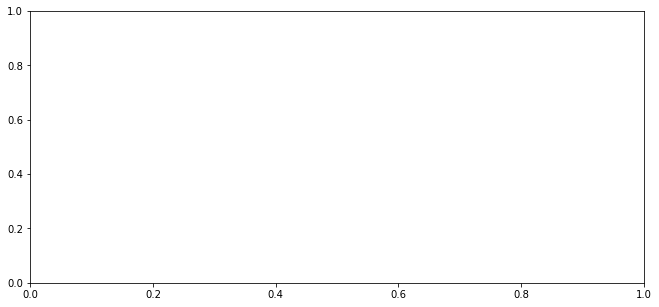

In [84]:
#total,BS = bases(50, 200, 100)
#número de UEs
max_UE = 4
N_ue = np.arange(max_UE)+1

#Calculando a capacidade de canal para UE recebendo sinal de todas as BS:
p = np.ones(max_UE)
p = p * inv_dbm(P_t)

fig, ax = plt.subplots(figsize = (11,5))
for num_ue in N_ue:
    C = np.zeros(mc)
    for k in range(mc):
        UE = usuário(num_ue, 200, 100)
        h = channel_user(N, UE, res, i)
        w = get_beamforming(h)
        SINR = sinr(h, w, j, i, σ)
        for SINRi in SINR:
            C[k] += np.log2(1+SINRi.mean())
    C = np.sort(C)# / num_ue
    average_C = np.mean(C)
    std_C = np.std(C)
    cdf_C = norm.cdf(C, loc=average_C, scale=std_C)
    
    label = ('{} users'.format(num_ue))
    ax.plot(C, cdf_C, label=label)
    print('Average Channel Capacity for {} users: {} bits/Hz'.format(num_ue, average_C))
ax.set_ylabel("CDF")
ax.set_xlabel("Channel Capacity [bits/Hz]")
plt.legend()

In [10]:
n_ue = 4
p = np.ones(n_ue)
p = p * inv_db(P_t)
UE = usuário(n_ue, 200, 100)
SINR = compute_sinr(N, UE, BS, p, n_stream)
print('SINR: {}'.format(SINR))
SINR_mean = SINR[0].mean()
print('SINRmean: {}'.format(SINR_mean))

SINR: [[0.53878442 1.30153095 0.62102836]
 [0.62546247 0.72921625 1.00310427]
 [0.68964899 1.04231687 0.69224802]
 [0.7052931  0.70038512 0.51387591]]
SINRmean: 0.820447907679085
